In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:0


In [2]:
lr_tune = np.array([8e-6,8e-5,8e-4,8e-3,8e-2])

In [3]:
def true_smooth(x): #[-3,3]
    term1 = (np.power(x,3) - x)
    term2 = np.sin(7*x)/7  
    
    term3 = np.sin(12*x)
    term12 = np.multiply(term1,term2)

    return 50*(term12  + term3)

In [4]:
# Domain bounds
label = "Regr_smooth_Swish"
loss_thresh = 0.1

lb = np.array(-3.0)  # [-1. 0.]
ub = np.array(3.0) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_smooth(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [5]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_smooth(x_train)

    return x_train, u_train

In [6]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Sigmoid()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.beta = Parameter(torch.ones((layers[1],len(layers)-2)))
        self.beta.requiresGrad = True
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = z*self.activation(self.beta[:,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [7]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(model_NN.beta.cpu().detach().numpy())
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [8]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [9]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    nan_flag = 0 
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
        if(np.isnan(loss_np)):
            nan_flag =1
            print("NAN BREAK!")
            break
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))
    
    return nan_flag

In [10]:
nan_tune = []

for tune_reps in range(5):
    label = "Regr_swish_tune"+str(tune_reps) 
    max_reps = 10
    max_iter = 500
    layers = np.array([1,50,50,50,50,1])

    train_loss_full = []
    test_mse_full = []
    test_re_full = []
    beta_full = []
    elapsed_time= np.zeros((max_reps,1))

    time_threshold = np.empty((max_reps,1))
    time_threshold[:] = np.nan
    epoch_threshold = max_iter*np.ones((max_reps,1))


    for reps in range(max_reps):

        train_loss = []
        test_mse_loss = []
        test_re_loss = []
        beta_val = []
        'Generate Training data'
        N_train = 300

        x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

        'Convert to tensor and send to GPU'
        x_train = torch.from_numpy(x_train_np_array).float().to(device)
        u_train = torch.from_numpy(u_train_np_array).float().to(device)

        x_test_tensor = torch.from_numpy(x_test).float().to(device)


        model_NN = Sequentialmodel(layers)
        model_NN.to(device)
        print(model_NN)
        params = list(model_NN.parameters())
        #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        optimizer = optim.Adam(model_NN.parameters(), lr=lr_tune[tune_reps])

        nan_flag = train_model(max_iter,reps)

        torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
        train_loss_full.append(train_loss)
        test_mse_full.append(test_mse_loss)
        test_re_full.append(test_re_loss)
        beta_full.append(beta_val)
        
        if(nan_flag == 1):
            nan_tune.append(tune_reps)
            break


    mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold,"beta": beta_full, "label": label}
    savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 3618.7754 Test MSE 3507.4200118557196 Test RE 0.9999900935062461
1 Train Loss 3618.7727 Test MSE 3507.4187328397716 Test RE 0.9999899111780122
2 Train Loss 3618.7705 Test MSE 3507.4174536667742 Test RE 0.9999897288273567
3 Train Loss 3618.7683 Test MSE 3507.416174300081 Test RE 0.9999895464490561
4 Train Loss 3618.7659 Test MSE 3507.414894713535 Test RE 0.9999893640393817
5 Train Loss 3618.7634 Test MSE 3507.413614910732 Test RE 0.9999891815988454
6 Train Loss 3618.761 Test MSE 3507.412334929223 Test RE 0.999988999132801
7 Train Loss 3618.7583 Test MSE 3507.4110547178575 Test R

102 Train Loss 3618.523 Test MSE 3507.2875640632856 Test RE 0.999971212429802
103 Train Loss 3618.5205 Test MSE 3507.2862374946353 Test RE 0.9999710233191915
104 Train Loss 3618.5176 Test MSE 3507.284910213704 Test RE 0.9999708341070047
105 Train Loss 3618.5151 Test MSE 3507.283582257307 Test RE 0.9999706447984903
106 Train Loss 3618.5127 Test MSE 3507.2822536029153 Test RE 0.9999704553904363
107 Train Loss 3618.51 Test MSE 3507.2809242766107 Test RE 0.9999702658865615
108 Train Loss 3618.5076 Test MSE 3507.2795942792955 Test RE 0.9999700762869935
109 Train Loss 3618.5051 Test MSE 3507.2782635669755 Test RE 0.9999698865854614
110 Train Loss 3618.5027 Test MSE 3507.276932164976 Test RE 0.9999696967855749
111 Train Loss 3618.5 Test MSE 3507.2756000864815 Test RE 0.9999695068892134
112 Train Loss 3618.4976 Test MSE 3507.27426727821 Test RE 0.9999693168887819
113 Train Loss 3618.495 Test MSE 3507.272933736583 Test RE 0.9999691267837695
114 Train Loss 3618.4927 Test MSE 3507.2715995244366 T

206 Train Loss 3618.2512 Test MSE 3507.14541447625 Test RE 0.9999509479187508
207 Train Loss 3618.2485 Test MSE 3507.144001485668 Test RE 0.9999507464840729
208 Train Loss 3618.2458 Test MSE 3507.142587520463 Test RE 0.9999505449104129
209 Train Loss 3618.2434 Test MSE 3507.1411725739686 Test RE 0.9999503431968202
210 Train Loss 3618.24 Test MSE 3507.139756624682 Test RE 0.9999501413402301
211 Train Loss 3618.2375 Test MSE 3507.1383396968145 Test RE 0.999949939344093
212 Train Loss 3618.2346 Test MSE 3507.1369217814076 Test RE 0.9999497372071326
213 Train Loss 3618.2322 Test MSE 3507.1355028916655 Test RE 0.9999495349312306
214 Train Loss 3618.2297 Test MSE 3507.134083011056 Test RE 0.9999493325140303
215 Train Loss 3618.2268 Test MSE 3507.1326621029534 Test RE 0.9999491299503105
216 Train Loss 3618.2239 Test MSE 3507.1312402223266 Test RE 0.999948927247907
217 Train Loss 3618.221 Test MSE 3507.1298173195705 Test RE 0.9999487243997482
218 Train Loss 3618.2185 Test MSE 3507.128393400672

310 Train Loss 3617.9585 Test MSE 3506.9927096649258 Test RE 0.9999291782221775
311 Train Loss 3617.9556 Test MSE 3506.991180022811 Test RE 0.9999289601530116
312 Train Loss 3617.9526 Test MSE 3506.989649187959 Test RE 0.9999287419137589
313 Train Loss 3617.9492 Test MSE 3506.9881170388826 Test RE 0.9999285234870999
314 Train Loss 3617.9468 Test MSE 3506.9865836359872 Test RE 0.9999283048816454
315 Train Loss 3617.9434 Test MSE 3506.985048958863 Test RE 0.9999280860944865
316 Train Loss 3617.9404 Test MSE 3506.983513079313 Test RE 0.9999278671358588
317 Train Loss 3617.9375 Test MSE 3506.981975890353 Test RE 0.9999276479905106
318 Train Loss 3617.935 Test MSE 3506.98043747784 Test RE 0.9999274286706814
319 Train Loss 3617.9316 Test MSE 3506.9788976913055 Test RE 0.9999272091549206
320 Train Loss 3617.929 Test MSE 3506.9773567135308 Test RE 0.9999269894692852
321 Train Loss 3617.926 Test MSE 3506.975814446468 Test RE 0.9999267695997973
322 Train Loss 3617.9233 Test MSE 3506.974270854314

415 Train Loss 3617.6355 Test MSE 3506.824835251537 Test RE 0.999905245390404
416 Train Loss 3617.632 Test MSE 3506.8231619835706 Test RE 0.9999050068399069
417 Train Loss 3617.629 Test MSE 3506.8214872505637 Test RE 0.9999047680804881
418 Train Loss 3617.626 Test MSE 3506.819811024961 Test RE 0.9999045291082194
419 Train Loss 3617.6226 Test MSE 3506.818133305381 Test RE 0.9999042899229036
420 Train Loss 3617.6191 Test MSE 3506.816454104796 Test RE 0.9999040505263904
421 Train Loss 3617.616 Test MSE 3506.8147734800036 Test RE 0.999903810926776
422 Train Loss 3617.6125 Test MSE 3506.8130912671636 Test RE 0.9999035711007032
423 Train Loss 3617.6094 Test MSE 3506.81140766217 Test RE 0.9999033310760991
424 Train Loss 3617.6064 Test MSE 3506.8097225187926 Test RE 0.9999030908321163
425 Train Loss 3617.603 Test MSE 3506.8080358685656 Test RE 0.9999028503732506
426 Train Loss 3617.5996 Test MSE 3506.806347706873 Test RE 0.999902609698843
427 Train Loss 3617.5964 Test MSE 3506.804658076254 Tes

15 Train Loss 3664.7896 Test MSE 3507.493498730354 Test RE 1.0000005692635658
16 Train Loss 3664.788 Test MSE 3507.4921756442423 Test RE 1.0000003806549496
17 Train Loss 3664.7869 Test MSE 3507.490852598979 Test RE 1.0000001920521209
18 Train Loss 3664.7852 Test MSE 3507.489529564206 Test RE 1.0000000034507521
19 Train Loss 3664.7834 Test MSE 3507.4882065903485 Test RE 0.9999998148580314
20 Train Loss 3664.7822 Test MSE 3507.48688364254 Test RE 0.9999996262689882
21 Train Loss 3664.781 Test MSE 3507.4855607040527 Test RE 0.9999994376812387
22 Train Loss 3664.7793 Test MSE 3507.484237810081 Test RE 0.9999992490997991
23 Train Loss 3664.7776 Test MSE 3507.4829149620887 Test RE 0.9999990605248784
24 Train Loss 3664.776 Test MSE 3507.4815921106633 Test RE 0.9999988719494327
25 Train Loss 3664.7747 Test MSE 3507.4802692510007 Test RE 0.9999986833727775
26 Train Loss 3664.7734 Test MSE 3507.478946415741 Test RE 0.9999984947995649
27 Train Loss 3664.7717 Test MSE 3507.4776235992654 Test RE 0.

121 Train Loss 3664.6318 Test MSE 3507.3528267393363 Test RE 0.9999805159859719
122 Train Loss 3664.6301 Test MSE 3507.3514885875975 Test RE 0.9999803252258943
123 Train Loss 3664.629 Test MSE 3507.350150076111 Test RE 0.9999801344144967
124 Train Loss 3664.6277 Test MSE 3507.3488111939237 Test RE 0.9999799435502172
125 Train Loss 3664.626 Test MSE 3507.347471985927 Test RE 0.9999797526394559
126 Train Loss 3664.6243 Test MSE 3507.346132404652 Test RE 0.999979561675445
127 Train Loss 3664.623 Test MSE 3507.344792484844 Test RE 0.9999793706631385
128 Train Loss 3664.6213 Test MSE 3507.343452206994 Test RE 0.9999791795997546
129 Train Loss 3664.62 Test MSE 3507.342111539728 Test RE 0.999978988480821
130 Train Loss 3664.6184 Test MSE 3507.3407705307263 Test RE 0.9999787973131344
131 Train Loss 3664.6167 Test MSE 3507.33942916245 Test RE 0.9999786060941952
132 Train Loss 3664.615 Test MSE 3507.3380874150644 Test RE 0.9999784148211753
133 Train Loss 3664.6138 Test MSE 3507.3367452768957 Tes

226 Train Loss 3664.4714 Test MSE 3507.209799936203 Test RE 0.9999601266094831
227 Train Loss 3664.47 Test MSE 3507.208407534787 Test RE 0.9999599281118007
228 Train Loss 3664.4685 Test MSE 3507.2070144480567 Test RE 0.9999597295163819
229 Train Loss 3664.4668 Test MSE 3507.2056206842412 Test RE 0.9999595308243999
230 Train Loss 3664.465 Test MSE 3507.2042262537807 Test RE 0.9999593320373429
231 Train Loss 3664.4639 Test MSE 3507.2028311410745 Test RE 0.9999591331529866
232 Train Loss 3664.4622 Test MSE 3507.201435346652 Test RE 0.9999589341714069
233 Train Loss 3664.461 Test MSE 3507.2000388706088 Test RE 0.9999587350926171
234 Train Loss 3664.4585 Test MSE 3507.198641707182 Test RE 0.9999585359157955
235 Train Loss 3664.4575 Test MSE 3507.19724390212 Test RE 0.9999583366474639
236 Train Loss 3664.4558 Test MSE 3507.195845312025 Test RE 0.9999581372671802
237 Train Loss 3664.4543 Test MSE 3507.194446076296 Test RE 0.9999579377948163
238 Train Loss 3664.4526 Test MSE 3507.1930461543984

330 Train Loss 3664.3047 Test MSE 3507.06094755343 Test RE 0.9999389063182293
331 Train Loss 3664.303 Test MSE 3507.0594721481393 Test RE 0.9999386959832324
332 Train Loss 3664.3013 Test MSE 3507.0579957960076 Test RE 0.9999384855132085
333 Train Loss 3664.2996 Test MSE 3507.0565184904326 Test RE 0.9999382749072168
334 Train Loss 3664.298 Test MSE 3507.0550402938984 Test RE 0.9999380641741645
335 Train Loss 3664.2964 Test MSE 3507.0535611522378 Test RE 0.99993785330633
336 Train Loss 3664.2947 Test MSE 3507.0520810553094 Test RE 0.999937642302267
337 Train Loss 3664.2935 Test MSE 3507.0506000436394 Test RE 0.9999374311677529
338 Train Loss 3664.2913 Test MSE 3507.0491180375893 Test RE 0.9999372198914344
339 Train Loss 3664.29 Test MSE 3507.0476351516954 Test RE 0.9999370084896396
340 Train Loss 3664.288 Test MSE 3507.046151295524 Test RE 0.9999367969494765
341 Train Loss 3664.2864 Test MSE 3507.0446664191463 Test RE 0.999936585263827
342 Train Loss 3664.2847 Test MSE 3507.043180660694 

434 Train Loss 3664.1267 Test MSE 3506.9020538879786 Test RE 0.9999162540518303
435 Train Loss 3664.1248 Test MSE 3506.900467951357 Test RE 0.9999160279542718
436 Train Loss 3664.1235 Test MSE 3506.898880974042 Test RE 0.9999158017082962
437 Train Loss 3664.1213 Test MSE 3506.8972926480296 Test RE 0.9999155752699942
438 Train Loss 3664.1196 Test MSE 3506.895703210945 Test RE 0.9999153486732414
439 Train Loss 3664.1177 Test MSE 3506.89411250564 Test RE 0.9999151218956347
440 Train Loss 3664.116 Test MSE 3506.892520687848 Test RE 0.9999148949593756
441 Train Loss 3664.1143 Test MSE 3506.890927566342 Test RE 0.9999146678372016
442 Train Loss 3664.1125 Test MSE 3506.8893333216038 Test RE 0.9999144405548438
443 Train Loss 3664.1108 Test MSE 3506.8877378118927 Test RE 0.9999142130920939
444 Train Loss 3664.109 Test MSE 3506.886141076846 Test RE 0.9999139854546034
445 Train Loss 3664.1067 Test MSE 3506.8845431564805 Test RE 0.9999137576480763
446 Train Loss 3664.105 Test MSE 3506.882944093621

34 Train Loss 3131.979 Test MSE 3507.403372022451 Test RE 0.9999877214367328
35 Train Loss 3131.978 Test MSE 3507.402345001007 Test RE 0.9999875750308594
36 Train Loss 3131.9768 Test MSE 3507.401317693689 Test RE 0.9999874285842119
37 Train Loss 3131.9758 Test MSE 3507.4002900833143 Test RE 0.9999872820943412
38 Train Loss 3131.9746 Test MSE 3507.39926218387 Test RE 0.9999871355632408
39 Train Loss 3131.9739 Test MSE 3507.398233977149 Test RE 0.9999869889883158
40 Train Loss 3131.973 Test MSE 3507.3972054638166 Test RE 0.9999868423696606
41 Train Loss 3131.9717 Test MSE 3507.3961766500406 Test RE 0.9999866957081541
42 Train Loss 3131.9705 Test MSE 3507.395147508588 Test RE 0.9999865489999146
43 Train Loss 3131.9695 Test MSE 3507.3941180572483 Test RE 0.9999864022474781
44 Train Loss 3131.9685 Test MSE 3507.3930883013645 Test RE 0.9999862554516058
45 Train Loss 3131.9675 Test MSE 3507.39205823313 Test RE 0.9999861086111853
46 Train Loss 3131.9663 Test MSE 3507.3910278165304 Test RE 0.99

139 Train Loss 3131.865 Test MSE 3507.2932880226526 Test RE 0.9999720284153961
140 Train Loss 3131.864 Test MSE 3507.2922113341365 Test RE 0.9999718749268806
141 Train Loss 3131.863 Test MSE 3507.2911340208398 Test RE 0.9999717213492747
142 Train Loss 3131.8618 Test MSE 3507.290056061038 Test RE 0.9999715676794824
143 Train Loss 3131.8606 Test MSE 3507.288977433651 Test RE 0.9999714139144977
144 Train Loss 3131.8594 Test MSE 3507.2878981669833 Test RE 0.9999712600583563
145 Train Loss 3131.8584 Test MSE 3507.28681824369 Test RE 0.9999711061085849
146 Train Loss 3131.8574 Test MSE 3507.285737649856 Test RE 0.9999709520632
147 Train Loss 3131.8564 Test MSE 3507.2846564041433 Test RE 0.9999707979248624
148 Train Loss 3131.855 Test MSE 3507.2835745034363 Test RE 0.999970643693127
149 Train Loss 3131.854 Test MSE 3507.282491935928 Test RE 0.9999704893663116
150 Train Loss 3131.8528 Test MSE 3507.281408685019 Test RE 0.9999703349420489
151 Train Loss 3131.8516 Test MSE 3507.280324784224 Test

243 Train Loss 3131.745 Test MSE 3507.1774550452483 Test RE 0.9999555155828166
244 Train Loss 3131.744 Test MSE 3507.1762998161284 Test RE 0.9999553508951381
245 Train Loss 3131.7427 Test MSE 3507.1751437323423 Test RE 0.9999551860855928
246 Train Loss 3131.7412 Test MSE 3507.1739867935075 Test RE 0.9999550211541258
247 Train Loss 3131.74 Test MSE 3507.1728289702496 Test RE 0.9999548560965493
248 Train Loss 3131.739 Test MSE 3507.171670298635 Test RE 0.9999546909180053
249 Train Loss 3131.7375 Test MSE 3507.1705107680364 Test RE 0.9999545256169784
250 Train Loss 3131.7368 Test MSE 3507.1693503880447 Test RE 0.9999543601948357
251 Train Loss 3131.7356 Test MSE 3507.1681891212725 Test RE 0.9999541946462478
252 Train Loss 3131.7341 Test MSE 3507.1670270002523 Test RE 0.9999540289758517
253 Train Loss 3131.733 Test MSE 3507.165864002366 Test RE 0.9999538631804236
254 Train Loss 3131.7317 Test MSE 3507.164700121851 Test RE 0.9999536972591414
255 Train Loss 3131.7305 Test MSE 3507.1635353823

348 Train Loss 3131.6135 Test MSE 3507.051148326545 Test RE 0.9999375093315208
349 Train Loss 3131.6123 Test MSE 3507.0498934505295 Test RE 0.9999373304351121
350 Train Loss 3131.6108 Test MSE 3507.048637473515 Test RE 0.9999371513817124
351 Train Loss 3131.6096 Test MSE 3507.047380483288 Test RE 0.9999369721838355
352 Train Loss 3131.6084 Test MSE 3507.046122417858 Test RE 0.9999367928326444
353 Train Loss 3131.607 Test MSE 3507.0448633016945 Test RE 0.9999366133316274
354 Train Loss 3131.606 Test MSE 3507.043603160125 Test RE 0.999936433684395
355 Train Loss 3131.6045 Test MSE 3507.042341919401 Test RE 0.9999362538804338
356 Train Loss 3131.603 Test MSE 3507.041079641046 Test RE 0.999936073928514
357 Train Loss 3131.6018 Test MSE 3507.0398162866327 Test RE 0.999935893823158
358 Train Loss 3131.6006 Test MSE 3507.038551848192 Test RE 0.999935713563229
359 Train Loss 3131.599 Test MSE 3507.0372863765156 Test RE 0.999935533155968
360 Train Loss 3131.598 Test MSE 3507.0360198110934 Test 

452 Train Loss 3131.4714 Test MSE 3506.9146359558804 Test RE 0.9999180478006613
453 Train Loss 3131.47 Test MSE 3506.913260420636 Test RE 0.9999178516991313
454 Train Loss 3131.4685 Test MSE 3506.9118835560002 Test RE 0.9999176554080398
455 Train Loss 3131.467 Test MSE 3506.9105054070615 Test RE 0.9999174589338146
456 Train Loss 3131.4658 Test MSE 3506.9091259842967 Test RE 0.9999172622779489
457 Train Loss 3131.4644 Test MSE 3506.907745279858 Test RE 0.9999170654393245
458 Train Loss 3131.463 Test MSE 3506.9063632545976 Test RE 0.9999168684123594
459 Train Loss 3131.4614 Test MSE 3506.9049799228596 Test RE 0.9999166711990988
460 Train Loss 3131.46 Test MSE 3506.903595281466 Test RE 0.99991647379909
461 Train Loss 3131.4585 Test MSE 3506.9022094122984 Test RE 0.9999162762240054
462 Train Loss 3131.4573 Test MSE 3506.900822194304 Test RE 0.9999160784565876
463 Train Loss 3131.4556 Test MSE 3506.8994336567716 Test RE 0.9999158805010122
464 Train Loss 3131.4543 Test MSE 3506.8980438055637

52 Train Loss 3462.7449 Test MSE 3507.4975705531147 Test RE 1.0000011497099583
53 Train Loss 3462.7446 Test MSE 3507.496213615991 Test RE 1.0000009562759236
54 Train Loss 3462.7441 Test MSE 3507.49485656395 Test RE 1.0000007628254695
55 Train Loss 3462.7437 Test MSE 3507.493499435733 Test RE 1.000000569364119
56 Train Loss 3462.7432 Test MSE 3507.492142188615 Test RE 1.0000003758857816
57 Train Loss 3462.7427 Test MSE 3507.4907848766948 Test RE 1.0000001823981688
58 Train Loss 3462.7424 Test MSE 3507.489427406343 Test RE 0.9999999888879341
59 Train Loss 3462.7417 Test MSE 3507.488069882848 Test RE 0.9999997953700861
60 Train Loss 3462.7415 Test MSE 3507.486712209374 Test RE 0.9999996018308208
61 Train Loss 3462.7412 Test MSE 3507.485354439725 Test RE 0.9999994082778083
62 Train Loss 3462.7405 Test MSE 3507.4839965370147 Test RE 0.99999921470579
63 Train Loss 3462.74 Test MSE 3507.4826385093743 Test RE 0.9999990211159251
64 Train Loss 3462.7397 Test MSE 3507.4812803520776 Test RE 0.9999

157 Train Loss 3462.6978 Test MSE 3507.353886366209 Test RE 0.9999806670409411
158 Train Loss 3462.6973 Test MSE 3507.352499350661 Test RE 0.9999804693151179
159 Train Loss 3462.6968 Test MSE 3507.351111874261 Test RE 0.9999802715235585
160 Train Loss 3462.6963 Test MSE 3507.349723930828 Test RE 0.9999800736653824
161 Train Loss 3462.6958 Test MSE 3507.348335468251 Test RE 0.9999798757331605
162 Train Loss 3462.6956 Test MSE 3507.346946549433 Test RE 0.99997967773586
163 Train Loss 3462.6946 Test MSE 3507.3455571307036 Test RE 0.9999794796672555
164 Train Loss 3462.6946 Test MSE 3507.3441672568515 Test RE 0.9999792815337316
165 Train Loss 3462.694 Test MSE 3507.3427768479223 Test RE 0.9999790833238903
166 Train Loss 3462.6934 Test MSE 3507.3413859791326 Test RE 0.9999788850484548
167 Train Loss 3462.693 Test MSE 3507.3399945995116 Test RE 0.9999786867001578
168 Train Loss 3462.6929 Test MSE 3507.338602704546 Test RE 0.9999784882783568
169 Train Loss 3462.6921 Test MSE 3507.337210330829

262 Train Loss 3462.649 Test MSE 3507.205119894319 Test RE 0.9999594594328524
263 Train Loss 3462.6484 Test MSE 3507.2036673350794 Test RE 0.9999592523590638
264 Train Loss 3462.6477 Test MSE 3507.2022139599653 Test RE 0.9999590451689231
265 Train Loss 3462.6475 Test MSE 3507.2007598110804 Test RE 0.9999588378684323
266 Train Loss 3462.647 Test MSE 3507.1993048987047 Test RE 0.9999586304590564
267 Train Loss 3462.6462 Test MSE 3507.197849172527 Test RE 0.9999584229336239
268 Train Loss 3462.646 Test MSE 3507.1963926689186 Test RE 0.9999582152973192
269 Train Loss 3462.6455 Test MSE 3507.194935356655 Test RE 0.9999580075456911
270 Train Loss 3462.6448 Test MSE 3507.193477308157 Test RE 0.9999577996890634
271 Train Loss 3462.6448 Test MSE 3507.192018388899 Test RE 0.9999575917082588
272 Train Loss 3462.6443 Test MSE 3507.1905586898783 Test RE 0.9999573836162494
273 Train Loss 3462.6433 Test MSE 3507.189098213342 Test RE 0.9999571754133558
274 Train Loss 3462.643 Test MSE 3507.18763693004

366 Train Loss 3462.598 Test MSE 3507.0493830473506 Test RE 0.9999372576715039
367 Train Loss 3462.5974 Test MSE 3507.0478350871867 Test RE 0.9999370369926592
368 Train Loss 3462.5967 Test MSE 3507.046286110277 Test RE 0.9999368161688172
369 Train Loss 3462.5964 Test MSE 3507.044736008743 Test RE 0.9999365951845992
370 Train Loss 3462.5957 Test MSE 3507.0431849234587 Test RE 0.9999363740600875
371 Train Loss 3462.5955 Test MSE 3507.041632738149 Test RE 0.9999361527787058
372 Train Loss 3462.5947 Test MSE 3507.0400795399187 Test RE 0.9999359313528723
373 Train Loss 3462.5942 Test MSE 3507.0385252631313 Test RE 0.9999357097732288
374 Train Loss 3462.5938 Test MSE 3507.0369699421135 Test RE 0.9999354880446697
375 Train Loss 3462.5933 Test MSE 3507.0354135559837 Test RE 0.9999352661642177
376 Train Loss 3462.5925 Test MSE 3507.0338560979803 Test RE 0.9999350441309086
377 Train Loss 3462.5923 Test MSE 3507.0322975807658 Test RE 0.9999348219465475
378 Train Loss 3462.5918 Test MSE 3507.03073

471 Train Loss 3462.5427 Test MSE 3506.880776194796 Test RE 0.9999132206133126
472 Train Loss 3462.5422 Test MSE 3506.879108198973 Test RE 0.9999129828163387
473 Train Loss 3462.5415 Test MSE 3506.877439081925 Test RE 0.9999127448594612
474 Train Loss 3462.541 Test MSE 3506.875768624144 Test RE 0.9999125067113859
475 Train Loss 3462.5403 Test MSE 3506.8740969867995 Test RE 0.9999122683950902
476 Train Loss 3462.54 Test MSE 3506.8724240463184 Test RE 0.9999120298929562
477 Train Loss 3462.5393 Test MSE 3506.8707500144615 Test RE 0.9999117912351739
478 Train Loss 3462.5388 Test MSE 3506.8690745464164 Test RE 0.9999115523725848
479 Train Loss 3462.5383 Test MSE 3506.867397968916 Test RE 0.9999113133517695
480 Train Loss 3462.5376 Test MSE 3506.865720147291 Test RE 0.9999110741535285
481 Train Loss 3462.537 Test MSE 3506.8640410527355 Test RE 0.9999108347737552
482 Train Loss 3462.5369 Test MSE 3506.86236068532 Test RE 0.9999105952124596
483 Train Loss 3462.5364 Test MSE 3506.860679124088 

72 Train Loss 3132.3152 Test MSE 3507.159703439993 Test RE 0.9999529849384059
73 Train Loss 3132.3137 Test MSE 3507.1580937529625 Test RE 0.9999527554633217
74 Train Loss 3132.3127 Test MSE 3507.156483217395 Test RE 0.9999525258672187
75 Train Loss 3132.3113 Test MSE 3507.1548718396734 Test RE 0.999952296151006
76 Train Loss 3132.31 Test MSE 3507.153259702281 Test RE 0.999952066326443
77 Train Loss 3132.3088 Test MSE 3507.151646654661 Test RE 0.999951836372066
78 Train Loss 3132.3076 Test MSE 3507.1500327827926 Test RE 0.9999516063001319
79 Train Loss 3132.3064 Test MSE 3507.148418116274 Test RE 0.9999513761148607
80 Train Loss 3132.3052 Test MSE 3507.1468026279595 Test RE 0.9999511458123816
81 Train Loss 3132.3037 Test MSE 3507.145186258322 Test RE 0.9999509153842091
82 Train Loss 3132.3022 Test MSE 3507.1435690697895 Test RE 0.9999506848392423
83 Train Loss 3132.301 Test MSE 3507.141950993969 Test RE 0.9999504541677318
84 Train Loss 3132.2996 Test MSE 3507.140332061562 Test RE 0.9999

176 Train Loss 3132.1775 Test MSE 3506.9873147710186 Test RE 0.9999284091139482
177 Train Loss 3132.1763 Test MSE 3506.985602469603 Test RE 0.9999281650042773
178 Train Loss 3132.1746 Test MSE 3506.9838889998477 Test RE 0.9999279207279853
179 Train Loss 3132.1733 Test MSE 3506.9821743967723 Test RE 0.9999276762900648
180 Train Loss 3132.172 Test MSE 3506.980458580377 Test RE 0.999927431679111
181 Train Loss 3132.1707 Test MSE 3506.978741628034 Test RE 0.9999271869061535
182 Train Loss 3132.1694 Test MSE 3506.9770235250076 Test RE 0.9999269419690918
183 Train Loss 3132.168 Test MSE 3506.9753042369266 Test RE 0.9999266968630259
184 Train Loss 3132.1665 Test MSE 3506.973583703515 Test RE 0.9999264515793621
185 Train Loss 3132.1655 Test MSE 3506.971862066363 Test RE 0.9999262061382861
186 Train Loss 3132.1638 Test MSE 3506.970139127238 Test RE 0.999925960511537
187 Train Loss 3132.1626 Test MSE 3506.9684150957746 Test RE 0.9999257147290014
188 Train Loss 3132.1614 Test MSE 3506.96668979136

280 Train Loss 3132.0305 Test MSE 3506.802377186724 Test RE 0.9999020436375626
281 Train Loss 3132.029 Test MSE 3506.800525443584 Test RE 0.9999017796417914
282 Train Loss 3132.0276 Test MSE 3506.7986722116893 Test RE 0.9999015154337049
283 Train Loss 3132.026 Test MSE 3506.79681749189 Test RE 0.9999012510134234
284 Train Loss 3132.0247 Test MSE 3506.794961182604 Test RE 0.9999009863664652
285 Train Loss 3132.023 Test MSE 3506.79310336544 Test RE 0.999900721504464
286 Train Loss 3132.0217 Test MSE 3506.7912440641803 Test RE 0.9999004564308112
287 Train Loss 3132.02 Test MSE 3506.78938321372 Test RE 0.9999001911362237
288 Train Loss 3132.0188 Test MSE 3506.7875208625214 Test RE 0.9998999256276112
289 Train Loss 3132.017 Test MSE 3506.7856568288703 Test RE 0.9998996598790671
290 Train Loss 3132.0159 Test MSE 3506.7837913700537 Test RE 0.9998993939272716
291 Train Loss 3132.0142 Test MSE 3506.781924305386 Test RE 0.9998991277464647
292 Train Loss 3132.0127 Test MSE 3506.780055720322 Test 

384 Train Loss 3131.8708 Test MSE 3506.6010203577002 Test RE 0.9998733365743454
385 Train Loss 3131.8694 Test MSE 3506.5989913267613 Test RE 0.999873047295038
386 Train Loss 3131.8677 Test MSE 3506.596960443135 Test RE 0.9998727577515089
387 Train Loss 3131.8662 Test MSE 3506.5949275983407 Test RE 0.9998724679282918
388 Train Loss 3131.8645 Test MSE 3506.592892866969 Test RE 0.9998721778360208
389 Train Loss 3131.8628 Test MSE 3506.5908562341883 Test RE 0.9998718874725808
390 Train Loss 3131.8613 Test MSE 3506.588817624004 Test RE 0.9998715968271371
391 Train Loss 3131.8599 Test MSE 3506.5867771586736 Test RE 0.9998713059171201
392 Train Loss 3131.858 Test MSE 3506.584734680898 Test RE 0.9998710147201033
393 Train Loss 3131.8564 Test MSE 3506.5826904226606 Test RE 0.99987072326916
394 Train Loss 3131.8547 Test MSE 3506.580644127026 Test RE 0.9998704315276591
395 Train Loss 3131.853 Test MSE 3506.578595822844 Test RE 0.9998701394997133
396 Train Loss 3131.8518 Test MSE 3506.576545720142

489 Train Loss 3131.694 Test MSE 3506.3768614994547 Test RE 0.9998413776993258
490 Train Loss 3131.6921 Test MSE 3506.3746119282405 Test RE 0.9998410569672951
491 Train Loss 3131.6904 Test MSE 3506.3723600702992 Test RE 0.9998407359091318
492 Train Loss 3131.6887 Test MSE 3506.370105967392 Test RE 0.9998404145307896
493 Train Loss 3131.687 Test MSE 3506.3678494737374 Test RE 0.9998400928114836
494 Train Loss 3131.6853 Test MSE 3506.365590693499 Test RE 0.9998397707660645
495 Train Loss 3131.6833 Test MSE 3506.363329703581 Test RE 0.9998394484054967
496 Train Loss 3131.6816 Test MSE 3506.361066263604 Test RE 0.9998391256955077
497 Train Loss 3131.68 Test MSE 3506.3588005587076 Test RE 0.9998388026624933
498 Train Loss 3131.678 Test MSE 3506.356532666072 Test RE 0.9998384793174575
499 Train Loss 3131.6763 Test MSE 3506.3542622765945 Test RE 0.9998381556163296
Training time: 88.46
Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Lin

90 Train Loss 3387.6956 Test MSE 3507.43798342792 Test RE 0.9999926554137286
91 Train Loss 3387.6936 Test MSE 3507.4366936642973 Test RE 0.9999924715538465
92 Train Loss 3387.6917 Test MSE 3507.4354036556397 Test RE 0.999992287659
93 Train Loss 3387.6902 Test MSE 3507.4341135076475 Test RE 0.9999921037442571
94 Train Loss 3387.6885 Test MSE 3507.4328231277636 Test RE 0.9999919197964234
95 Train Loss 3387.6868 Test MSE 3507.4315325479533 Test RE 0.9999917358200558
96 Train Loss 3387.6846 Test MSE 3507.4302417974222 Test RE 0.9999915518193179
97 Train Loss 3387.683 Test MSE 3507.4289508304482 Test RE 0.9999913677876907
98 Train Loss 3387.6814 Test MSE 3507.427659641306 Test RE 0.9999911837243594
99 Train Loss 3387.6797 Test MSE 3507.426368242671 Test RE 0.99999099963113
100 Train Loss 3387.678 Test MSE 3507.425076627867 Test RE 0.9999908155070513
101 Train Loss 3387.676 Test MSE 3507.4237847887885 Test RE 0.9999906313509676
102 Train Loss 3387.6743 Test MSE 3507.422492747293 Test RE 0.99

194 Train Loss 3387.5117 Test MSE 3507.3023050864313 Test RE 0.9999733138519167
195 Train Loss 3387.5098 Test MSE 3507.3009802658103 Test RE 0.9999731249908951
196 Train Loss 3387.508 Test MSE 3507.299654922156 Test RE 0.9999729360552767
197 Train Loss 3387.506 Test MSE 3507.2983290916927 Test RE 0.9999727470502248
198 Train Loss 3387.5044 Test MSE 3507.2970027719634 Test RE 0.9999725579753895
199 Train Loss 3387.5027 Test MSE 3507.2956759657473 Test RE 0.9999723688311666
200 Train Loss 3387.5007 Test MSE 3507.29434862459 Test RE 0.9999721796106491
201 Train Loss 3387.499 Test MSE 3507.2930208154653 Test RE 0.9999719903233838
202 Train Loss 3387.497 Test MSE 3507.291692498142 Test RE 0.9999718009636359
203 Train Loss 3387.4954 Test MSE 3507.2903636830624 Test RE 0.9999716115328944
204 Train Loss 3387.494 Test MSE 3507.28903436603 Test RE 0.9999714220305601
205 Train Loss 3387.492 Test MSE 3507.287704502649 Test RE 0.9999712324503046
206 Train Loss 3387.49 Test MSE 3507.2863741380493 Te

299 Train Loss 3387.3186 Test MSE 3507.159963112006 Test RE 0.9999530219569368
300 Train Loss 3387.3167 Test MSE 3507.158570140578 Test RE 0.9999528233765838
301 Train Loss 3387.3152 Test MSE 3507.157176307811 Test RE 0.9999526246733997
302 Train Loss 3387.3132 Test MSE 3507.155781613457 Test RE 0.9999524258473493
303 Train Loss 3387.3113 Test MSE 3507.1543860881907 Test RE 0.9999522269028056
304 Train Loss 3387.3093 Test MSE 3507.1529897897094 Test RE 0.9999520278479935
305 Train Loss 3387.3076 Test MSE 3507.1515926046036 Test RE 0.9999518286667455
306 Train Loss 3387.3054 Test MSE 3507.1501945688237 Test RE 0.9999516293641865
307 Train Loss 3387.3037 Test MSE 3507.14879569182 Test RE 0.9999514299416639
308 Train Loss 3387.3018 Test MSE 3507.14739598587 Test RE 0.9999512304009277
309 Train Loss 3387.2996 Test MSE 3507.145995388071 Test RE 0.9999510307330102
310 Train Loss 3387.298 Test MSE 3507.1445939791433 Test RE 0.9999508309494193
311 Train Loss 3387.296 Test MSE 3507.143191678014

404 Train Loss 3387.1138 Test MSE 3507.0085490857073 Test RE 0.9999314363222698
405 Train Loss 3387.1113 Test MSE 3507.0070510022974 Test RE 0.9999312227526655
406 Train Loss 3387.1094 Test MSE 3507.005551705106 Test RE 0.9999310090099764
407 Train Loss 3387.1072 Test MSE 3507.0040512583664 Test RE 0.9999307951033602
408 Train Loss 3387.1057 Test MSE 3507.002549590734 Test RE 0.999930581022645
409 Train Loss 3387.1035 Test MSE 3507.0010467872885 Test RE 0.9999303667799604
410 Train Loss 3387.1013 Test MSE 3506.999542783708 Test RE 0.9999301523661358
411 Train Loss 3387.0994 Test MSE 3506.9980376053286 Test RE 0.9999299377847836
412 Train Loss 3387.0974 Test MSE 3506.9965312712798 Test RE 0.999929723038631
413 Train Loss 3387.0952 Test MSE 3506.995023700521 Test RE 0.9999295081161238
414 Train Loss 3387.0933 Test MSE 3506.9935149599105 Test RE 0.999929293026794
415 Train Loss 3387.091 Test MSE 3506.992005031661 Test RE 0.9999290777681054
416 Train Loss 3387.0894 Test MSE 3506.9904938611

4 Train Loss 3923.165 Test MSE 3507.540760840603 Test RE 1.0000073065501724
5 Train Loss 3923.1614 Test MSE 3507.5395230443355 Test RE 1.0000071301009872
6 Train Loss 3923.1577 Test MSE 3507.5382853259284 Test RE 1.0000069536628695
7 Train Loss 3923.1543 Test MSE 3507.537047643929 Test RE 1.0000067772299106
8 Train Loss 3923.151 Test MSE 3507.5358100255908 Test RE 1.000006600805996
9 Train Loss 3923.1472 Test MSE 3507.5345724557415 Test RE 1.0000064243889621
10 Train Loss 3923.1438 Test MSE 3507.533334945172 Test RE 1.0000062479803475
11 Train Loss 3923.1401 Test MSE 3507.532097481752 Test RE 1.000006071578423
12 Train Loss 3923.1367 Test MSE 3507.530860061073 Test RE 1.0000058951825601
13 Train Loss 3923.1335 Test MSE 3507.52962266823 Test RE 1.0000057187906344
14 Train Loss 3923.1301 Test MSE 3507.5283853272226 Test RE 1.0000055424060668
15 Train Loss 3923.1267 Test MSE 3507.527148005913 Test RE 1.0000053660242758
16 Train Loss 3923.1226 Test MSE 3507.525910726733 Test RE 1.000005189

110 Train Loss 3922.7935 Test MSE 3507.409171195016 Test RE 0.9999885481307778
111 Train Loss 3922.7898 Test MSE 3507.4079176707555 Test RE 0.999988369436198
112 Train Loss 3922.786 Test MSE 3507.4066637209917 Test RE 0.999988190680929
113 Train Loss 3922.7827 Test MSE 3507.4054093948066 Test RE 0.9999880118719677
114 Train Loss 3922.7788 Test MSE 3507.4041546516764 Test RE 0.9999878330035373
115 Train Loss 3922.7754 Test MSE 3507.402899508121 Test RE 0.9999876540779928
116 Train Loss 3922.7717 Test MSE 3507.4016439411116 Test RE 0.9999874750920511
117 Train Loss 3922.7683 Test MSE 3507.4003879869824 Test RE 0.9999872960508921
118 Train Loss 3922.7651 Test MSE 3507.3991316114198 Test RE 0.9999871169496242
119 Train Loss 3922.7612 Test MSE 3507.397874791782 Test RE 0.9999869377850192
120 Train Loss 3922.7576 Test MSE 3507.3966175931805 Test RE 0.9999867585663597
121 Train Loss 3922.7542 Test MSE 3507.395359919588 Test RE 0.9999865792799556
122 Train Loss 3922.75 Test MSE 3507.3941018233

215 Train Loss 3922.4126 Test MSE 3507.274687979974 Test RE 0.9999693768625407
216 Train Loss 3922.4092 Test MSE 3507.273373203236 Test RE 0.9999691894325964
217 Train Loss 3922.405 Test MSE 3507.2720576876195 Test RE 0.9999690018972849
218 Train Loss 3922.4019 Test MSE 3507.2707413903436 Test RE 0.9999688142505079
219 Train Loss 3922.398 Test MSE 3507.269424365285 Test RE 0.9999686264999453
220 Train Loss 3922.3943 Test MSE 3507.2681065925694 Test RE 0.9999684386427637
221 Train Loss 3922.3901 Test MSE 3507.2667880596823 Test RE 0.9999682506771799
222 Train Loss 3922.3862 Test MSE 3507.2654687461854 Test RE 0.9999680626002793
223 Train Loss 3922.383 Test MSE 3507.2641486562143 Test RE 0.9999678744126517
224 Train Loss 3922.3792 Test MSE 3507.2628278172365 Test RE 0.9999676861182131
225 Train Loss 3922.375 Test MSE 3507.261506195224 Test RE 0.9999674977121118
226 Train Loss 3922.3718 Test MSE 3507.2601838158453 Test RE 0.9999673091980076
227 Train Loss 3922.368 Test MSE 3507.2588606520

319 Train Loss 3922.0122 Test MSE 3507.133454926349 Test RE 0.9999492429746946
320 Train Loss 3922.0085 Test MSE 3507.132048263867 Test RE 0.9999490424418033
321 Train Loss 3922.0042 Test MSE 3507.130640592766 Test RE 0.9999488417650836
322 Train Loss 3922.0 Test MSE 3507.1292319179543 Test RE 0.9999486409452351
323 Train Loss 3921.9963 Test MSE 3507.127822220637 Test RE 0.9999484399795785
324 Train Loss 3921.9922 Test MSE 3507.126411485408 Test RE 0.9999482388659171
325 Train Loss 3921.9885 Test MSE 3507.124999744677 Test RE 0.9999480376088713
326 Train Loss 3921.9844 Test MSE 3507.123586927761 Test RE 0.9999478361983651
327 Train Loss 3921.9805 Test MSE 3507.1221731579544 Test RE 0.9999476346519744
328 Train Loss 3921.9763 Test MSE 3507.120758361375 Test RE 0.9999474329591667
329 Train Loss 3921.9727 Test MSE 3507.1193424951744 Test RE 0.9999472311138335
330 Train Loss 3921.9685 Test MSE 3507.1179255951697 Test RE 0.999947029121081
331 Train Loss 3921.9644 Test MSE 3507.1165076810003

423 Train Loss 3921.58 Test MSE 3506.9813221475833 Test RE 0.9999275547913574
424 Train Loss 3921.5754 Test MSE 3506.9797977290323 Test RE 0.9999273374665215
425 Train Loss 3921.571 Test MSE 3506.978272068777 Test RE 0.9999271199646181
426 Train Loss 3921.5667 Test MSE 3506.976745138593 Test RE 0.9999269022816231
427 Train Loss 3921.5625 Test MSE 3506.975216944006 Test RE 0.999926684418324
428 Train Loss 3921.558 Test MSE 3506.973687499756 Test RE 0.9999264663768227
429 Train Loss 3921.554 Test MSE 3506.972156770929 Test RE 0.9999262481521408
430 Train Loss 3921.5493 Test MSE 3506.9706247757576 Test RE 0.9999260297468779
431 Train Loss 3921.5452 Test MSE 3506.9690914933794 Test RE 0.9999258111580597
432 Train Loss 3921.541 Test MSE 3506.9675569680862 Test RE 0.9999255923920004
433 Train Loss 3921.536 Test MSE 3506.9660211713804 Test RE 0.9999253734446373
434 Train Loss 3921.5317 Test MSE 3506.9644840717065 Test RE 0.9999251543114716
435 Train Loss 3921.5276 Test MSE 3506.9629456677512 

23 Train Loss 3723.2244 Test MSE 3507.4605415232063 Test RE 0.9999958711360655
24 Train Loss 3723.2227 Test MSE 3507.4592647572526 Test RE 0.9999956891296276
25 Train Loss 3723.221 Test MSE 3507.457988005365 Test RE 0.9999955071251615
26 Train Loss 3723.2197 Test MSE 3507.4567112883756 Test RE 0.9999953251256377
27 Train Loss 3723.2185 Test MSE 3507.455434594034 Test RE 0.9999951431293087
28 Train Loss 3723.2168 Test MSE 3507.4541579053807 Test RE 0.9999949611337579
29 Train Loss 3723.2156 Test MSE 3507.4528812539343 Test RE 0.9999947791434778
30 Train Loss 3723.2144 Test MSE 3507.4516046035606 Test RE 0.9999945971533172
31 Train Loss 3723.213 Test MSE 3507.4503279724113 Test RE 0.9999944151658641
32 Train Loss 3723.2114 Test MSE 3507.4490513442383 Test RE 0.9999942331788023
33 Train Loss 3723.2102 Test MSE 3507.4477747257883 Test RE 0.9999940511930935
34 Train Loss 3723.2087 Test MSE 3507.446498130217 Test RE 0.9999938692106131
35 Train Loss 3723.2075 Test MSE 3507.4452215010247 Test 

129 Train Loss 3723.0771 Test MSE 3507.32467895131 Test RE 0.9999765033734035
130 Train Loss 3723.076 Test MSE 3507.3233843806183 Test RE 0.9999763188252775
131 Train Loss 3723.0747 Test MSE 3507.3220893945604 Test RE 0.9999761342179048
132 Train Loss 3723.073 Test MSE 3507.3207940240063 Test RE 0.999975949555686
133 Train Loss 3723.0718 Test MSE 3507.319498240018 Test RE 0.9999757648344957
134 Train Loss 3723.07 Test MSE 3507.3182020563454 Test RE 0.9999755800562941
135 Train Loss 3723.0688 Test MSE 3507.3169054473396 Test RE 0.9999753952174245
136 Train Loss 3723.0671 Test MSE 3507.315608431952 Test RE 0.9999752103205888
137 Train Loss 3723.066 Test MSE 3507.314310999005 Test RE 0.9999750253641934
138 Train Loss 3723.0647 Test MSE 3507.313013141633 Test RE 0.99997484034726
139 Train Loss 3723.0635 Test MSE 3507.311714863129 Test RE 0.9999746552702573
140 Train Loss 3723.0618 Test MSE 3507.310416138028 Test RE 0.9999744701295553
141 Train Loss 3723.0605 Test MSE 3507.3091169888276 Tes

233 Train Loss 3722.9292 Test MSE 3507.187333559133 Test RE 0.9999569238473848
234 Train Loss 3722.9275 Test MSE 3507.185981269455 Test RE 0.9999567310673265
235 Train Loss 3722.926 Test MSE 3507.184628294893 Test RE 0.9999565381895954
236 Train Loss 3722.9246 Test MSE 3507.1832746688656 Test RE 0.9999563452189547
237 Train Loss 3722.9233 Test MSE 3507.181920299099 Test RE 0.9999561521422511
238 Train Loss 3722.9219 Test MSE 3507.180565261852 Test RE 0.9999559589703549
239 Train Loss 3722.9202 Test MSE 3507.179209481989 Test RE 0.9999557656925556
240 Train Loss 3722.919 Test MSE 3507.1778530326987 Test RE 0.9999555723192862
241 Train Loss 3722.9175 Test MSE 3507.1764958756794 Test RE 0.9999553788450867
242 Train Loss 3722.916 Test MSE 3507.1751379851476 Test RE 0.9999551852662814
243 Train Loss 3722.9143 Test MSE 3507.1737793854495 Test RE 0.9999549915863406
244 Train Loss 3722.913 Test MSE 3507.172420089565 Test RE 0.9999547978071154
245 Train Loss 3722.9114 Test MSE 3507.171060057887

337 Train Loss 3722.7727 Test MSE 3507.0425566163303 Test RE 0.9999362844878829
338 Train Loss 3722.771 Test MSE 3507.0411197198546 Test RE 0.9999360796421978
339 Train Loss 3722.7698 Test MSE 3507.0396819194407 Test RE 0.9999358746676043
340 Train Loss 3722.7683 Test MSE 3507.0382431484595 Test RE 0.9999356695546033
341 Train Loss 3722.7664 Test MSE 3507.036803469536 Test RE 0.9999354643121229
342 Train Loss 3722.7651 Test MSE 3507.035362874611 Test RE 0.9999352589390139
343 Train Loss 3722.7634 Test MSE 3507.0339212659733 Test RE 0.9999350534213464
344 Train Loss 3722.7617 Test MSE 3507.032478757238 Test RE 0.9999348477753176
345 Train Loss 3722.76 Test MSE 3507.0310352998913 Test RE 0.9999346419940109
346 Train Loss 3722.7588 Test MSE 3507.0295908562625 Test RE 0.9999344360720563
347 Train Loss 3722.757 Test MSE 3507.0281454757555 Test RE 0.9999342300164967
348 Train Loss 3722.7559 Test MSE 3507.0266991239173 Test RE 0.9999340238224197
349 Train Loss 3722.7542 Test MSE 3507.02525185

441 Train Loss 3722.6055 Test MSE 3506.8877033321046 Test RE 0.9999142081765061
442 Train Loss 3722.6042 Test MSE 3506.8861570992804 Test RE 0.9999139877388312
443 Train Loss 3722.6023 Test MSE 3506.8846096833386 Test RE 0.9999137671324377
444 Train Loss 3722.6 Test MSE 3506.8830611538096 Test RE 0.9999135463672376
445 Train Loss 3722.5984 Test MSE 3506.881511445284 Test RE 0.9999133254339059
446 Train Loss 3722.5972 Test MSE 3506.8799605456084 Test RE 0.9999131043307091
447 Train Loss 3722.5955 Test MSE 3506.878408469834 Test RE 0.9999128830597939
448 Train Loss 3722.5938 Test MSE 3506.8768552188762 Test RE 0.9999126616212903
449 Train Loss 3722.5923 Test MSE 3506.875300817583 Test RE 0.9999124400187402
450 Train Loss 3722.5906 Test MSE 3506.8737451653033 Test RE 0.9999122182377949
451 Train Loss 3722.5884 Test MSE 3506.8721883903595 Test RE 0.9999119962967479
452 Train Loss 3722.5872 Test MSE 3506.8706304125785 Test RE 0.9999117741841699
453 Train Loss 3722.5852 Test MSE 3506.8690712

40 Train Loss 2997.5325 Test MSE 3507.648567385941 Test RE 1.000022674369396
41 Train Loss 2997.5317 Test MSE 3507.6497907081803 Test RE 1.0000228487525828
42 Train Loss 2997.531 Test MSE 3507.651014398076 Test RE 1.000023023188148
43 Train Loss 2997.53 Test MSE 3507.6522384220634 Test RE 1.0000231976713074
44 Train Loss 2997.5293 Test MSE 3507.6534628677628 Test RE 1.0000233722145508
45 Train Loss 2997.5283 Test MSE 3507.6546876145935 Test RE 1.0000235468006897
46 Train Loss 2997.5276 Test MSE 3507.6559127518767 Test RE 1.0000237214424565
47 Train Loss 2997.5269 Test MSE 3507.6571382694615 Test RE 1.0000238961384045
48 Train Loss 2997.526 Test MSE 3507.658364171999 Test RE 1.0000240708891963
49 Train Loss 2997.5251 Test MSE 3507.6595904518235 Test RE 1.0000242456937392
50 Train Loss 2997.5244 Test MSE 3507.6608171148023 Test RE 1.0000244205528699
51 Train Loss 2997.5234 Test MSE 3507.662044205741 Test RE 1.000024595472975
52 Train Loss 2997.5225 Test MSE 3507.6632716382146 Test RE 1.0

145 Train Loss 2997.4465 Test MSE 3507.779712376 Test RE 1.0000413687647072
146 Train Loss 2997.4458 Test MSE 3507.7809942342715 Test RE 1.0000415514887218
147 Train Loss 2997.4446 Test MSE 3507.7822767930247 Test RE 1.0000417343125538
148 Train Loss 2997.4438 Test MSE 3507.7835601263187 Test RE 1.0000419172467607
149 Train Loss 2997.443 Test MSE 3507.7848442110594 Test RE 1.0000421002880497
150 Train Loss 2997.4424 Test MSE 3507.7861290389346 Test RE 1.0000422834352358
151 Train Loss 2997.4417 Test MSE 3507.787414579551 Test RE 1.0000424666839873
152 Train Loss 2997.4407 Test MSE 3507.788700928511 Test RE 1.0000426500479311
153 Train Loss 2997.4397 Test MSE 3507.789988006938 Test RE 1.0000428335158238
154 Train Loss 2997.4387 Test MSE 3507.791275829658 Test RE 1.000043017089779
155 Train Loss 2997.4385 Test MSE 3507.7925644281945 Test RE 1.00004320077429
156 Train Loss 2997.4373 Test MSE 3507.79385379944 Test RE 1.0000433845689136
157 Train Loss 2997.4365 Test MSE 3507.795143929979 Te

249 Train Loss 2997.357 Test MSE 3507.917502160335 Test RE 1.0000610099826086
250 Train Loss 2997.3562 Test MSE 3507.918876133819 Test RE 1.0000612058334482
251 Train Loss 2997.355 Test MSE 3507.9202511494964 Test RE 1.000061401832807
252 Train Loss 2997.3545 Test MSE 3507.9216271775776 Test RE 1.000061597976439
253 Train Loss 2997.3535 Test MSE 3507.9230042676313 Test RE 1.0000617942714092
254 Train Loss 2997.3525 Test MSE 3507.924382433567 Test RE 1.0000619907197013
255 Train Loss 2997.3518 Test MSE 3507.925761534905 Test RE 1.0000621873012894
256 Train Loss 2997.3508 Test MSE 3507.927141779761 Test RE 1.0000623840458398
257 Train Loss 2997.35 Test MSE 3507.9285230406867 Test RE 1.0000625809351853
258 Train Loss 2997.349 Test MSE 3507.929905367026 Test RE 1.0000627779763596
259 Train Loss 2997.3481 Test MSE 3507.9312886480093 Test RE 1.000062975153573
260 Train Loss 2997.3472 Test MSE 3507.932673101535 Test RE 1.000063172497885
261 Train Loss 2997.3464 Test MSE 3507.9340585719656 Tes

354 Train Loss 2997.26 Test MSE 3508.067902540476 Test RE 1.0000824483351098
355 Train Loss 2997.259 Test MSE 3508.0693994358803 Test RE 1.000082661703081
356 Train Loss 2997.2583 Test MSE 3508.0708976344195 Test RE 1.0000828752567557
357 Train Loss 2997.257 Test MSE 3508.0723972106484 Test RE 1.0000830890067611
358 Train Loss 2997.256 Test MSE 3508.073898047247 Test RE 1.000083302936374
359 Train Loss 2997.2554 Test MSE 3508.0754001782993 Test RE 1.0000835170504532
360 Train Loss 2997.2542 Test MSE 3508.0769037430955 Test RE 1.0000837313688522
361 Train Loss 2997.2534 Test MSE 3508.078408597966 Test RE 1.000083945871093
362 Train Loss 2997.2524 Test MSE 3508.0799147522425 Test RE 1.0000841605585051
363 Train Loss 2997.2512 Test MSE 3508.081422202788 Test RE 1.0000843754306414
364 Train Loss 2997.2502 Test MSE 3508.0829310568647 Test RE 1.0000845905027909
365 Train Loss 2997.2493 Test MSE 3508.0844412441816 Test RE 1.0000848057649343
366 Train Loss 2997.2483 Test MSE 3508.0859528025157

458 Train Loss 2997.1553 Test MSE 3508.2311439064724 Test RE 1.0001057165457554
459 Train Loss 2997.1545 Test MSE 3508.2327928290993 Test RE 1.0001059515782666
460 Train Loss 2997.1533 Test MSE 3508.23444345652 Test RE 1.0001061868537189
461 Train Loss 2997.152 Test MSE 3508.2360956269936 Test RE 1.0001064223490577
462 Train Loss 2997.1511 Test MSE 3508.2377493880376 Test RE 1.000106658071056
463 Train Loss 2997.1501 Test MSE 3508.239404816802 Test RE 1.0001068940307105
464 Train Loss 2997.149 Test MSE 3508.2410618422527 Test RE 1.0001071302178959
465 Train Loss 2997.1477 Test MSE 3508.24272046832 Test RE 1.0001073666331721
466 Train Loss 2997.147 Test MSE 3508.2443808119806 Test RE 1.0001076032932128
467 Train Loss 2997.146 Test MSE 3508.246042730156 Test RE 1.0001078401776236
468 Train Loss 2997.1448 Test MSE 3508.2477062445687 Test RE 1.0001080772895008
469 Train Loss 2997.1436 Test MSE 3508.249371465274 Test RE 1.000108314644531
470 Train Loss 2997.1428 Test MSE 3508.2510382886994 

59 Train Loss 3503.5808 Test MSE 3507.5936320608002 Test RE 1.0000148433702507
60 Train Loss 3503.5789 Test MSE 3507.592469104622 Test RE 1.0000146775908507
61 Train Loss 3503.5771 Test MSE 3507.591306341428 Test RE 1.0000145118389332
62 Train Loss 3503.576 Test MSE 3507.590143697136 Test RE 1.0000143461039372
63 Train Loss 3503.5742 Test MSE 3507.588981227854 Test RE 1.0000141803938618
64 Train Loss 3503.5725 Test MSE 3507.587818878805 Test RE 1.000014014700898
65 Train Loss 3503.5706 Test MSE 3507.5866567206263 Test RE 1.0000138490351154
66 Train Loss 3503.5693 Test MSE 3507.5854946505156 Test RE 1.0000136833818594
67 Train Loss 3503.5676 Test MSE 3507.5843327578204 Test RE 1.0000135177538667
68 Train Loss 3503.566 Test MSE 3507.583170975373 Test RE 1.0000133521415622
69 Train Loss 3503.5642 Test MSE 3507.58200933633 Test RE 1.0000131865496729
70 Train Loss 3503.5625 Test MSE 3507.5808477929672 Test RE 1.0000130209713953
71 Train Loss 3503.561 Test MSE 3507.5796863689084 Test RE 1.00

164 Train Loss 3503.4067 Test MSE 3507.4715500056377 Test RE 0.9999974404236183
165 Train Loss 3503.4055 Test MSE 3507.4703806129473 Test RE 0.9999972737237923
166 Train Loss 3503.4038 Test MSE 3507.4692109887824 Test RE 0.9999971069909412
167 Train Loss 3503.402 Test MSE 3507.4680411367353 Test RE 0.999996940225577
168 Train Loss 3503.4001 Test MSE 3507.4668710525416 Test RE 0.9999967734270919
169 Train Loss 3503.3984 Test MSE 3507.465700716978 Test RE 0.9999966065927458
170 Train Loss 3503.3972 Test MSE 3507.4645301552555 Test RE 0.9999964397261321
171 Train Loss 3503.395 Test MSE 3507.463359315024 Test RE 0.9999962728197883
172 Train Loss 3503.3938 Test MSE 3507.4621882607025 Test RE 0.9999961058828978
173 Train Loss 3503.3918 Test MSE 3507.4610169335137 Test RE 0.9999959389070814
174 Train Loss 3503.3904 Test MSE 3507.459845358868 Test RE 0.9999957718959613
175 Train Loss 3503.3884 Test MSE 3507.4586735366415 Test RE 0.9999956048495201
176 Train Loss 3503.3867 Test MSE 3507.4575014

268 Train Loss 3503.2317 Test MSE 3507.3482473697463 Test RE 0.9999798631742804
269 Train Loss 3503.2297 Test MSE 3507.3470407811333 Test RE 0.9999796911690598
270 Train Loss 3503.228 Test MSE 3507.345833675837 Test RE 0.9999795190901536
271 Train Loss 3503.2263 Test MSE 3507.344626070004 Test RE 0.9999793469398639
272 Train Loss 3503.2246 Test MSE 3507.343417991973 Test RE 0.9999791747222299
273 Train Loss 3503.223 Test MSE 3507.3422093921017 Test RE 0.9999790024301755
274 Train Loss 3503.221 Test MSE 3507.341000310995 Test RE 0.9999788300694887
275 Train Loss 3503.2192 Test MSE 3507.3397907006974 Test RE 0.9999786576333335
276 Train Loss 3503.2175 Test MSE 3507.338580591071 Test RE 0.9999784851259665
277 Train Loss 3503.2158 Test MSE 3507.337369964754 Test RE 0.999978312544913
278 Train Loss 3503.2144 Test MSE 3507.336158838968 Test RE 0.9999781398926277
279 Train Loss 3503.2126 Test MSE 3507.334947178915 Test RE 0.9999779671641501
280 Train Loss 3503.211 Test MSE 3507.333735006314 T

373 Train Loss 3503.0464 Test MSE 3507.218328991671 Test RE 0.9999613424920059
374 Train Loss 3503.0442 Test MSE 3507.217054845522 Test RE 0.9999611608527567
375 Train Loss 3503.043 Test MSE 3507.2157799176753 Test RE 0.9999609791020374
376 Train Loss 3503.041 Test MSE 3507.214504187516 Test RE 0.999960797236909
377 Train Loss 3503.0393 Test MSE 3507.2132276413245 Test RE 0.9999606152554161
378 Train Loss 3503.037 Test MSE 3507.21195027007 Test RE 0.9999604331562709
379 Train Loss 3503.0354 Test MSE 3507.2106720832744 Test RE 0.9999602509408309
380 Train Loss 3503.0334 Test MSE 3507.209393087346 Test RE 0.9999600686100094
381 Train Loss 3503.0317 Test MSE 3507.2081132477183 Test RE 0.9999598861588783
382 Train Loss 3503.03 Test MSE 3507.206832595673 Test RE 0.999959703591898
383 Train Loss 3503.0283 Test MSE 3507.205551157519 Test RE 0.9999595209128183
384 Train Loss 3503.0264 Test MSE 3507.2042688578904 Test RE 0.9999593381108951
385 Train Loss 3503.0242 Test MSE 3507.2029857244847 Te

477 Train Loss 3502.8508 Test MSE 3507.080979940932 Test RE 0.9999417621475611
478 Train Loss 3502.8484 Test MSE 3507.0796068136424 Test RE 0.9999415663939609
479 Train Loss 3502.8467 Test MSE 3507.0782325539085 Test RE 0.9999413704788804
480 Train Loss 3502.8447 Test MSE 3507.076857213211 Test RE 0.9999411744096591
481 Train Loss 3502.8425 Test MSE 3507.07548078075 Test RE 0.9999409781847569
482 Train Loss 3502.8408 Test MSE 3507.0741032619767 Test RE 0.999940781804951
483 Train Loss 3502.8384 Test MSE 3507.0727246419065 Test RE 0.9999405852681049
484 Train Loss 3502.8367 Test MSE 3507.071344929781 Test RE 0.9999403885755364
485 Train Loss 3502.8352 Test MSE 3507.0699641013507 Test RE 0.9999401917237877
486 Train Loss 3502.833 Test MSE 3507.068582128804 Test RE 0.9999399947088944
487 Train Loss 3502.8308 Test MSE 3507.067199071672 Test RE 0.9999397975393431
488 Train Loss 3502.8293 Test MSE 3507.0658149089936 Test RE 0.9999396002121453
489 Train Loss 3502.8267 Test MSE 3507.0644296398

76 Train Loss 3616.2485 Test MSE 3506.101762937284 Test RE 0.9998021548303285
77 Train Loss 3616.2046 Test MSE 3506.079395420169 Test RE 0.9997989656577104
78 Train Loss 3616.161 Test MSE 3506.056822102694 Test RE 0.9997957471316526
79 Train Loss 3616.116 Test MSE 3506.0340394849904 Test RE 0.9997924987528545
80 Train Loss 3616.0713 Test MSE 3506.0110445440255 Test RE 0.9997892200899945
81 Train Loss 3616.026 Test MSE 3505.987834402208 Test RE 0.9997859107324804
82 Train Loss 3615.98 Test MSE 3505.9644054065816 Test RE 0.999782570159157
83 Train Loss 3615.9343 Test MSE 3505.9407545382473 Test RE 0.9997791979392664
84 Train Loss 3615.8877 Test MSE 3505.9168786786777 Test RE 0.9997757936278356
85 Train Loss 3615.84 Test MSE 3505.8927744578586 Test RE 0.9997723567440254
86 Train Loss 3615.793 Test MSE 3505.868438517263 Test RE 0.9997688868086235
87 Train Loss 3615.7446 Test MSE 3505.843867689538 Test RE 0.9997653833696678
88 Train Loss 3615.6963 Test MSE 3505.8190587660065 Test RE 0.99976

180 Train Loss 3608.056 Test MSE 3502.004121338137 Test RE 0.999217741015947
181 Train Loss 3607.9233 Test MSE 3501.9393611843016 Test RE 0.9992085020499806
182 Train Loss 3607.7888 Test MSE 3501.8739325845045 Test RE 0.999199167633844
183 Train Loss 3607.6533 Test MSE 3501.807829293894 Test RE 0.9991897368739235
184 Train Loss 3607.5164 Test MSE 3501.7410460840383 Test RE 0.9991802090215557
185 Train Loss 3607.3777 Test MSE 3501.6735764655828 Test RE 0.9991705831481241
186 Train Loss 3607.2375 Test MSE 3501.6054145986714 Test RE 0.9991608584176128
187 Train Loss 3607.096 Test MSE 3501.53655415452 Test RE 0.9991510339241871
188 Train Loss 3606.9526 Test MSE 3501.4669893224204 Test RE 0.9991411088358636
189 Train Loss 3606.8076 Test MSE 3501.3967141511357 Test RE 0.9991310823005447
190 Train Loss 3606.6614 Test MSE 3501.3257223220253 Test RE 0.9991209534136489
191 Train Loss 3606.513 Test MSE 3501.2540075650077 Test RE 0.9991107212774543
192 Train Loss 3606.3635 Test MSE 3501.1815635812

285 Train Loss 3582.6602 Test MSE 3490.5594534635275 Test RE 0.9975836661893963
286 Train Loss 3582.27 Test MSE 3490.4004895335415 Test RE 0.9975609504001803
287 Train Loss 3581.8767 Test MSE 3490.2407055025437 Test RE 0.9975381168980458
288 Train Loss 3581.48 Test MSE 3490.080118535686 Test RE 0.9975151681279334
289 Train Loss 3581.08 Test MSE 3489.9187417718276 Test RE 0.9974921059595683
290 Train Loss 3580.6768 Test MSE 3489.756591143099 Test RE 0.9974689326620066
291 Train Loss 3580.2698 Test MSE 3489.593688571565 Test RE 0.9974456513605424
292 Train Loss 3579.8594 Test MSE 3489.4300472429877 Test RE 0.9974222639321288
293 Train Loss 3579.4456 Test MSE 3489.2656878995504 Test RE 0.9973987733338531
294 Train Loss 3579.0276 Test MSE 3489.1006305496812 Test RE 0.9973751824181756
295 Train Loss 3578.6067 Test MSE 3488.934895085738 Test RE 0.9973514940212054
296 Train Loss 3578.1821 Test MSE 3488.7685019936107 Test RE 0.9973277110641278
297 Train Loss 3577.7542 Test MSE 3488.60147663841

390 Train Loss 3527.0764 Test MSE 3477.0506593076566 Test RE 0.9956514234692815
391 Train Loss 3526.5293 Test MSE 3477.076969167878 Test RE 0.9956551903687019
392 Train Loss 3525.9858 Test MSE 3477.1089609864534 Test RE 0.9956597707601095
393 Train Loss 3525.4463 Test MSE 3477.1466837635703 Test RE 0.9956651716477678
394 Train Loss 3524.911 Test MSE 3477.1901730582144 Test RE 0.9956713981093703
395 Train Loss 3524.3796 Test MSE 3477.239472037286 Test RE 0.9956784563096692
396 Train Loss 3523.8525 Test MSE 3477.2946197436236 Test RE 0.9956863518207276
397 Train Loss 3523.33 Test MSE 3477.355641854411 Test RE 0.9956950882987882
398 Train Loss 3522.8118 Test MSE 3477.4225747888636 Test RE 0.9957046709357468
399 Train Loss 3522.2983 Test MSE 3477.4954369998895 Test RE 0.9957151023489944
400 Train Loss 3521.7896 Test MSE 3477.5742397823037 Test RE 0.9957263841288648
401 Train Loss 3521.286 Test MSE 3477.659015402926 Test RE 0.9957385208658425
402 Train Loss 3520.7869 Test MSE 3477.749755757

494 Train Loss 3499.2434 Test MSE 3498.30817282103 Test RE 0.998690324126887
495 Train Loss 3499.1826 Test MSE 3498.4595658214066 Test RE 0.9987119335851459
496 Train Loss 3499.123 Test MSE 3498.6067123332314 Test RE 0.9987329364621758
497 Train Loss 3499.0637 Test MSE 3498.7496655795926 Test RE 0.9987533403927782
498 Train Loss 3499.0059 Test MSE 3498.8884318907235 Test RE 0.9987731463171565
499 Train Loss 3498.9485 Test MSE 3499.0230835378334 Test RE 0.998792364585756
Training time: 87.09
Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
1
0 Train Loss 3664.8118 Test MSE 3507.501437870694 Test RE 1.0000017010034208
1 Train Loss 3664.7969 T

94 Train Loss 3663.1396 Test MSE 3506.001015606587 Test RE 0.99978779014146
95 Train Loss 3663.115 Test MSE 3505.9786874328756 Test RE 0.999784606532714
96 Train Loss 3663.0896 Test MSE 3505.956146621308 Test RE 0.9997813925952296
97 Train Loss 3663.0642 Test MSE 3505.933390775754 Test RE 0.999778147987065
98 Train Loss 3663.0393 Test MSE 3505.910416979987 Test RE 0.9997748722921143
99 Train Loss 3663.0134 Test MSE 3505.8872226594776 Test RE 0.9997715651429832
100 Train Loss 3662.9875 Test MSE 3505.863804892473 Test RE 0.999768226122761
101 Train Loss 3662.961 Test MSE 3505.84016125382 Test RE 0.9997648548853362
102 Train Loss 3662.9346 Test MSE 3505.8162886426785 Test RE 0.9997614509882465
103 Train Loss 3662.9084 Test MSE 3505.7921845589 Test RE 0.9997580140746708
104 Train Loss 3662.8809 Test MSE 3505.7678460332636 Test RE 0.9997545437208949
105 Train Loss 3662.8542 Test MSE 3505.7432701146236 Test RE 0.999751039505775
106 Train Loss 3662.8264 Test MSE 3505.7184542587465 Test RE 0.9

199 Train Loss 3658.5752 Test MSE 3501.8797605161667 Test RE 0.9991999990832555
200 Train Loss 3658.504 Test MSE 3501.8158385803877 Test RE 0.9991908795397519
201 Train Loss 3658.4326 Test MSE 3501.7512848841725 Test RE 0.9991816697804818
202 Train Loss 3658.36 Test MSE 3501.6860942795297 Test RE 0.9991723690684863
203 Train Loss 3658.2869 Test MSE 3501.6202629248864 Test RE 0.999162976853142
204 Train Loss 3658.213 Test MSE 3501.5537845231643 Test RE 0.9991534922334467
205 Train Loss 3658.1384 Test MSE 3501.486655484284 Test RE 0.9991439146945563
206 Train Loss 3658.0635 Test MSE 3501.418869446517 Test RE 0.9991342433261359
207 Train Loss 3657.9875 Test MSE 3501.3504232538503 Test RE 0.9991244776751697
208 Train Loss 3657.911 Test MSE 3501.281310870989 Test RE 0.9991146168777865
209 Train Loss 3657.8335 Test MSE 3501.211527821589 Test RE 0.9991046602924859
210 Train Loss 3657.7551 Test MSE 3501.14106929347 Test RE 0.9990946072297954
211 Train Loss 3657.676 Test MSE 3501.0699304168575 

304 Train Loss 3646.5005 Test MSE 3491.0880186420613 Test RE 0.9976591939143565
305 Train Loss 3646.3394 Test MSE 3490.945522538483 Test RE 0.9976388329269267
306 Train Loss 3646.1772 Test MSE 3490.8024779211287 Test RE 0.9976183931454824
307 Train Loss 3646.0142 Test MSE 3490.658902638477 Test RE 0.997597877115645
308 Train Loss 3645.8513 Test MSE 3490.514809438421 Test RE 0.9975772866543626
309 Train Loss 3645.6873 Test MSE 3490.370215016893 Test RE 0.9975566241428956
310 Train Loss 3645.5222 Test MSE 3490.2251351880727 Test RE 0.9975358918366803
311 Train Loss 3645.3577 Test MSE 3490.0795850359164 Test RE 0.9975150918869712
312 Train Loss 3645.1917 Test MSE 3489.9335831530766 Test RE 0.9974942269466159
313 Train Loss 3645.0251 Test MSE 3489.787144486289 Test RE 0.9974732991476225
314 Train Loss 3644.8584 Test MSE 3489.640290995961 Test RE 0.997452311624532
315 Train Loss 3644.691 Test MSE 3489.4930370940724 Test RE 0.9974312664333239
316 Train Loss 3644.5227 Test MSE 3489.3454027154

408 Train Loss 3630.8064 Test MSE 3477.8456519158913 Test RE 0.9957652397982056
409 Train Loss 3630.7227 Test MSE 3477.784454607966 Test RE 0.9957564788544815
410 Train Loss 3630.6406 Test MSE 3477.7251009421657 Test RE 0.995747981771036
411 Train Loss 3630.5605 Test MSE 3477.667571918724 Test RE 0.9957397458345797
412 Train Loss 3630.4827 Test MSE 3477.6118540992065 Test RE 0.9957317691277036
413 Train Loss 3630.4067 Test MSE 3477.557936417181 Test RE 0.9957240500723201
414 Train Loss 3630.3325 Test MSE 3477.5057888679794 Test RE 0.9957165843787926
415 Train Loss 3630.2605 Test MSE 3477.455399554794 Test RE 0.9957093703495984
416 Train Loss 3630.1904 Test MSE 3477.4067441930815 Test RE 0.9957024045134522
417 Train Loss 3630.1226 Test MSE 3477.359801407242 Test RE 0.995695683815254
418 Train Loss 3630.056 Test MSE 3477.3145489197086 Test RE 0.9956892050705048
419 Train Loss 3629.9917 Test MSE 3477.2709535005215 Test RE 0.9956829635263884
420 Train Loss 3629.9292 Test MSE 3477.228998319

7 Train Loss 3131.9407 Test MSE 3507.3570723100343 Test RE 0.9999811212126056
8 Train Loss 3131.9302 Test MSE 3507.3467184325355 Test RE 0.9999796452166554
9 Train Loss 3131.9192 Test MSE 3507.336339188602 Test RE 0.9999781656024087
10 Train Loss 3131.9084 Test MSE 3507.325932735986 Test RE 0.9999766821072277
11 Train Loss 3131.898 Test MSE 3507.315496918348 Test RE 0.999975194423696
12 Train Loss 3131.8872 Test MSE 3507.3050296559286 Test RE 0.9999737022553138
13 Train Loss 3131.8762 Test MSE 3507.294528831561 Test RE 0.9999722053002457
14 Train Loss 3131.8652 Test MSE 3507.283992316427 Test RE 0.9999707032549939
15 Train Loss 3131.8542 Test MSE 3507.273418129937 Test RE 0.9999691958371892
16 Train Loss 3131.8435 Test MSE 3507.2628043269933 Test RE 0.9999676827695212
17 Train Loss 3131.8325 Test MSE 3507.252148987544 Test RE 0.9999661637782472
18 Train Loss 3131.8215 Test MSE 3507.241450266294 Test RE 0.9999646386002803
19 Train Loss 3131.8105 Test MSE 3507.2307062587756 Test RE 0.999

112 Train Loss 3130.2498 Test MSE 3505.7257019751173 Test RE 0.9997485345037849
113 Train Loss 3130.223 Test MSE 3505.6998610949026 Test RE 0.9997448498986662
114 Train Loss 3130.1956 Test MSE 3505.6737016383436 Test RE 0.9997411198544818
115 Train Loss 3130.168 Test MSE 3505.6472192055357 Test RE 0.9997373437433421
116 Train Loss 3130.1401 Test MSE 3505.6204093873484 Test RE 0.9997335209360273
117 Train Loss 3130.1113 Test MSE 3505.5932678558975 Test RE 0.9997296508148861
118 Train Loss 3130.083 Test MSE 3505.565790257184 Test RE 0.9997257327585259
119 Train Loss 3130.0537 Test MSE 3505.537971925607 Test RE 0.9997217661011079
120 Train Loss 3130.0247 Test MSE 3505.509808429045 Test RE 0.9997177502100664
121 Train Loss 3129.9944 Test MSE 3505.481295398443 Test RE 0.9997136844618121
122 Train Loss 3129.9644 Test MSE 3505.4524280865007 Test RE 0.9997095681788025
123 Train Loss 3129.9338 Test MSE 3505.4232015705047 Test RE 0.9997054006584627
124 Train Loss 3129.903 Test MSE 3505.393611647

216 Train Loss 3124.5652 Test MSE 3500.3399446970207 Test RE 0.9989802952041018
217 Train Loss 3124.4688 Test MSE 3500.2497450077103 Test RE 0.9989674238410086
218 Train Loss 3124.372 Test MSE 3500.158559912591 Test RE 0.9989544116933822
219 Train Loss 3124.2734 Test MSE 3500.0663795897754 Test RE 0.9989412573541057
220 Train Loss 3124.1743 Test MSE 3499.9731982381195 Test RE 0.9989279599897091
221 Train Loss 3124.0737 Test MSE 3499.8790090334137 Test RE 0.9989145186206183
222 Train Loss 3123.9722 Test MSE 3499.7838067621024 Test RE 0.9989009324969991
223 Train Loss 3123.8696 Test MSE 3499.6875827816443 Test RE 0.99888720037956
224 Train Loss 3123.7659 Test MSE 3499.5903331827562 Test RE 0.9988733217043747
225 Train Loss 3123.661 Test MSE 3499.492050241111 Test RE 0.9988592953629573
226 Train Loss 3123.5552 Test MSE 3499.392727088885 Test RE 0.9988451203689327
227 Train Loss 3123.448 Test MSE 3499.2923590962228 Test RE 0.9988307960552033
228 Train Loss 3123.3396 Test MSE 3499.190939741

320 Train Loss 3108.329 Test MSE 3485.5113019852265 Test RE 0.9968620375177147
321 Train Loss 3108.1287 Test MSE 3485.335374449077 Test RE 0.9968368794160798
322 Train Loss 3107.9275 Test MSE 3485.1598724996684 Test RE 0.9968117815418185
323 Train Loss 3107.7275 Test MSE 3484.984846123539 Test RE 0.9967867510481373
324 Train Loss 3107.5278 Test MSE 3484.8103572148793 Test RE 0.9967617967919237
325 Train Loss 3107.328 Test MSE 3484.6364524910136 Test RE 0.9967369254603573
326 Train Loss 3107.129 Test MSE 3484.463195096138 Test RE 0.9967121460906775
327 Train Loss 3106.93 Test MSE 3484.2906396546637 Test RE 0.9966874665024472
328 Train Loss 3106.7317 Test MSE 3484.118846062726 Test RE 0.9966628952699877
329 Train Loss 3106.534 Test MSE 3483.947867445111 Test RE 0.9966384399999065
330 Train Loss 3106.3367 Test MSE 3483.7777718294838 Test RE 0.9966141104311729
331 Train Loss 3106.1404 Test MSE 3483.6086067554234 Test RE 0.9965899133730488
332 Train Loss 3105.9446 Test MSE 3483.440441797839

425 Train Loss 3096.3838 Test MSE 3476.471710293627 Test RE 0.9955685291626972
426 Train Loss 3096.3596 Test MSE 3476.465463390812 Test RE 0.9955676346893407
427 Train Loss 3096.3362 Test MSE 3476.4592942176846 Test RE 0.995566751345052
428 Train Loss 3096.3125 Test MSE 3476.453168749348 Test RE 0.995565874257938
429 Train Loss 3096.2893 Test MSE 3476.447078074107 Test RE 0.9955650021519753
430 Train Loss 3096.266 Test MSE 3476.4409922679397 Test RE 0.9955641307424371
431 Train Loss 3096.2432 Test MSE 3476.4348914764596 Test RE 0.995563257186429
432 Train Loss 3096.2205 Test MSE 3476.428771040863 Test RE 0.9955623808168623
433 Train Loss 3096.198 Test MSE 3476.4226046813774 Test RE 0.9955614978707905
434 Train Loss 3096.1755 Test MSE 3476.4163791081414 Test RE 0.9955606064452515
435 Train Loss 3096.1533 Test MSE 3476.4100871203823 Test RE 0.9955597055091581
436 Train Loss 3096.131 Test MSE 3476.4037199834584 Test RE 0.9955587938117886
437 Train Loss 3096.1091 Test MSE 3476.397261928154

24 Train Loss 3462.6604 Test MSE 3507.2287189842555 Test RE 0.999962823663445
25 Train Loss 3462.6562 Test MSE 3507.2148122655162 Test RE 0.9999608411557961
26 Train Loss 3462.6519 Test MSE 3507.2008633280793 Test RE 0.9999588526256054
27 Train Loss 3462.647 Test MSE 3507.186869559911 Test RE 0.9999568577004689
28 Train Loss 3462.6423 Test MSE 3507.17282838569 Test RE 0.9999548560132154
29 Train Loss 3462.638 Test MSE 3507.158737284979 Test RE 0.9999528472044934
30 Train Loss 3462.6333 Test MSE 3507.144593657504 Test RE 0.999950830903567
31 Train Loss 3462.629 Test MSE 3507.1303949278645 Test RE 0.9999488067432432
32 Train Loss 3462.6238 Test MSE 3507.1161385935975 Test RE 0.9999467743667244
33 Train Loss 3462.6191 Test MSE 3507.1018221413087 Test RE 0.9999447334156509
34 Train Loss 3462.6147 Test MSE 3507.0874429876458 Test RE 0.9999426835216866
35 Train Loss 3462.61 Test MSE 3507.0729987427426 Test RE 0.9999406243440763
36 Train Loss 3462.6055 Test MSE 3507.0584870037605 Test RE 0.99

129 Train Loss 3461.988 Test MSE 3505.1279702797447 Test RE 0.9996633015289904
130 Train Loss 3461.9785 Test MSE 3505.0979638920853 Test RE 0.9996590226055092
131 Train Loss 3461.9692 Test MSE 3505.0676948895575 Test RE 0.9996547062144809
132 Train Loss 3461.9597 Test MSE 3505.037160390563 Test RE 0.9996503519444987
133 Train Loss 3461.9502 Test MSE 3505.0063585846674 Test RE 0.9996459595368947
134 Train Loss 3461.9404 Test MSE 3504.975287224532 Test RE 0.9996415286706885
135 Train Loss 3461.9307 Test MSE 3504.9439437642814 Test RE 0.999637058982317
136 Train Loss 3461.9204 Test MSE 3504.9123263670954 Test RE 0.999632550209321
137 Train Loss 3461.911 Test MSE 3504.8804325784586 Test RE 0.9996280020011443
138 Train Loss 3461.9006 Test MSE 3504.8482604520186 Test RE 0.9996234140796886
139 Train Loss 3461.8909 Test MSE 3504.815807436646 Test RE 0.9996187860805984
140 Train Loss 3461.8806 Test MSE 3504.783071693961 Test RE 0.9996141177411515
141 Train Loss 3461.8706 Test MSE 3504.750050714

233 Train Loss 3460.5864 Test MSE 3500.2349983261297 Test RE 0.9989653194954479
234 Train Loss 3460.5696 Test MSE 3500.168361260444 Test RE 0.998955810357565
235 Train Loss 3460.5525 Test MSE 3500.1013666891035 Test RE 0.9989462501122226
236 Train Loss 3460.5356 Test MSE 3500.034019303904 Test RE 0.9989366394274906
237 Train Loss 3460.5183 Test MSE 3499.9663215182572 Test RE 0.9989269786463203
238 Train Loss 3460.5012 Test MSE 3499.898277124334 Test RE 0.9989172683084255
239 Train Loss 3460.4844 Test MSE 3499.8298902667248 Test RE 0.9989075090038277
240 Train Loss 3460.4673 Test MSE 3499.7611644309113 Test RE 0.9988977012285022
241 Train Loss 3460.4502 Test MSE 3499.692104250352 Test RE 0.998887845642266
242 Train Loss 3460.4326 Test MSE 3499.6227135796807 Test RE 0.9988779427938076
243 Train Loss 3460.4155 Test MSE 3499.55299723354 Test RE 0.9988679933688365
244 Train Loss 3460.3984 Test MSE 3499.482959262294 Test RE 0.9988579979440088
245 Train Loss 3460.3809 Test MSE 3499.4126050961

337 Train Loss 3459.0278 Test MSE 3492.8382848200868 Test RE 0.9979092521094239
338 Train Loss 3459.0164 Test MSE 3492.783272419338 Test RE 0.9979013935148694
339 Train Loss 3459.0051 Test MSE 3492.7289282446663 Test RE 0.9978936303165332
340 Train Loss 3458.994 Test MSE 3492.6752520427285 Test RE 0.9978859624804507
341 Train Loss 3458.9827 Test MSE 3492.622244123033 Test RE 0.9978783900530352
342 Train Loss 3458.9714 Test MSE 3492.569904369718 Test RE 0.997870913019907
343 Train Loss 3458.9602 Test MSE 3492.518233565758 Test RE 0.997863531495064
344 Train Loss 3458.9492 Test MSE 3492.467227323097 Test RE 0.9978562448537558
345 Train Loss 3458.9377 Test MSE 3492.4168869782434 Test RE 0.997849053288993
346 Train Loss 3458.9263 Test MSE 3492.3672043512306 Test RE 0.9978419556342382
347 Train Loss 3458.915 Test MSE 3492.3181792281925 Test RE 0.9978349518609426
348 Train Loss 3458.904 Test MSE 3492.269809868404 Test RE 0.9978280417223988
349 Train Loss 3458.8928 Test MSE 3492.2220864908427

441 Train Loss 3457.5706 Test MSE 3489.240415287562 Test RE 0.9973951612675768
442 Train Loss 3457.551 Test MSE 3489.20957641014 Test RE 0.9973907536298933
443 Train Loss 3457.5315 Test MSE 3489.1785895122653 Test RE 0.9973863248168103
444 Train Loss 3457.5122 Test MSE 3489.1474507045477 Test RE 0.9973818742721499
445 Train Loss 3457.492 Test MSE 3489.1161605688676 Test RE 0.9973774020787878
446 Train Loss 3457.472 Test MSE 3489.0847152859087 Test RE 0.9973729076905464
447 Train Loss 3457.4517 Test MSE 3489.05311287371 Test RE 0.9973683908238479
448 Train Loss 3457.4316 Test MSE 3489.02135468075 Test RE 0.9973638516711236
449 Train Loss 3457.4114 Test MSE 3488.989433325927 Test RE 0.9973592891770915
450 Train Loss 3457.3909 Test MSE 3488.9573517581207 Test RE 0.9973547037629151
451 Train Loss 3457.3704 Test MSE 3488.9251053539233 Test RE 0.9973500947674511
452 Train Loss 3457.3494 Test MSE 3488.8926938531017 Test RE 0.9973454621531768
453 Train Loss 3457.3284 Test MSE 3488.860116476832

41 Train Loss 3131.8508 Test MSE 3506.5599595485673 Test RE 0.999867482511083
42 Train Loss 3131.8357 Test MSE 3506.5406277630946 Test RE 0.9998647263554012
43 Train Loss 3131.8203 Test MSE 3506.5211419114357 Test RE 0.9998619482266309
44 Train Loss 3131.8052 Test MSE 3506.5014984809077 Test RE 0.9998591476237786
45 Train Loss 3131.7893 Test MSE 3506.4816939609377 Test RE 0.9998563240461436
46 Train Loss 3131.7737 Test MSE 3506.4617248717436 Test RE 0.9998534769974085
47 Train Loss 3131.758 Test MSE 3506.4415877394063 Test RE 0.9998506059820844
48 Train Loss 3131.742 Test MSE 3506.421279084788 Test RE 0.9998477105039305
49 Train Loss 3131.7258 Test MSE 3506.400795427046 Test RE 0.9998447900664565
50 Train Loss 3131.7097 Test MSE 3506.3801330448 Test RE 0.9998418441388689
51 Train Loss 3131.6934 Test MSE 3506.35928860852 Test RE 0.999838872246234
52 Train Loss 3131.6768 Test MSE 3506.3382585569275 Test RE 0.9998358738805697
53 Train Loss 3131.6604 Test MSE 3506.3170394553217 Test RE 0.9

147 Train Loss 3129.087 Test MSE 3502.9462534540817 Test RE 0.9993521400322616
148 Train Loss 3129.0442 Test MSE 3502.8892912865663 Test RE 0.9993440146584608
149 Train Loss 3129.0012 Test MSE 3502.831723035698 Test RE 0.9993358027627184
150 Train Loss 3128.9578 Test MSE 3502.7735433217576 Test RE 0.9993275035754958
151 Train Loss 3128.9138 Test MSE 3502.714746405328 Test RE 0.9993191162758942
152 Train Loss 3128.8691 Test MSE 3502.6553257769187 Test RE 0.9993106399331138
153 Train Loss 3128.8245 Test MSE 3502.595275856567 Test RE 0.999302073748897
154 Train Loss 3128.7793 Test MSE 3502.534591083147 Test RE 0.9992934169276235
155 Train Loss 3128.7334 Test MSE 3502.4732651521726 Test RE 0.9992846685675764
156 Train Loss 3128.6873 Test MSE 3502.411292204627 Test RE 0.9992758278305307
157 Train Loss 3128.6404 Test MSE 3502.348667178313 Test RE 0.999266893991879
158 Train Loss 3128.5935 Test MSE 3502.285383042005 Test RE 0.9992578660460628
159 Train Loss 3128.546 Test MSE 3502.221434975875

252 Train Loss 3121.8542 Test MSE 3492.820193158391 Test RE 0.9979066676983378
253 Train Loss 3121.7612 Test MSE 3492.681698076259 Test RE 0.9978868833223473
254 Train Loss 3121.6677 Test MSE 3492.5426065679035 Test RE 0.997867013350553
255 Train Loss 3121.574 Test MSE 3492.4029325640704 Test RE 0.9978470597679827
256 Train Loss 3121.4802 Test MSE 3492.2626925468967 Test RE 0.9978270249243008
257 Train Loss 3121.3862 Test MSE 3492.1219053993373 Test RE 0.9978069115123337
258 Train Loss 3121.2922 Test MSE 3491.9805874348936 Test RE 0.9977867218580121
259 Train Loss 3121.198 Test MSE 3491.838755583597 Test RE 0.9977664583755219
260 Train Loss 3121.1035 Test MSE 3491.696430541102 Test RE 0.9977461240172386
261 Train Loss 3121.0093 Test MSE 3491.553632772539 Test RE 0.9977257217028259
262 Train Loss 3120.9146 Test MSE 3491.4103780828545 Test RE 0.997705253686325
263 Train Loss 3120.82 Test MSE 3491.266690291203 Test RE 0.9976847233670431
264 Train Loss 3120.7256 Test MSE 3491.1225878815044

356 Train Loss 3114.629 Test MSE 3480.0834291190913 Test RE 0.9960855447582884
357 Train Loss 3114.6064 Test MSE 3480.025940846612 Test RE 0.9960773174449403
358 Train Loss 3114.585 Test MSE 3479.9700292945736 Test RE 0.9960693157154403
359 Train Loss 3114.5642 Test MSE 3479.915673991371 Test RE 0.9960615366454153
360 Train Loss 3114.544 Test MSE 3479.8628509706946 Test RE 0.9960539768101
361 Train Loss 3114.5242 Test MSE 3479.8115389238 Test RE 0.9960466331648236
362 Train Loss 3114.5051 Test MSE 3479.761712008898 Test RE 0.9960395020159185
363 Train Loss 3114.4866 Test MSE 3479.7133490281863 Test RE 0.9960325803341213
364 Train Loss 3114.4685 Test MSE 3479.6664230502092 Test RE 0.9960258642693451
365 Train Loss 3114.451 Test MSE 3479.6209043822582 Test RE 0.9960193495760751
366 Train Loss 3114.4338 Test MSE 3479.576771489883 Test RE 0.9960130331761933
367 Train Loss 3114.4172 Test MSE 3479.5339969055167 Test RE 0.9960069111422146
368 Train Loss 3114.401 Test MSE 3479.492553787449 Tes

460 Train Loss 3113.3591 Test MSE 3478.2752866656983 Test RE 0.9958267436975713
461 Train Loss 3113.3486 Test MSE 3478.270366172622 Test RE 0.9958260393311932
462 Train Loss 3113.3376 Test MSE 3478.2654584618595 Test RE 0.9958253367941016
463 Train Loss 3113.327 Test MSE 3478.2605572316997 Test RE 0.9958246351842112
464 Train Loss 3113.3164 Test MSE 3478.2556647781266 Test RE 0.9958239348301939
465 Train Loss 3113.3052 Test MSE 3478.250779356244 Test RE 0.9958232354822709
466 Train Loss 3113.2942 Test MSE 3478.2459051720966 Test RE 0.9958225377425396
467 Train Loss 3113.2837 Test MSE 3478.2410390209993 Test RE 0.9958218411522521
468 Train Loss 3113.2727 Test MSE 3478.236174531784 Test RE 0.9958211447993763
469 Train Loss 3113.2622 Test MSE 3478.2313188694206 Test RE 0.9958204497095811
470 Train Loss 3113.2512 Test MSE 3478.2264698172357 Test RE 0.9958197555655509
471 Train Loss 3113.2405 Test MSE 3478.221626651324 Test RE 0.9958190622636607
472 Train Loss 3113.2297 Test MSE 3478.216791

61 Train Loss 3386.7227 Test MSE 3506.70592225803 Test RE 0.9998882923432009
62 Train Loss 3386.7007 Test MSE 3506.689735678709 Test RE 0.999885984651853
63 Train Loss 3386.6787 Test MSE 3506.6734122556795 Test RE 0.9998836574455511
64 Train Loss 3386.6567 Test MSE 3506.65694935909 Test RE 0.9998813103492239
65 Train Loss 3386.6343 Test MSE 3506.64034450838 Test RE 0.999878943009079
66 Train Loss 3386.6116 Test MSE 3506.6235948138356 Test RE 0.9998765550129871
67 Train Loss 3386.5889 Test MSE 3506.606697831902 Test RE 0.9998741460124226
68 Train Loss 3386.566 Test MSE 3506.5896508618844 Test RE 0.9998717156221947
69 Train Loss 3386.5427 Test MSE 3506.5724512229663 Test RE 0.9998692634599411
70 Train Loss 3386.5193 Test MSE 3506.555096319325 Test RE 0.9998667891554123
71 Train Loss 3386.4958 Test MSE 3506.537583505365 Test RE 0.9998642923312582
72 Train Loss 3386.4717 Test MSE 3506.5199100330665 Test RE 0.9998617725955187
73 Train Loss 3386.448 Test MSE 3506.502073241172 Test RE 0.99985

166 Train Loss 3382.6416 Test MSE 3503.699827655809 Test RE 0.9994596274783966
167 Train Loss 3382.5764 Test MSE 3503.6521732238907 Test RE 0.9994528305430044
168 Train Loss 3382.5103 Test MSE 3503.604024358384 Test RE 0.9994459630397718
169 Train Loss 3382.4434 Test MSE 3503.5553771115356 Test RE 0.9994390244041682
170 Train Loss 3382.3762 Test MSE 3503.506227527459 Test RE 0.9994320140704718
171 Train Loss 3382.3079 Test MSE 3503.4565711388473 Test RE 0.9994249313999823
172 Train Loss 3382.239 Test MSE 3503.40640365387 Test RE 0.9994177757789972
173 Train Loss 3382.1697 Test MSE 3503.3557215598535 Test RE 0.9994105467049145
174 Train Loss 3382.099 Test MSE 3503.3045204767095 Test RE 0.9994032435513772
175 Train Loss 3382.028 Test MSE 3503.252796494626 Test RE 0.9993958657590717
176 Train Loss 3381.956 Test MSE 3503.2005454582477 Test RE 0.9993884127336283
177 Train Loss 3381.8833 Test MSE 3503.147762738349 Test RE 0.9993808838130493
178 Train Loss 3381.81 Test MSE 3503.094445016841 T

270 Train Loss 3370.933 Test MSE 3495.407512560868 Test RE 0.9982762007946412
271 Train Loss 3370.7612 Test MSE 3495.289980757394 Test RE 0.9982594173168738
272 Train Loss 3370.5881 Test MSE 3495.171705704752 Test RE 0.9982425274186655
273 Train Loss 3370.414 Test MSE 3495.0526897318773 Test RE 0.9982255314271985
274 Train Loss 3370.2385 Test MSE 3494.9329348712145 Test RE 0.9982084296273032
275 Train Loss 3370.0615 Test MSE 3494.812446764891 Test RE 0.9981912228192957
276 Train Loss 3369.8833 Test MSE 3494.691229497198 Test RE 0.9981739115810351
277 Train Loss 3369.7039 Test MSE 3494.5692858324433 Test RE 0.9981564963018732
278 Train Loss 3369.523 Test MSE 3494.44661983468 Test RE 0.9981389775567842
279 Train Loss 3369.3408 Test MSE 3494.323237417155 Test RE 0.9981213561848521
280 Train Loss 3369.1575 Test MSE 3494.199142804261 Test RE 0.9981036327839814
281 Train Loss 3368.973 Test MSE 3494.0743403417027 Test RE 0.9980858079694146
282 Train Loss 3368.7869 Test MSE 3493.948835229544 T

374 Train Loss 3347.508 Test MSE 3481.2213383365515 Test RE 0.9962483802631557
375 Train Loss 3347.2627 Test MSE 3481.103964400211 Test RE 0.9962315852121865
376 Train Loss 3347.018 Test MSE 3480.988062151123 Test RE 0.996215000467285
377 Train Loss 3346.7742 Test MSE 3480.87365972411 Test RE 0.9961986300649367
378 Train Loss 3346.5312 Test MSE 3480.760800329186 Test RE 0.9961824801989915
379 Train Loss 3346.2893 Test MSE 3480.649523129157 Test RE 0.9961665564843993
380 Train Loss 3346.048 Test MSE 3480.5398621565682 Test RE 0.9961508638021626
381 Train Loss 3345.808 Test MSE 3480.4318559134435 Test RE 0.9961354076730372
382 Train Loss 3345.569 Test MSE 3480.3255375642 Test RE 0.996120192854106
383 Train Loss 3345.3308 Test MSE 3480.2209493165024 Test RE 0.9961052253967435
384 Train Loss 3345.0945 Test MSE 3480.118125273063 Test RE 0.9960905101925938
385 Train Loss 3344.859 Test MSE 3480.0171028305253 Test RE 0.9960760526048078
386 Train Loss 3344.6248 Test MSE 3479.91791258907 Test RE

479 Train Loss 3332.4885 Test MSE 3479.6480866519123 Test RE 0.9960232399443668
480 Train Loss 3332.4602 Test MSE 3479.699329297947 Test RE 0.9960305738294541
481 Train Loss 3332.4333 Test MSE 3479.7501296589903 Test RE 0.9960378443610864
482 Train Loss 3332.4075 Test MSE 3479.800452238264 Test RE 0.9960450464604184
483 Train Loss 3332.3828 Test MSE 3479.850262986769 Test RE 0.9960521752559406
484 Train Loss 3332.3591 Test MSE 3479.899520055461 Test RE 0.9960592247599551
485 Train Loss 3332.3364 Test MSE 3479.948183229474 Test RE 0.9960661892187919
486 Train Loss 3332.3147 Test MSE 3479.996234331458 Test RE 0.9960730660327992
487 Train Loss 3332.294 Test MSE 3480.043624297655 Test RE 0.9960798481821246
488 Train Loss 3332.2742 Test MSE 3480.0903350296385 Test RE 0.9960865330785968
489 Train Loss 3332.2551 Test MSE 3480.13633318536 Test RE 0.9960931159525528
490 Train Loss 3332.237 Test MSE 3480.1815880768236 Test RE 0.9960995924142468
491 Train Loss 3332.2197 Test MSE 3480.226089000407

80 Train Loss 3919.9104 Test MSE 3506.3796284202895 Test RE 0.9998417721922029
81 Train Loss 3919.8555 Test MSE 3506.360361974474 Test RE 0.9998390252814529
82 Train Loss 3919.8 Test MSE 3506.3409003503416 Test RE 0.9998362505355206
83 Train Loss 3919.7441 Test MSE 3506.321240173908 Test RE 0.9998334474731254
84 Train Loss 3919.6875 Test MSE 3506.301378316373 Test RE 0.999830615647937
85 Train Loss 3919.6301 Test MSE 3506.28131163841 Test RE 0.9998277546121155
86 Train Loss 3919.5725 Test MSE 3506.2610367394796 Test RE 0.9998248638805719
87 Train Loss 3919.5142 Test MSE 3506.240550470329 Test RE 0.9998219430040357
88 Train Loss 3919.455 Test MSE 3506.2198491566087 Test RE 0.9998189914583617
89 Train Loss 3919.3955 Test MSE 3506.198929929041 Test RE 0.9998160088341815
90 Train Loss 3919.3352 Test MSE 3506.1777891102424 Test RE 0.9998129946069003
91 Train Loss 3919.2742 Test MSE 3506.156423389321 Test RE 0.9998099483041678
92 Train Loss 3919.2126 Test MSE 3506.134829456586 Test RE 0.9998

184 Train Loss 3909.0127 Test MSE 3502.6498426286703 Test RE 0.9993098577593027
185 Train Loss 3908.8318 Test MSE 3502.5894419140786 Test RE 0.9993012415269596
186 Train Loss 3908.6484 Test MSE 3502.528416151788 Test RE 0.9992925360553843
187 Train Loss 3908.4626 Test MSE 3502.4667609755256 Test RE 0.9992837407193773
188 Train Loss 3908.2754 Test MSE 3502.4044715658947 Test RE 0.999274854829052
189 Train Loss 3908.086 Test MSE 3502.3415442039723 Test RE 0.9992658778514626
190 Train Loss 3907.8943 Test MSE 3502.2779738773406 Test RE 0.9992568090690922
191 Train Loss 3907.7002 Test MSE 3502.213756648008 Test RE 0.9992476479176502
192 Train Loss 3907.5046 Test MSE 3502.148887872461 Test RE 0.9992383937321481
193 Train Loss 3907.3064 Test MSE 3502.083363860711 Test RE 0.9992290459835798
194 Train Loss 3907.1064 Test MSE 3502.0171798105316 Test RE 0.9992196039842175
195 Train Loss 3906.9033 Test MSE 3501.950331871669 Test RE 0.9992100671820938
196 Train Loss 3906.6985 Test MSE 3501.88281617

288 Train Loss 3875.7046 Test MSE 3492.481805095272 Test RE 0.9978583274081325
289 Train Loss 3875.2073 Test MSE 3492.345121768443 Test RE 0.9978388009026286
290 Train Loss 3874.7058 Test MSE 3492.2078154473716 Test RE 0.9978191850117724
291 Train Loss 3874.2004 Test MSE 3492.069896077868 Test RE 0.9977994811512155
292 Train Loss 3873.6914 Test MSE 3491.931369793541 Test RE 0.9977796901920514
293 Train Loss 3873.1775 Test MSE 3491.7922487668516 Test RE 0.9977598138682022
294 Train Loss 3872.6602 Test MSE 3491.6525433762063 Test RE 0.9977398536573814
295 Train Loss 3872.1384 Test MSE 3491.5122625660188 Test RE 0.9977198108325134
296 Train Loss 3871.6125 Test MSE 3491.3714174518254 Test RE 0.9976996869768157
297 Train Loss 3871.0825 Test MSE 3491.230019518926 Test RE 0.9976794837264465
298 Train Loss 3870.5483 Test MSE 3491.0880791432487 Test RE 0.9976592025591635
299 Train Loss 3870.01 Test MSE 3490.945607644473 Test RE 0.9976388450876781
300 Train Loss 3869.468 Test MSE 3490.8026164212

392 Train Loss 3800.7905 Test MSE 3478.780874670913 Test RE 0.9958991157384306
393 Train Loss 3799.8608 Test MSE 3478.7253893176303 Test RE 0.9958911735833195
394 Train Loss 3798.9285 Test MSE 3478.673558015723 Test RE 0.9958837544106942
395 Train Loss 3797.994 Test MSE 3478.6254844435434 Test RE 0.9958768730730009
396 Train Loss 3797.0564 Test MSE 3478.581251825062 Test RE 0.995870541494334
397 Train Loss 3796.1172 Test MSE 3478.540946378544 Test RE 0.9958647720268108
398 Train Loss 3795.176 Test MSE 3478.5046584516203 Test RE 0.9958595776129923
399 Train Loss 3794.2327 Test MSE 3478.472483392507 Test RE 0.9958549719105396
400 Train Loss 3793.287 Test MSE 3478.4445078504673 Test RE 0.9958509673311186
401 Train Loss 3792.34 Test MSE 3478.4208260313644 Test RE 0.9958475773672212
402 Train Loss 3791.3914 Test MSE 3478.401529576351 Test RE 0.9958448151432712
403 Train Loss 3790.441 Test MSE 3478.386711047096 Test RE 0.995842693914437
404 Train Loss 3789.4893 Test MSE 3478.3764639002243 Te

497 Train Loss 3713.546 Test MSE 3506.750952214022 Test RE 0.9998947121545932
498 Train Loss 3713.053 Test MSE 3507.3756082571467 Test RE 0.9999837635972142
499 Train Loss 3712.5688 Test MSE 3508.0041111565138 Test RE 1.0000733554476213
Training time: 80.92
Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
7
0 Train Loss 3723.2559 Test MSE 3507.4784200369595 Test RE 0.9999984197630478
1 Train Loss 3723.2417 Test MSE 3507.4656493695966 Test RE 0.9999965992730439
2 Train Loss 3723.228 Test MSE 3507.452883464851 Test RE 0.9999947794586502
3 Train Loss 3723.2144 Test MSE 3507.440122214688 Test RE 0.9999929603044698
4 Train Loss 3723.2004 Test MS

98 Train Loss 3721.598 Test MSE 3505.9364673605705 Test RE 0.9997785866579199
99 Train Loss 3721.5735 Test MSE 3505.9138259049596 Test RE 0.9997753583508404
100 Train Loss 3721.5488 Test MSE 3505.8909603127477 Test RE 0.9997720980749096
101 Train Loss 3721.5242 Test MSE 3505.8678679821473 Test RE 0.9997688054588396
102 Train Loss 3721.4993 Test MSE 3505.844545783749 Test RE 0.9997654800561022
103 Train Loss 3721.4739 Test MSE 3505.820991026128 Test RE 0.9997621214826105
104 Train Loss 3721.448 Test MSE 3505.7972007216163 Test RE 0.9997587293120288
105 Train Loss 3721.422 Test MSE 3505.773172013873 Test RE 0.9997553031367387
106 Train Loss 3721.396 Test MSE 3505.7489021670754 Test RE 0.9997518425662959
107 Train Loss 3721.3691 Test MSE 3505.7243879531984 Test RE 0.9997483471400658
108 Train Loss 3721.3425 Test MSE 3505.6996264061145 Test RE 0.9997448164347474
109 Train Loss 3721.316 Test MSE 3505.674614717078 Test RE 0.9997412500494705
110 Train Loss 3721.2883 Test MSE 3505.649349818694

203 Train Loss 3717.0283 Test MSE 3501.7243437145553 Test RE 0.9991778261073552
204 Train Loss 3716.9575 Test MSE 3501.659690124663 Test RE 0.9991686019758637
205 Train Loss 3716.8867 Test MSE 3501.59443627209 Test RE 0.9991592921185143
206 Train Loss 3716.8147 Test MSE 3501.5285785274814 Test RE 0.9991498960150984
207 Train Loss 3716.7422 Test MSE 3501.4621119628755 Test RE 0.9991404129600867
208 Train Loss 3716.6692 Test MSE 3501.39503361012 Test RE 0.9991308425275194
209 Train Loss 3716.595 Test MSE 3501.327339601584 Test RE 0.9991211841630616
210 Train Loss 3716.5205 Test MSE 3501.259025692789 Test RE 0.9991114372585658
211 Train Loss 3716.445 Test MSE 3501.190088451813 Test RE 0.999101601321773
212 Train Loss 3716.3691 Test MSE 3501.120523171401 Test RE 0.9990916756784142
213 Train Loss 3716.2925 Test MSE 3501.050326613142 Test RE 0.9990816598637492
214 Train Loss 3716.215 Test MSE 3500.979495678039 Test RE 0.9990715534328877
215 Train Loss 3716.1367 Test MSE 3500.908025153244 Tes

307 Train Loss 3705.6143 Test MSE 3491.40638145949 Test RE 0.997704682648716
308 Train Loss 3705.4663 Test MSE 3491.274759502937 Test RE 0.9976858763188708
309 Train Loss 3705.3176 Test MSE 3491.142755615683 Test RE 0.9976670150621817
310 Train Loss 3705.1685 Test MSE 3491.0103903866147 Test RE 0.9976481018174411
311 Train Loss 3705.0193 Test MSE 3490.877674476487 Test RE 0.9976291381050172
312 Train Loss 3704.8691 Test MSE 3490.744621706051 Test RE 0.9976101258969284
313 Train Loss 3704.7188 Test MSE 3490.611247711216 Test RE 0.9975910674247166
314 Train Loss 3704.568 Test MSE 3490.4775669923106 Test RE 0.9975719647578131
315 Train Loss 3704.4167 Test MSE 3490.343593330308 Test RE 0.9975528198630053
316 Train Loss 3704.2651 Test MSE 3490.2093429691686 Test RE 0.997533635059198
317 Train Loss 3704.113 Test MSE 3490.0748331311893 Test RE 0.99751441280528
318 Train Loss 3703.9604 Test MSE 3489.940076089715 Test RE 0.9974951548530712
319 Train Loss 3703.8076 Test MSE 3489.8050923660544 Te

411 Train Loss 3691.2168 Test MSE 3479.235114995352 Test RE 0.9959641331665829
412 Train Loss 3691.1301 Test MSE 3479.1708243217895 Test RE 0.9959549312157735
413 Train Loss 3691.0452 Test MSE 3479.1080297755943 Test RE 0.9959459433242195
414 Train Loss 3690.9617 Test MSE 3479.0467270556796 Test RE 0.9959371688820864
415 Train Loss 3690.8796 Test MSE 3478.986913125286 Test RE 0.9959286074603498
416 Train Loss 3690.7993 Test MSE 3478.928578822021 Test RE 0.9959202577530346
417 Train Loss 3690.721 Test MSE 3478.871721816737 Test RE 0.9959121194320782
418 Train Loss 3690.6438 Test MSE 3478.816329797811 Test RE 0.995904190740397
419 Train Loss 3690.5684 Test MSE 3478.762398340932 Test RE 0.9958964710497041
420 Train Loss 3690.4941 Test MSE 3478.709911740007 Test RE 0.9958889581166809
421 Train Loss 3690.4219 Test MSE 3478.6588640655104 Test RE 0.9958816510972452
422 Train Loss 3690.3513 Test MSE 3478.609240991018 Test RE 0.9958745479452076
423 Train Loss 3690.2822 Test MSE 3478.56103099850

11 Train Loss 2997.4758 Test MSE 3507.745767822447 Test RE 1.000036530085727
12 Train Loss 2997.4678 Test MSE 3507.758219456913 Test RE 1.0000383050259736
13 Train Loss 2997.4597 Test MSE 3507.770710106733 Test RE 1.0000400855245675
14 Train Loss 2997.4517 Test MSE 3507.7832419185434 Test RE 1.0000418718874737
15 Train Loss 2997.4434 Test MSE 3507.7958170436364 Test RE 1.000043664421319
16 Train Loss 2997.435 Test MSE 3507.808437737957 Test RE 1.0000454634476454
17 Train Loss 2997.427 Test MSE 3507.8211062770597 Test RE 1.000047269290787
18 Train Loss 2997.4185 Test MSE 3507.8338250533066 Test RE 1.000049082291727
19 Train Loss 2997.4104 Test MSE 3507.846596548929 Test RE 1.0000509028042552
20 Train Loss 2997.402 Test MSE 3507.859423147764 Test RE 1.000052731168134
21 Train Loss 2997.3936 Test MSE 3507.872307400308 Test RE 1.0000545677468788
22 Train Loss 2997.3853 Test MSE 3507.8852518333747 Test RE 1.0000564129006275
23 Train Loss 2997.3772 Test MSE 3507.898258978603 Test RE 1.000058

117 Train Loss 2996.1973 Test MSE 3509.803640603116 Test RE 1.0003298304484054
118 Train Loss 2996.1782 Test MSE 3509.836139848577 Test RE 1.0003344617458758
119 Train Loss 2996.1587 Test MSE 3509.8690216182936 Test RE 1.0003391475330554
120 Train Loss 2996.139 Test MSE 3509.902289963307 Test RE 1.0003438883864642
121 Train Loss 2996.1191 Test MSE 3509.935950235622 Test RE 1.0003486850679926
122 Train Loss 2996.0989 Test MSE 3509.9700068167813 Test RE 1.0003535382012156
123 Train Loss 2996.0784 Test MSE 3510.0044649835945 Test RE 1.0003584485372616
124 Train Loss 2996.0579 Test MSE 3510.039329315028 Test RE 1.0003634167277933
125 Train Loss 2996.037 Test MSE 3510.074604999792 Test RE 1.0003684435113365
126 Train Loss 2996.0159 Test MSE 3510.11029694337 Test RE 1.0003735295860354
127 Train Loss 2995.995 Test MSE 3510.1464105207524 Test RE 1.0003786757169106
128 Train Loss 2995.9734 Test MSE 3510.182950405548 Test RE 1.0003838825690128
129 Train Loss 2995.9517 Test MSE 3510.219922289408 

222 Train Loss 2992.7317 Test MSE 3516.4676248243004 Test RE 1.0012790318363833
223 Train Loss 2992.6826 Test MSE 3516.577280661395 Test RE 1.0012946434168344
224 Train Loss 2992.6333 Test MSE 3516.6881467674943 Test RE 1.0013104270545004
225 Train Loss 2992.5835 Test MSE 3516.800235368812 Test RE 1.001326384481809
226 Train Loss 2992.533 Test MSE 3516.9135558802977 Test RE 1.001342517030773
227 Train Loss 2992.4827 Test MSE 3517.0281200304785 Test RE 1.0013588263625854
228 Train Loss 2992.432 Test MSE 3517.1439382777407 Test RE 1.0013753139574268
229 Train Loss 2992.3809 Test MSE 3517.261021221277 Test RE 1.0013919813153278
230 Train Loss 2992.3298 Test MSE 3517.3793803960284 Test RE 1.0014088300693302
231 Train Loss 2992.2783 Test MSE 3517.499025409798 Test RE 1.0014258615779403
232 Train Loss 2992.2263 Test MSE 3517.619969112344 Test RE 1.001443077660954
233 Train Loss 2992.1743 Test MSE 3517.7422203425585 Test RE 1.0014604795670177
234 Train Loss 2992.1218 Test MSE 3517.86579133361

326 Train Loss 2986.9785 Test MSE 3535.7377027322996 Test RE 1.0040187646648622
327 Train Loss 2986.933 Test MSE 3535.996037859924 Test RE 1.0040554428067343
328 Train Loss 2986.8884 Test MSE 3536.254988965801 Test RE 1.0040922070599332
329 Train Loss 2986.8447 Test MSE 3536.514499012285 Test RE 1.0041290493175987
330 Train Loss 2986.801 Test MSE 3536.7745173570706 Test RE 1.0041659623819277
331 Train Loss 2986.7583 Test MSE 3537.034981881256 Test RE 1.0042029374269945
332 Train Loss 2986.7163 Test MSE 3537.2958339251854 Test RE 1.0042399661192005
333 Train Loss 2986.6746 Test MSE 3537.5570183036925 Test RE 1.0042770406193535
334 Train Loss 2986.6338 Test MSE 3537.81846865663 Test RE 1.0043141515032374
335 Train Loss 2986.5935 Test MSE 3538.0801212069373 Test RE 1.0043512897146545
336 Train Loss 2986.5537 Test MSE 3538.341916816652 Test RE 1.0043884468571658
337 Train Loss 2986.5151 Test MSE 3538.603781070953 Test RE 1.0044256123674216
338 Train Loss 2986.477 Test MSE 3538.865652047377

431 Train Loss 2985.1382 Test MSE 3554.4893639404745 Test RE 1.0066776332188352
432 Train Loss 2985.1343 Test MSE 3554.532206826089 Test RE 1.0066837000318587
433 Train Loss 2985.1309 Test MSE 3554.5733514000476 Test RE 1.0066895263192124
434 Train Loss 2985.1272 Test MSE 3554.6128479080458 Test RE 1.006695119200066
435 Train Loss 2985.1238 Test MSE 3554.650762582725 Test RE 1.0067004880570694
436 Train Loss 2985.1199 Test MSE 3554.687139841127 Test RE 1.0067056391833742
437 Train Loss 2985.1162 Test MSE 3554.7220371146996 Test RE 1.0067105807147232
438 Train Loss 2985.113 Test MSE 3554.75549956738 Test RE 1.0067153190494706
439 Train Loss 2985.1091 Test MSE 3554.7875841246228 Test RE 1.0067198622511622
440 Train Loss 2985.106 Test MSE 3554.818336641478 Test RE 1.0067242168155128
441 Train Loss 2985.1023 Test MSE 3554.8478045662973 Test RE 1.006728389463627
442 Train Loss 2985.099 Test MSE 3554.8760380360523 Test RE 1.0067323872971012
443 Train Loss 2985.0955 Test MSE 3554.903079590887

31 Train Loss 3503.1685 Test MSE 3507.2935987575775 Test RE 0.999972072712551
32 Train Loss 3503.1519 Test MSE 3507.281916468207 Test RE 0.999970407329754
33 Train Loss 3503.135 Test MSE 3507.270202356389 Test RE 0.9999687374076853
34 Train Loss 3503.1184 Test MSE 3507.2584538548936 Test RE 0.9999670625803457
35 Train Loss 3503.1018 Test MSE 3507.246668356451 Test RE 0.999965382476026
36 Train Loss 3503.0852 Test MSE 3507.234843186173 Test RE 0.9999636967133744
37 Train Loss 3503.0684 Test MSE 3507.2229757157293 Test RE 0.9999620049176741
38 Train Loss 3503.051 Test MSE 3507.211063277858 Test RE 0.999960306708656
39 Train Loss 3503.0342 Test MSE 3507.199103149092 Test RE 0.999958601698035
40 Train Loss 3503.017 Test MSE 3507.187092587768 Test RE 0.9999568894949299
41 Train Loss 3503.0 Test MSE 3507.175028918595 Test RE 0.9999551697179181
42 Train Loss 3502.983 Test MSE 3507.162909376377 Test RE 0.9999534419727578
43 Train Loss 3502.9656 Test MSE 3507.1507312190406 Test RE 0.99995170586

136 Train Loss 3500.5042 Test MSE 3505.4157673355176 Test RE 0.9997043405797819
137 Train Loss 3500.4634 Test MSE 3505.386829345999 Test RE 0.9997002141800401
138 Train Loss 3500.4216 Test MSE 3505.3575795738666 Test RE 0.9996960433044864
139 Train Loss 3500.3792 Test MSE 3505.328014531133 Test RE 0.9996918274551914
140 Train Loss 3500.3367 Test MSE 3505.2981304487434 Test RE 0.9996875660941311
141 Train Loss 3500.2942 Test MSE 3505.2679238893415 Test RE 0.9996832587305661
142 Train Loss 3500.25 Test MSE 3505.237391425314 Test RE 0.9996789048751309
143 Train Loss 3500.2068 Test MSE 3505.206529310039 Test RE 0.999674503992956
144 Train Loss 3500.162 Test MSE 3505.1753338524773 Test RE 0.9996700555570806
145 Train Loss 3500.1172 Test MSE 3505.143801422229 Test RE 0.9996655590491761
146 Train Loss 3500.0718 Test MSE 3505.1119282425093 Test RE 0.9996610139300224
147 Train Loss 3500.026 Test MSE 3505.079710938702 Test RE 0.9996564197177323
148 Train Loss 3499.9792 Test MSE 3505.047145550472

241 Train Loss 3492.598 Test MSE 3499.94548214228 Test RE 0.9989240047540087
242 Train Loss 3492.4756 Test MSE 3499.8625944533387 Test RE 0.998912176142273
243 Train Loss 3492.3525 Test MSE 3499.778999738621 Test RE 0.9989002464914982
244 Train Loss 3492.228 Test MSE 3499.6946959253914 Test RE 0.9988882155022623
245 Train Loss 3492.1025 Test MSE 3499.609678431885 Test RE 0.9988760825170288
246 Train Loss 3491.9758 Test MSE 3499.523945650157 Test RE 0.9988638473026038
247 Train Loss 3491.8481 Test MSE 3499.4374944117567 Test RE 0.998851509403042
248 Train Loss 3491.7192 Test MSE 3499.350322400406 Test RE 0.998839068483965
249 Train Loss 3491.5894 Test MSE 3499.262426883598 Test RE 0.9988265241515398
250 Train Loss 3491.458 Test MSE 3499.1738044952353 Test RE 0.9988138759214569
251 Train Loss 3491.3254 Test MSE 3499.084454029524 Test RE 0.9988011236176738
252 Train Loss 3491.1921 Test MSE 3498.9943715755753 Test RE 0.998788266678023
253 Train Loss 3491.0571 Test MSE 3498.9035567344063 Te

346 Train Loss 3472.9468 Test MSE 3487.449272768383 Test RE 0.9971391304424689
347 Train Loss 3472.6963 Test MSE 3487.3043893644094 Test RE 0.997118417537327
348 Train Loss 3472.4456 Test MSE 3487.1595162419553 Test RE 0.9970977056718303
349 Train Loss 3472.1936 Test MSE 3487.014675459535 Test RE 0.9970769979997495
350 Train Loss 3471.941 Test MSE 3486.869893692071 Test RE 0.9970562983351386
351 Train Loss 3471.6875 Test MSE 3486.7251935376294 Test RE 0.9970356099094763
352 Train Loss 3471.4338 Test MSE 3486.580602408712 Test RE 0.997014936642871
353 Train Loss 3471.179 Test MSE 3486.4361470668455 Test RE 0.9969942823626797
354 Train Loss 3470.9238 Test MSE 3486.2918514782887 Test RE 0.9969736504968929
355 Train Loss 3470.6677 Test MSE 3486.1477445424052 Test RE 0.9969530451791585
356 Train Loss 3470.4114 Test MSE 3486.003854364697 Test RE 0.9969324704299487
357 Train Loss 3470.154 Test MSE 3485.860208390262 Test RE 0.9969119301756314
358 Train Loss 3469.8962 Test MSE 3485.716831396799

451 Train Loss 3448.8691 Test MSE 3477.904452426469 Test RE 0.9957736575462733
452 Train Loss 3448.7324 Test MSE 3477.9135856572707 Test RE 0.9957749650325477
453 Train Loss 3448.5984 Test MSE 3477.92469790631 Test RE 0.9957765558268973
454 Train Loss 3448.467 Test MSE 3477.9377495252575 Test RE 0.9957784242520501
455 Train Loss 3448.338 Test MSE 3477.9527117997072 Test RE 0.9957805661958001
456 Train Loss 3448.2117 Test MSE 3477.969540790172 Test RE 0.9957829753661899
457 Train Loss 3448.0881 Test MSE 3477.9881909962082 Test RE 0.9957856452476456
458 Train Loss 3447.9675 Test MSE 3478.0086409158057 Test RE 0.99578857275995
459 Train Loss 3447.849 Test MSE 3478.030839792746 Test RE 0.9957917506348486
460 Train Loss 3447.7334 Test MSE 3478.0547413065 Test RE 0.995795172238973
461 Train Loss 3447.6206 Test MSE 3478.080298230296 Test RE 0.995798830809133
462 Train Loss 3447.5103 Test MSE 3478.1074635899927 Test RE 0.9958027196182293
463 Train Loss 3447.402 Test MSE 3478.13619709161 Test R

52 Train Loss 3539.109 Test MSE 3477.439048291576 Test RE 0.9957070293957583
53 Train Loss 3534.8484 Test MSE 3477.280928310426 Test RE 0.9956843916206176
54 Train Loss 3530.5923 Test MSE 3477.442636529766 Test RE 0.9957075431118891
55 Train Loss 3526.3918 Test MSE 3477.9878357503835 Test RE 0.9957855943922828
56 Train Loss 3522.3076 Test MSE 3478.984227348825 Test RE 0.9959282230320388
57 Train Loss 3518.4092 Test MSE 3480.500646334381 Test RE 0.9961452518875269
58 Train Loss 3514.7742 Test MSE 3482.6025422167486 Test RE 0.9964459956306827
59 Train Loss 3511.485 Test MSE 3485.3449385683507 Test RE 0.9968382471266792
60 Train Loss 3508.6277 Test MSE 3488.7623760396223 Test RE 0.9973268354562524
61 Train Loss 3506.2798 Test MSE 3492.8551566607293 Test RE 0.9979116622618803
62 Train Loss 3504.5088 Test MSE 3497.572303068519 Test RE 0.9985852812581186
63 Train Loss 3503.3538 Test MSE 3502.793097693865 Test RE 0.9993302929642971
64 Train Loss 3502.8135 Test MSE 3508.312319547527 Test RE 1.

157 Train Loss 3445.8066 Test MSE 3500.1518751351305 Test RE 0.9989534577664367
158 Train Loss 3444.8586 Test MSE 3499.919342689615 Test RE 0.9989202744994052
159 Train Loss 3443.9011 Test MSE 3499.681297570708 Test RE 0.998886303410984
160 Train Loss 3442.9348 Test MSE 3499.4458877176394 Test RE 0.9988527072614461
161 Train Loss 3441.9587 Test MSE 3499.2198844957948 Test RE 0.9988204525013883
162 Train Loss 3440.9734 Test MSE 3499.0081654296555 Test RE 0.9987902354045434
163 Train Loss 3439.9778 Test MSE 3498.8134345015114 Test RE 0.9987624420919087
164 Train Loss 3438.9727 Test MSE 3498.636131417859 Test RE 0.9987371355261787
165 Train Loss 3437.9563 Test MSE 3498.4744127676126 Test RE 0.9987140527759414
166 Train Loss 3436.9302 Test MSE 3498.3246360759417 Test RE 0.9986926740733794
167 Train Loss 3435.893 Test MSE 3498.181615630727 Test RE 0.9986722593112265
168 Train Loss 3434.845 Test MSE 3498.0393319297564 Test RE 0.9986519492979637
169 Train Loss 3433.7854 Test MSE 3497.89150030

262 Train Loss 3259.5112 Test MSE 3383.8053365507603 Test RE 0.9822103255551469
263 Train Loss 3256.8474 Test MSE 3380.731611419659 Test RE 0.9817641222174318
264 Train Loss 3254.162 Test MSE 3377.5951787671893 Test RE 0.9813086066786938
265 Train Loss 3251.4543 Test MSE 3374.3926855379696 Test RE 0.9808432786444068
266 Train Loss 3248.7227 Test MSE 3371.1195441295004 Test RE 0.9803674570737752
267 Train Loss 3245.9648 Test MSE 3367.770271649647 Test RE 0.9798803290342447
268 Train Loss 3243.18 Test MSE 3364.3394133116203 Test RE 0.9793810836932412
269 Train Loss 3240.365 Test MSE 3360.8222166496003 Test RE 0.9788690104120078
270 Train Loss 3237.5168 Test MSE 3357.214115104159 Test RE 0.9783434236654743
271 Train Loss 3234.6333 Test MSE 3353.5097120129326 Test RE 0.9778035148937235
272 Train Loss 3231.7104 Test MSE 3349.7022594414575 Test RE 0.9772482760320541
273 Train Loss 3228.7441 Test MSE 3345.7837883283837 Test RE 0.9766765178010067
274 Train Loss 3225.73 Test MSE 3341.7460282222

367 Train Loss 2646.2612 Test MSE 2653.9731821295545 Test RE 0.869861430865806
368 Train Loss 2641.8123 Test MSE 2654.1959291518556 Test RE 0.8698979336796785
369 Train Loss 2637.4187 Test MSE 2643.3841190086896 Test RE 0.8681243704137
370 Train Loss 2632.6033 Test MSE 2642.715374385181 Test RE 0.868014550916791
371 Train Loss 2627.2134 Test MSE 2634.4499201450058 Test RE 0.8666560706875572
372 Train Loss 2621.8418 Test MSE 2628.1595228500682 Test RE 0.8656207750234456
373 Train Loss 2616.7817 Test MSE 2625.223775660902 Test RE 0.8651371754176191
374 Train Loss 2611.845 Test MSE 2614.631994880888 Test RE 0.8633901615560641
375 Train Loss 2606.711 Test MSE 2612.084098383442 Test RE 0.862969382464722
376 Train Loss 2601.1504 Test MSE 2602.1298133173386 Test RE 0.8613234854346025
377 Train Loss 2595.438 Test MSE 2596.0710222482394 Test RE 0.8603201495735389
378 Train Loss 2589.8003 Test MSE 2590.207641327741 Test RE 0.8593480582499374
379 Train Loss 2584.3098 Test MSE 2580.8211023729805 T

472 Train Loss 2068.0813 Test MSE 2056.5411870950056 Test RE 0.7657209257355738
473 Train Loss 2062.213 Test MSE 2050.442275934756 Test RE 0.764584665621641
474 Train Loss 2056.3232 Test MSE 2045.8498579392735 Test RE 0.7637279576074546
475 Train Loss 2050.4143 Test MSE 2038.8957976566735 Test RE 0.7624288566264273
476 Train Loss 2044.4917 Test MSE 2035.2717648796788 Test RE 0.7617509661563316
477 Train Loss 2038.5634 Test MSE 2027.238435699394 Test RE 0.7602461433816167
478 Train Loss 2032.6462 Test MSE 2025.302186460267 Test RE 0.7598829947633164
479 Train Loss 2026.7659 Test MSE 2015.1298758225478 Test RE 0.7579722931699433
480 Train Loss 2020.9863 Test MSE 2016.9382658653421 Test RE 0.7583123214185495
481 Train Loss 2015.4238 Test MSE 2002.1964971509492 Test RE 0.7555359929181905
482 Train Loss 2010.3629 Test MSE 2012.8900249743056 Test RE 0.7575509265536854
483 Train Loss 2006.1907 Test MSE 1989.9833796669552 Test RE 0.7532281364024468
484 Train Loss 2003.2911 Test MSE 2012.507784

72 Train Loss 3627.9514 Test MSE 3477.272617295419 Test RE 0.9956832017321621
73 Train Loss 3627.7014 Test MSE 3477.0326842806803 Test RE 0.9956488498967225
74 Train Loss 3627.4858 Test MSE 3476.8299778340515 Test RE 0.9956198269624577
75 Train Loss 3627.3096 Test MSE 3476.6658346177155 Test RE 0.9955963247822287
76 Train Loss 3627.171 Test MSE 3476.5374668369645 Test RE 0.9955779445759422
77 Train Loss 3627.0647 Test MSE 3476.4395715858077 Test RE 0.9955639273188327
78 Train Loss 3626.984 Test MSE 3476.3657024958598 Test RE 0.9955533501477863
79 Train Loss 3626.9202 Test MSE 3476.3093840088336 Test RE 0.9955452859378736
80 Train Loss 3626.866 Test MSE 3476.264737801755 Test RE 0.9955388930282112
81 Train Loss 3626.8147 Test MSE 3476.22696906941 Test RE 0.9955334848750702
82 Train Loss 3626.761 Test MSE 3476.1924784357557 Test RE 0.9955285460914128
83 Train Loss 3626.7017 Test MSE 3476.158895709061 Test RE 0.9955237372892486
84 Train Loss 3626.6343 Test MSE 3476.1249862173536 Test RE 0

177 Train Loss 3617.8372 Test MSE 3474.323190745328 Test RE 0.9952608423452125
178 Train Loss 3617.6326 Test MSE 3474.2622902903563 Test RE 0.9952521194802972
179 Train Loss 3617.4202 Test MSE 3474.1975779714744 Test RE 0.995242850552529
180 Train Loss 3617.1997 Test MSE 3474.1287191440438 Test RE 0.9952329876138597
181 Train Loss 3616.9705 Test MSE 3474.0553608030796 Test RE 0.9952224800834608
182 Train Loss 3616.7327 Test MSE 3473.977093800325 Test RE 0.9952112693353264
183 Train Loss 3616.485 Test MSE 3473.893445977292 Test RE 0.9951992877138285
184 Train Loss 3616.2285 Test MSE 3473.803918752974 Test RE 0.9951864637735858
185 Train Loss 3615.9617 Test MSE 3473.707943810883 Test RE 0.9951727160743509
186 Train Loss 3615.6846 Test MSE 3473.604926448699 Test RE 0.9951579593892914
187 Train Loss 3615.3967 Test MSE 3473.4941792708923 Test RE 0.9951420952055011
188 Train Loss 3615.0977 Test MSE 3473.3750122250494 Test RE 0.9951250246197028
189 Train Loss 3614.7869 Test MSE 3473.246639184

282 Train Loss 3374.7214 Test MSE 3174.5292093210955 Test RE 0.9513525214996628
283 Train Loss 3366.7922 Test MSE 3165.6450190469855 Test RE 0.9500203682954664
284 Train Loss 3358.3662 Test MSE 3156.2358658515577 Test RE 0.9486074588856276
285 Train Loss 3349.4155 Test MSE 3146.2398146547953 Test RE 0.947104109823055
286 Train Loss 3339.911 Test MSE 3135.628449159108 Test RE 0.9455056054520238
287 Train Loss 3329.8293 Test MSE 3124.4108614846105 Test RE 0.9438128355492609
288 Train Loss 3319.1519 Test MSE 3112.6070891538416 Test RE 0.9420283241201561
289 Train Loss 3307.8667 Test MSE 3100.216322515524 Test RE 0.9401514259934389
290 Train Loss 3295.9673 Test MSE 3087.2083265096844 Test RE 0.938176992610382
291 Train Loss 3283.4536 Test MSE 3073.553204523387 Test RE 0.9360998540714114
292 Train Loss 3270.3357 Test MSE 3059.268950845205 Test RE 0.9339220717126078
293 Train Loss 3256.634 Test MSE 3044.433382724084 Test RE 0.9316548466071316
294 Train Loss 3242.3813 Test MSE 3029.1366846908

386 Train Loss 1846.3486 Test MSE 1775.041552800423 Test RE 0.7113872413991158
387 Train Loss 1837.1484 Test MSE 1765.6900487177609 Test RE 0.7095108555244152
388 Train Loss 1828.188 Test MSE 1762.48320984582 Test RE 0.7088662573900756
389 Train Loss 1819.4104 Test MSE 1752.5941666160893 Test RE 0.706874785996532
390 Train Loss 1810.3784 Test MSE 1748.7139963707968 Test RE 0.7060918567950673
391 Train Loss 1801.3313 Test MSE 1739.725786627131 Test RE 0.704274899351686
392 Train Loss 1792.5969 Test MSE 1734.8481893113124 Test RE 0.7032869331656068
393 Train Loss 1784.2188 Test MSE 1728.2648847067017 Test RE 0.7019512679303298
394 Train Loss 1776.0975 Test MSE 1721.4590950803026 Test RE 0.700567786385937
395 Train Loss 1768.1818 Test MSE 1717.4919360942185 Test RE 0.6997600800422528
396 Train Loss 1760.5421 Test MSE 1709.1262253410086 Test RE 0.6980537732322719
397 Train Loss 1753.1042 Test MSE 1706.5726382642822 Test RE 0.6975321009928349
398 Train Loss 1745.5712 Test MSE 1697.326375771

490 Train Loss 1274.3755 Test MSE 1328.1677347751306 Test RE 0.6153585974780375
491 Train Loss 1271.5703 Test MSE 1319.265033485877 Test RE 0.6132927571188213
492 Train Loss 1269.8013 Test MSE 1328.0280686563226 Test RE 0.6153262419990281
493 Train Loss 1267.8756 Test MSE 1313.890498588401 Test RE 0.6120422399196781
494 Train Loss 1263.4902 Test MSE 1315.1915537215239 Test RE 0.6123451965457894
495 Train Loss 1255.7269 Test MSE 1307.9361952998179 Test RE 0.6106538352882999
496 Train Loss 1250.1134 Test MSE 1303.6657840943624 Test RE 0.6096561279680887
497 Train Loss 1248.7002 Test MSE 1309.3697855757819 Test RE 0.6109884034622796
498 Train Loss 1246.5774 Test MSE 1297.9976072532897 Test RE 0.6083293296629991
499 Train Loss 1240.9847 Test MSE 1296.181215071306 Test RE 0.6079035386332532
Training time: 80.83
Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_feature

90 Train Loss 3091.726 Test MSE 3474.5583552476733 Test RE 0.995294524597478
91 Train Loss 3091.451 Test MSE 3474.482206217526 Test RE 0.9952836180130612
92 Train Loss 3091.165 Test MSE 3474.3814283260263 Test RE 0.9952691837310809
93 Train Loss 3090.8652 Test MSE 3474.2527652868703 Test RE 0.995250755192628
94 Train Loss 3090.5488 Test MSE 3474.0959961155113 Test RE 0.99522830052297
95 Train Loss 3090.2158 Test MSE 3473.9137421083524 Test RE 0.9952021949224097
96 Train Loss 3089.868 Test MSE 3473.710701638738 Test RE 0.9951731111154047
97 Train Loss 3089.5076 Test MSE 3473.4926450618373 Test RE 0.9951418754331185
98 Train Loss 3089.138 Test MSE 3473.2654084502296 Test RE 0.9951093237064441
99 Train Loss 3088.7615 Test MSE 3473.0341036507975 Test RE 0.9950761881167702
100 Train Loss 3088.3804 Test MSE 3472.802665433028 Test RE 0.9950430323098481
101 Train Loss 3087.9944 Test MSE 3472.5737296874604 Test RE 0.9950102339197807
102 Train Loss 3087.6035 Test MSE 3472.3487769841254 Test RE 0

194 Train Loss 2965.5254 Test MSE 3396.147131774907 Test RE 0.9839999092064352
195 Train Loss 2962.3872 Test MSE 3393.593904992378 Test RE 0.983629953606197
196 Train Loss 2959.2087 Test MSE 3390.9734273743393 Test RE 0.9832501087966
197 Train Loss 2955.9927 Test MSE 3388.2842197346754 Test RE 0.9828601487738141
198 Train Loss 2952.7393 Test MSE 3385.523442118033 Test RE 0.9824596494236268
199 Train Loss 2949.451 Test MSE 3382.6875570131633 Test RE 0.9820480843537842
200 Train Loss 2946.1284 Test MSE 3379.773795805972 Test RE 0.9816250375862423
201 Train Loss 2942.7722 Test MSE 3376.7810617282325 Test RE 0.9811903349259659
202 Train Loss 2939.383 Test MSE 3373.7094711956156 Test RE 0.980743977795095
203 Train Loss 2935.9617 Test MSE 3370.558412737877 Test RE 0.980285861354282
204 Train Loss 2932.5078 Test MSE 3367.3250020389437 Test RE 0.9798155494738662
205 Train Loss 2929.021 Test MSE 3364.0034968286514 Test RE 0.9793321887362794
206 Train Loss 2925.4998 Test MSE 3360.5875301827427 T

298 Train Loss 2310.352 Test MSE 2644.2625315396212 Test RE 0.8682685999221268
299 Train Loss 2307.4033 Test MSE 2642.6127214339813 Test RE 0.8679976922869322
300 Train Loss 2304.425 Test MSE 2638.3423568341036 Test RE 0.8672960826151692
301 Train Loss 2301.483 Test MSE 2635.1719348490406 Test RE 0.8667748232882364
302 Train Loss 2298.616 Test MSE 2632.634132086033 Test RE 0.8663573489341466
303 Train Loss 2295.8008 Test MSE 2628.01244066166 Test RE 0.8655965529056171
304 Train Loss 2292.998 Test MSE 2626.7443105500033 Test RE 0.8653876837448559
305 Train Loss 2290.1985 Test MSE 2620.9356596275948 Test RE 0.86443031667421
306 Train Loss 2287.3604 Test MSE 2620.475024968585 Test RE 0.8643543506618901
307 Train Loss 2284.499 Test MSE 2613.7857763313623 Test RE 0.8632504333081272
308 Train Loss 2281.5295 Test MSE 2613.426697403263 Test RE 0.8631911350883158
309 Train Loss 2278.4653 Test MSE 2606.5403898317218 Test RE 0.8620531424820461
310 Train Loss 2275.235 Test MSE 2605.183814765201 Te

403 Train Loss 2017.956 Test MSE 2264.508028042574 Test RE 0.8035052934180039
404 Train Loss 2016.5681 Test MSE 2263.36930593759 Test RE 0.8033032441690737
405 Train Loss 2015.2225 Test MSE 2260.638025088896 Test RE 0.8028184118734372
406 Train Loss 2013.9226 Test MSE 2259.845291519374 Test RE 0.8026776381402732
407 Train Loss 2012.6854 Test MSE 2257.0450644051284 Test RE 0.8021801756779997
408 Train Loss 2011.495 Test MSE 2256.562761901549 Test RE 0.8020944631275623
409 Train Loss 2010.3401 Test MSE 2253.6381045972157 Test RE 0.8015745103794503
410 Train Loss 2009.1235 Test MSE 2253.0633376153587 Test RE 0.801472287236293
411 Train Loss 2007.7755 Test MSE 2249.9339726523735 Test RE 0.8009154962316984
412 Train Loss 2006.188 Test MSE 2248.7170730709136 Test RE 0.8006988753075337
413 Train Loss 2004.4396 Test MSE 2245.9207035766635 Test RE 0.8002008699212728
414 Train Loss 2002.6833 Test MSE 2244.284532575779 Test RE 0.7999093404840093
415 Train Loss 2001.1205 Test MSE 2242.546592729038

1 Train Loss 3462.7234 Test MSE 3507.2989295797943 Test RE 0.999972832653395
2 Train Loss 3462.6792 Test MSE 3507.163074411395 Test RE 0.9999534654999415
3 Train Loss 3462.6348 Test MSE 3507.0255095903453 Test RE 0.9999338542407066
4 Train Loss 3462.59 Test MSE 3506.8852846199843 Test RE 0.9999138633543678
5 Train Loss 3462.5447 Test MSE 3506.7415916287946 Test RE 0.9998933776420995
6 Train Loss 3462.4985 Test MSE 3506.593732947627 Test RE 0.9998722976065861
7 Train Loss 3462.451 Test MSE 3506.4410340819763 Test RE 0.9998505270452583
8 Train Loss 3462.4019 Test MSE 3506.2828004693843 Test RE 0.99982796688464
9 Train Loss 3462.3513 Test MSE 3506.1183172393507 Test RE 0.9998045151450685
10 Train Loss 3462.2993 Test MSE 3505.9468589477533 Test RE 0.9997800683274745
11 Train Loss 3462.245 Test MSE 3505.7676904956697 Test RE 0.9997545215432404
12 Train Loss 3462.1885 Test MSE 3505.5800600287903 Test RE 0.9997277675004494
13 Train Loss 3462.1296 Test MSE 3505.383189870466 Test RE 0.999699695

106 Train Loss 3435.2144 Test MSE 3462.4079736459917 Test RE 0.9935527493952564
107 Train Loss 3434.0964 Test MSE 3461.3383654341783 Test RE 0.9933992732200423
108 Train Loss 3432.9275 Test MSE 3460.214969215567 Test RE 0.9932380535654752
109 Train Loss 3431.7039 Test MSE 3459.0378463140373 Test RE 0.9930690954630724
110 Train Loss 3430.4229 Test MSE 3457.809637859907 Test RE 0.9928927741561003
111 Train Loss 3429.0808 Test MSE 3456.5345204412956 Test RE 0.9927096854750719
112 Train Loss 3427.6755 Test MSE 3455.216680309802 Test RE 0.9925204269311686
113 Train Loss 3426.203 Test MSE 3453.8586893349634 Test RE 0.9923253644551515
114 Train Loss 3424.6594 Test MSE 3452.4602588443354 Test RE 0.9921244531461514
115 Train Loss 3423.0422 Test MSE 3451.017603368068 Test RE 0.9919171454263541
116 Train Loss 3421.347 Test MSE 3449.523708521444 Test RE 0.9917024290033454
117 Train Loss 3419.5713 Test MSE 3447.969599048401 Test RE 0.9914790086272273
118 Train Loss 3417.7112 Test MSE 3446.346250455

210 Train Loss 2561.0217 Test MSE 2749.841501412211 Test RE 0.8854328713522831
211 Train Loss 2551.0051 Test MSE 2743.254317540594 Test RE 0.884371718149859
212 Train Loss 2541.0405 Test MSE 2734.8813673210175 Test RE 0.8830210487661757
213 Train Loss 2531.123 Test MSE 2730.000530468275 Test RE 0.8822327501647063
214 Train Loss 2521.2383 Test MSE 2720.13002603101 Test RE 0.8806364193935325
215 Train Loss 2511.4973 Test MSE 2717.3155280400097 Test RE 0.8801807075570658
216 Train Loss 2501.7852 Test MSE 2705.730558177577 Test RE 0.8783024276159686
217 Train Loss 2492.2542 Test MSE 2703.954105534928 Test RE 0.8780140546945882
218 Train Loss 2482.244 Test MSE 2692.2276980088454 Test RE 0.876108116712376
219 Train Loss 2472.1038 Test MSE 2687.8480573706934 Test RE 0.8753952125843985
220 Train Loss 2461.9014 Test MSE 2681.0698434173933 Test RE 0.8742907302085958
221 Train Loss 2452.163 Test MSE 2672.2458142256055 Test RE 0.8728507965961851
222 Train Loss 2442.7976 Test MSE 2670.429855484006 

315 Train Loss 1976.7942 Test MSE 2376.6350351959327 Test RE 0.823157723380763
316 Train Loss 1975.2407 Test MSE 2371.8958987507217 Test RE 0.8223366037348825
317 Train Loss 1973.7096 Test MSE 2374.7120813557563 Test RE 0.822824644343719
318 Train Loss 1972.1783 Test MSE 2369.4164219178565 Test RE 0.8219066738845104
319 Train Loss 1970.6497 Test MSE 2371.9142078952955 Test RE 0.8223397776201106
320 Train Loss 1969.1235 Test MSE 2367.6140863734563 Test RE 0.821594016006051
321 Train Loss 1967.6178 Test MSE 2368.662106977536 Test RE 0.8217758345291117
322 Train Loss 1966.1392 Test MSE 2366.128838085411 Test RE 0.8213362749857772
323 Train Loss 1964.6963 Test MSE 2365.4055577168147 Test RE 0.821210731989341
324 Train Loss 1963.2883 Test MSE 2364.6433647126396 Test RE 0.8210784139809497
325 Train Loss 1961.913 Test MSE 2362.378903084847 Test RE 0.8206851737285298
326 Train Loss 1960.5654 Test MSE 2363.003250677909 Test RE 0.8207936150462856
327 Train Loss 1959.2417 Test MSE 2359.6074074664

419 Train Loss 1881.7307 Test MSE 2281.1391353419267 Test RE 0.8064504666391805
420 Train Loss 1881.0775 Test MSE 2278.331421620923 Test RE 0.8059540087125551
421 Train Loss 1880.4017 Test MSE 2278.138423608135 Test RE 0.8059198717088557
422 Train Loss 1879.7588 Test MSE 2277.9152737125773 Test RE 0.8058803997133157
423 Train Loss 1879.1621 Test MSE 2275.4729856082154 Test RE 0.8054482677606131
424 Train Loss 1878.5796 Test MSE 2276.7058979184026 Test RE 0.8056664449511055
425 Train Loss 1877.9751 Test MSE 2273.8431346545035 Test RE 0.8051597572416199
426 Train Loss 1877.3384 Test MSE 2274.3441202191752 Test RE 0.8052484509587838
427 Train Loss 1876.6942 Test MSE 2272.96410360109 Test RE 0.8050041113146428
428 Train Loss 1876.068 Test MSE 2271.72276967524 Test RE 0.8047842628393499
429 Train Loss 1875.4663 Test MSE 2272.006864234632 Test RE 0.8048345831702384
430 Train Loss 1874.8755 Test MSE 2269.6587228628687 Test RE 0.8044185734382654
431 Train Loss 1874.2753 Test MSE 2270.305811367

19 Train Loss 3128.7427 Test MSE 3502.1669931239016 Test RE 0.9992409766376104
20 Train Loss 3128.422 Test MSE 3501.7183758127835 Test RE 0.9991769746700241
21 Train Loss 3128.0823 Test MSE 3501.240545462816 Test RE 0.9991088005165597
22 Train Loss 3127.7217 Test MSE 3500.7317207386204 Test RE 0.999036199145043
23 Train Loss 3127.3394 Test MSE 3500.190109806076 Test RE 0.9989589138943145
24 Train Loss 3126.9343 Test MSE 3499.6139323168472 Test RE 0.9988766895993959
25 Train Loss 3126.5059 Test MSE 3499.00145678242 Test RE 0.9987892779139853
26 Train Loss 3126.0532 Test MSE 3498.3510275072385 Test RE 0.9986964411450676
27 Train Loss 3125.5752 Test MSE 3497.6611145259485 Test RE 0.9985979593736133
28 Train Loss 3125.072 Test MSE 3496.9303573884995 Test RE 0.9984936367017452
29 Train Loss 3124.543 Test MSE 3496.1576308666467 Test RE 0.9983833106351073
30 Train Loss 3123.9883 Test MSE 3495.3421197062844 Test RE 0.9982668627653098
31 Train Loss 3123.408 Test MSE 3494.483411655154 Test RE 0.

124 Train Loss 3106.8245 Test MSE 3476.6796828931438 Test RE 0.9955983076127691
125 Train Loss 3106.6953 Test MSE 3476.6829511087567 Test RE 0.9955987755634383
126 Train Loss 3106.5637 Test MSE 3476.6889851710553 Test RE 0.9955996395338542
127 Train Loss 3106.4304 Test MSE 3476.6976795709515 Test RE 0.9956008844159859
128 Train Loss 3106.2942 Test MSE 3476.708950343154 Test RE 0.9956024981861079
129 Train Loss 3106.1555 Test MSE 3476.722742078689 Test RE 0.9956044729088893
130 Train Loss 3106.014 Test MSE 3476.7390364651837 Test RE 0.9956068059601957
131 Train Loss 3105.8696 Test MSE 3476.75786025156 Test RE 0.9956095011674381
132 Train Loss 3105.722 Test MSE 3476.7792962504545 Test RE 0.9956125703848137
133 Train Loss 3105.5713 Test MSE 3476.8034600051838 Test RE 0.9956160301523319
134 Train Loss 3105.4175 Test MSE 3476.8305425647713 Test RE 0.9956199078201763
135 Train Loss 3105.2603 Test MSE 3476.8607768984593 Test RE 0.9956242367396779
136 Train Loss 3105.0994 Test MSE 3476.8944472

228 Train Loss 3066.8418 Test MSE 3421.840994916298 Test RE 0.9877151662759429
229 Train Loss 3066.5925 Test MSE 3421.418918845186 Test RE 0.9876542482213343
230 Train Loss 3066.338 Test MSE 3421.002912898095 Test RE 0.9875942025881151
231 Train Loss 3066.0767 Test MSE 3420.58537505952 Test RE 0.987533932172946
232 Train Loss 3065.8093 Test MSE 3420.1591505696356 Test RE 0.987472404069839
233 Train Loss 3065.5354 Test MSE 3419.7177315410217 Test RE 0.9874086785010145
234 Train Loss 3065.2546 Test MSE 3419.255286134093 Test RE 0.9873419130422555
235 Train Loss 3064.967 Test MSE 3418.7667120524156 Test RE 0.9872713703565859
236 Train Loss 3064.6716 Test MSE 3418.247674043495 Test RE 0.9871964236198918
237 Train Loss 3064.3694 Test MSE 3417.694700769328 Test RE 0.987116570524113
238 Train Loss 3064.0598 Test MSE 3417.1052698817625 Test RE 0.9870314455881615
239 Train Loss 3063.7434 Test MSE 3416.4779989086264 Test RE 0.9869408477659576
240 Train Loss 3063.4204 Test MSE 3415.812748244969 T

332 Train Loss 3005.868 Test MSE 3333.1426312264316 Test RE 0.9748297150801218
333 Train Loss 3004.7847 Test MSE 3330.5513291701086 Test RE 0.9744507079866372
334 Train Loss 3003.6301 Test MSE 3327.812099221303 Test RE 0.974049904432127
335 Train Loss 3002.3914 Test MSE 3324.9203053789556 Test RE 0.9736265987253722
336 Train Loss 3001.063 Test MSE 3321.8719741373743 Test RE 0.9731801794613303
337 Train Loss 2999.654 Test MSE 3318.660177261945 Test RE 0.9727095994735425
338 Train Loss 2998.1917 Test MSE 3315.2616732384527 Test RE 0.9722114158591875
339 Train Loss 2996.7163 Test MSE 3311.6224573314817 Test RE 0.9716776633103071
340 Train Loss 2995.2478 Test MSE 3307.6818398274777 Test RE 0.9710993742986977
341 Train Loss 2993.7468 Test MSE 3303.453222458519 Test RE 0.9704784377710304
342 Train Loss 2992.1333 Test MSE 3299.0298517785145 Test RE 0.9698284779310966
343 Train Loss 2990.3538 Test MSE 3294.506725253651 Test RE 0.9691634094533034
344 Train Loss 2988.3997 Test MSE 3289.967255262

437 Train Loss 2051.264 Test MSE 2210.5039564317362 Test RE 0.7938664678361899
438 Train Loss 2034.4047 Test MSE 2182.2475428461576 Test RE 0.7887762334651045
439 Train Loss 2018.2205 Test MSE 2185.5851366850015 Test RE 0.7893791918405251
440 Train Loss 2002.5035 Test MSE 2149.4062552243695 Test RE 0.7828184702382022
441 Train Loss 1986.3782 Test MSE 2150.7989128302524 Test RE 0.7830720336488041
442 Train Loss 1969.4551 Test MSE 2124.742721107213 Test RE 0.7783142553674142
443 Train Loss 1952.6586 Test MSE 2108.376194757239 Test RE 0.7753108503413572
444 Train Loss 1937.6895 Test MSE 2108.326480543535 Test RE 0.7753017096110145
445 Train Loss 1924.0563 Test MSE 2076.961132321774 Test RE 0.7695130592256268
446 Train Loss 1909.9232 Test MSE 2078.4701034828186 Test RE 0.7697925450009385
447 Train Loss 1894.8417 Test MSE 2057.440407288998 Test RE 0.7658883127232621
448 Train Loss 1880.2201 Test MSE 2040.687185222354 Test RE 0.7627637206506885
449 Train Loss 1867.2432 Test MSE 2043.28695275

36 Train Loss 3372.3328 Test MSE 3495.7392884909264 Test RE 0.9983235766950017
37 Train Loss 3371.256 Test MSE 3494.96815735579 Test RE 0.9982134596655164
38 Train Loss 3370.1194 Test MSE 3494.161562789212 Test RE 0.9980982654810805
39 Train Loss 3368.921 Test MSE 3493.3200664798105 Test RE 0.9979780726156817
40 Train Loss 3367.6597 Test MSE 3492.444713451192 Test RE 0.9978530285538708
41 Train Loss 3366.3347 Test MSE 3491.537101539126 Test RE 0.9977233597662719
42 Train Loss 3364.9458 Test MSE 3490.59949011123 Test RE 0.9975893873054243
43 Train Loss 3363.4932 Test MSE 3489.634891067806 Test RE 0.9974515398869812
44 Train Loss 3361.9775 Test MSE 3488.647198843644 Test RE 0.9973103725613798
45 Train Loss 3360.4011 Test MSE 3487.641319564105 Test RE 0.9971665852846245
46 Train Loss 3358.7659 Test MSE 3486.6233165482263 Test RE 0.997021043844959
47 Train Loss 3357.0754 Test MSE 3485.6005823422965 Test RE 0.9968748046013687
48 Train Loss 3355.3354 Test MSE 3484.5820167117595 Test RE 0.996

141 Train Loss 3328.688 Test MSE 3478.6627358005376 Test RE 0.9958822053034709
142 Train Loss 3328.621 Test MSE 3478.5625001135154 Test RE 0.9958678573106187
143 Train Loss 3328.5537 Test MSE 3478.458479289967 Test RE 0.9958529672850545
144 Train Loss 3328.486 Test MSE 3478.3526563904106 Test RE 0.9958378190734722
145 Train Loss 3328.4175 Test MSE 3478.2468818347315 Test RE 0.9958226775518891
146 Train Loss 3328.3489 Test MSE 3478.1428033431152 Test RE 0.995807778595453
147 Train Loss 3328.2798 Test MSE 3478.04176827504 Test RE 0.9957933150953819
148 Train Loss 3328.2097 Test MSE 3477.944806800503 Test RE 0.9957794345459892
149 Train Loss 3328.1392 Test MSE 3477.852590475523 Test RE 0.995766233110408
150 Train Loss 3328.068 Test MSE 3477.7654327648384 Test RE 0.9957537556912607
151 Train Loss 3327.9963 Test MSE 3477.683292433065 Test RE 0.995741996412437
152 Train Loss 3327.9236 Test MSE 3477.6058076888917 Test RE 0.9957309035041508
153 Train Loss 3327.8506 Test MSE 3477.532329415883 T

245 Train Loss 3317.5264 Test MSE 3464.8999251946743 Test RE 0.9939102231545393
246 Train Loss 3317.368 Test MSE 3464.7034408417 Test RE 0.993882041882359
247 Train Loss 3317.2075 Test MSE 3464.5050053317696 Test RE 0.9938535799494507
248 Train Loss 3317.046 Test MSE 3464.3045304738566 Test RE 0.9938248246817694
249 Train Loss 3316.8818 Test MSE 3464.101907726174 Test RE 0.9937957604843962
250 Train Loss 3316.7163 Test MSE 3463.896999192849 Test RE 0.9937663675495741
251 Train Loss 3316.5488 Test MSE 3463.6896613174595 Test RE 0.9937366252548802
252 Train Loss 3316.379 Test MSE 3463.479756788661 Test RE 0.9937065138709548
253 Train Loss 3316.2073 Test MSE 3463.2671278670296 Test RE 0.993676010735052
254 Train Loss 3316.0327 Test MSE 3463.0516270489284 Test RE 0.9936450946496609
255 Train Loss 3315.8562 Test MSE 3462.833097164863 Test RE 0.9936137430273915
256 Train Loss 3315.6772 Test MSE 3462.6114221472453 Test RE 0.9935819391744583
257 Train Loss 3315.4954 Test MSE 3462.38646361207 T

349 Train Loss 3186.9756 Test MSE 3310.082249704595 Test RE 0.9714516774952017
350 Train Loss 3181.866 Test MSE 3303.995379233339 Test RE 0.9705580710878109
351 Train Loss 3176.711 Test MSE 3297.809214313032 Test RE 0.9696490435896814
352 Train Loss 3171.5112 Test MSE 3291.521513924485 Test RE 0.968724221812547
353 Train Loss 3166.2654 Test MSE 3285.1288032041625 Test RE 0.9677830486381322
354 Train Loss 3160.9714 Test MSE 3278.6285078139526 Test RE 0.9668250967443621
355 Train Loss 3155.628 Test MSE 3272.0213918049353 Test RE 0.9658504289747881
356 Train Loss 3150.2385 Test MSE 3265.3130925173928 Test RE 0.9648598275546751
357 Train Loss 3144.8118 Test MSE 3258.515031131044 Test RE 0.9638549325262862
358 Train Loss 3139.3638 Test MSE 3251.6433168917783 Test RE 0.9628380841780902
359 Train Loss 3133.9133 Test MSE 3244.7166496819054 Test RE 0.9618120161493777
360 Train Loss 3128.481 Test MSE 3237.7526840625414 Test RE 0.9607793183357013
361 Train Loss 3123.0796 Test MSE 3230.76385454134

453 Train Loss 2086.9878 Test MSE 2053.553808509871 Test RE 0.7651645717874898
454 Train Loss 2079.3022 Test MSE 2043.9483097404743 Test RE 0.7633729454516612
455 Train Loss 2071.78 Test MSE 2035.066352245009 Test RE 0.7617125247983051
456 Train Loss 2064.3772 Test MSE 2025.0790950016178 Test RE 0.7598411422251032
457 Train Loss 2057.0476 Test MSE 2016.4196788017643 Test RE 0.7582148280426436
458 Train Loss 2049.7283 Test MSE 2007.049444714542 Test RE 0.7564510772959852
459 Train Loss 2042.4059 Test MSE 1998.3591754924162 Test RE 0.7548116321717075
460 Train Loss 2035.0859 Test MSE 1989.6236388231107 Test RE 0.7531600506145605
461 Train Loss 2027.7983 Test MSE 1980.6546799695393 Test RE 0.7514605604926494
462 Train Loss 2020.5696 Test MSE 1972.4988451446518 Test RE 0.749911802272957
463 Train Loss 2013.4059 Test MSE 1963.5694656447185 Test RE 0.7482124748776574
464 Train Loss 2006.3098 Test MSE 1955.9302746668905 Test RE 0.7467556106968023
465 Train Loss 1999.2565 Test MSE 1946.8069067

52 Train Loss 3823.0605 Test MSE 3480.490055258793 Test RE 0.996143736263949
53 Train Loss 3817.044 Test MSE 3479.7773854802517 Test RE 0.9960417451837436
54 Train Loss 3810.7922 Test MSE 3479.1914337396042 Test RE 0.995957881059564
55 Train Loss 3804.3142 Test MSE 3478.7641463410314 Test RE 0.9958967212574952
56 Train Loss 3797.622 Test MSE 3478.5324733465854 Test RE 0.9958635591620912
57 Train Loss 3790.7334 Test MSE 3478.538888855838 Test RE 0.9958644775046654
58 Train Loss 3783.671 Test MSE 3478.8318236019686 Test RE 0.9959064084957837
59 Train Loss 3776.4639 Test MSE 3479.466027188165 Test RE 0.9959971830236072
60 Train Loss 3769.1497 Test MSE 3480.5026950193915 Test RE 0.9961455450619511
61 Train Loss 3761.773 Test MSE 3482.0093964181915 Test RE 0.9963611362594663
62 Train Loss 3754.3884 Test MSE 3484.059535551396 Test RE 0.996654412086703
63 Train Loss 3747.0593 Test MSE 3486.7313264076365 Test RE 0.9970364867619322
64 Train Loss 3739.8606 Test MSE 3490.106085826928 Test RE 0.99

158 Train Loss 3684.5188 Test MSE 3563.0941238582295 Test RE 1.0078953866555507
159 Train Loss 3684.4092 Test MSE 3562.84151822987 Test RE 1.0078596586406223
160 Train Loss 3684.3 Test MSE 3562.58381083082 Test RE 1.0078232077366422
161 Train Loss 3684.1914 Test MSE 3562.32892876435 Test RE 1.0077871551593385
162 Train Loss 3684.0823 Test MSE 3562.083970781726 Test RE 1.0077525051091387
163 Train Loss 3683.9734 Test MSE 3561.854933354321 Test RE 1.0077201059920082
164 Train Loss 3683.8643 Test MSE 3561.646686488701 Test RE 1.00769064695664
165 Train Loss 3683.7556 Test MSE 3561.4627401328407 Test RE 1.0076646248056478
166 Train Loss 3683.6462 Test MSE 3561.305291243461 Test RE 1.0076423506108627
167 Train Loss 3683.5369 Test MSE 3561.1752735768982 Test RE 1.0076239567226368
168 Train Loss 3683.4275 Test MSE 3561.072279117994 Test RE 1.0076093856293031
169 Train Loss 3683.3176 Test MSE 3560.9948305598573 Test RE 1.0075984284916386
170 Train Loss 3683.2075 Test MSE 3560.9404530884353 Tes

263 Train Loss 3669.066 Test MSE 3551.3755032446193 Test RE 1.0062365936752107
264 Train Loss 3668.8477 Test MSE 3551.2185014298366 Test RE 1.0062143512064494
265 Train Loss 3668.6277 Test MSE 3551.0603741944915 Test RE 1.0061919488022197
266 Train Loss 3668.405 Test MSE 3550.9012002878803 Test RE 1.0061693976088832
267 Train Loss 3668.181 Test MSE 3550.7410624335175 Test RE 1.006146709336806
268 Train Loss 3667.955 Test MSE 3550.5799711521063 Test RE 1.0061238854673338
269 Train Loss 3667.727 Test MSE 3550.417912166111 Test RE 1.006100923968287
270 Train Loss 3667.4976 Test MSE 3550.2549108902763 Test RE 1.0060778284312821
271 Train Loss 3667.2659 Test MSE 3550.0909200225356 Test RE 1.0060545921446589
272 Train Loss 3667.0317 Test MSE 3549.9258428482467 Test RE 1.0060312013944421
273 Train Loss 3666.7964 Test MSE 3549.7596702818023 Test RE 1.0060076548824197
274 Train Loss 3666.5583 Test MSE 3549.592323935359 Test RE 1.0059839414897715
275 Train Loss 3666.3188 Test MSE 3549.4237538442

367 Train Loss 3633.25 Test MSE 3528.3008527880747 Test RE 1.0029623136603305
368 Train Loss 3632.7134 Test MSE 3527.9639147034286 Test RE 1.0029144231482543
369 Train Loss 3632.1692 Test MSE 3527.6221329013993 Test RE 1.0028658418405345
370 Train Loss 3631.6184 Test MSE 3527.2753900265934 Test RE 1.0028165529545032
371 Train Loss 3631.0593 Test MSE 3526.9235084486613 Test RE 1.0027665311341027
372 Train Loss 3630.4934 Test MSE 3526.566378628009 Test RE 1.0027157606968347
373 Train Loss 3629.9185 Test MSE 3526.203789908601 Test RE 1.002664211579312
374 Train Loss 3629.336 Test MSE 3525.8356357708954 Test RE 1.0026118685163998
375 Train Loss 3628.745 Test MSE 3525.4617074809707 Test RE 1.0025587017042268
376 Train Loss 3628.145 Test MSE 3525.081864676497 Test RE 1.0025046910527775
377 Train Loss 3627.5364 Test MSE 3524.695919438957 Test RE 1.0024498097029446
378 Train Loss 3626.918 Test MSE 3524.303716832987 Test RE 1.0023940354781025
379 Train Loss 3626.2905 Test MSE 3523.9051065300073

472 Train Loss 3392.1296 Test MSE 3430.0006230579334 Test RE 0.9888921043115443
473 Train Loss 3385.9321 Test MSE 3428.6427103707924 Test RE 0.9886963372822245
474 Train Loss 3379.778 Test MSE 3427.087038321556 Test RE 0.9884720121053198
475 Train Loss 3373.6685 Test MSE 3425.2822544924898 Test RE 0.9882117016410724
476 Train Loss 3367.6033 Test MSE 3423.181948951544 Test RE 0.9879086806598114
477 Train Loss 3361.579 Test MSE 3420.7475850818296 Test RE 0.9875573471713387
478 Train Loss 3355.592 Test MSE 3417.950935029965 Test RE 0.987153573294424
479 Train Loss 3349.6362 Test MSE 3414.7753228836687 Test RE 0.9866948854118492
480 Train Loss 3343.7073 Test MSE 3411.2164581573384 Test RE 0.9861805867114158
481 Train Loss 3337.7983 Test MSE 3407.2828678712167 Test RE 0.9856118234289649
482 Train Loss 3331.9038 Test MSE 3402.9960968710284 Test RE 0.9849916192808257
483 Train Loss 3326.018 Test MSE 3398.389558329014 Test RE 0.9843247160128592
484 Train Loss 3320.1333 Test MSE 3393.5069213318

72 Train Loss 3689.405 Test MSE 3478.6733163839176 Test RE 0.9958837198232013
73 Train Loss 3689.1768 Test MSE 3478.3927503328064 Test RE 0.995843558420951
74 Train Loss 3688.9475 Test MSE 3478.121596849245 Test RE 0.9958047428339941
75 Train Loss 3688.7334 Test MSE 3477.874174778459 Test RE 0.9957693230755696
76 Train Loss 3688.546 Test MSE 3477.658695889879 Test RE 0.9957384751236559
77 Train Loss 3688.3901 Test MSE 3477.4780158079157 Test RE 0.9957126082313184
78 Train Loss 3688.2668 Test MSE 3477.3307950191356 Test RE 0.9956915310100629
79 Train Loss 3688.172 Test MSE 3477.2129055841892 Test RE 0.9956746527615176
80 Train Loss 3688.1 Test MSE 3477.118650813498 Test RE 0.995661158085667
81 Train Loss 3688.044 Test MSE 3477.0417946225616 Test RE 0.9956501542697755
82 Train Loss 3687.9958 Test MSE 3476.9764562126347 Test RE 0.9956407994061607
83 Train Loss 3687.9497 Test MSE 3476.9175325067995 Test RE 0.9956323628960382
84 Train Loss 3687.8992 Test MSE 3476.861048100232 Test RE 0.9956

176 Train Loss 3662.3396 Test MSE 3458.079207480312 Test RE 0.9929314761871434
177 Train Loss 3661.6501 Test MSE 3457.5307257155414 Test RE 0.99285272923368
178 Train Loss 3660.9417 Test MSE 3456.966419812151 Test RE 0.9927717038483348
179 Train Loss 3660.213 Test MSE 3456.3856559706937 Test RE 0.9926883084582837
180 Train Loss 3659.4634 Test MSE 3455.7877370888846 Test RE 0.9926024423521757
181 Train Loss 3658.6926 Test MSE 3455.171934038005 Test RE 0.9925140001659776
182 Train Loss 3657.8992 Test MSE 3454.5374837073155 Test RE 0.9924228715973789
183 Train Loss 3657.0825 Test MSE 3453.8836196315915 Test RE 0.9923289458004337
184 Train Loss 3656.2417 Test MSE 3453.2095586078835 Test RE 0.9922321094595024
185 Train Loss 3655.3755 Test MSE 3452.5145433157395 Test RE 0.9921322529086058
186 Train Loss 3654.4834 Test MSE 3451.797762711103 Test RE 0.9920292586907334
187 Train Loss 3653.5637 Test MSE 3451.0584127493894 Test RE 0.9919230102769591
188 Train Loss 3652.616 Test MSE 3450.295687171

281 Train Loss 2761.4927 Test MSE 2873.094534624046 Test RE 0.9050587425542591
282 Train Loss 2736.4844 Test MSE 2859.9727650786003 Test RE 0.9029896211062046
283 Train Loss 2715.2527 Test MSE 2840.113935391094 Test RE 0.8998491095815492
284 Train Loss 2694.0708 Test MSE 2827.360196827311 Test RE 0.8978264172689777
285 Train Loss 2671.4985 Test MSE 2816.7450884239215 Test RE 0.896139421923178
286 Train Loss 2652.2466 Test MSE 2798.560279396673 Test RE 0.8932420153800184
287 Train Loss 2632.1802 Test MSE 2786.7386006823963 Test RE 0.8913534022777118
288 Train Loss 2611.9468 Test MSE 2777.815766436454 Test RE 0.8899252497854799
289 Train Loss 2594.3376 Test MSE 2761.282043624634 Test RE 0.8872728533775016
290 Train Loss 2575.8625 Test MSE 2750.4242866536906 Test RE 0.8855266931001842
291 Train Loss 2557.6445 Test MSE 2741.850392002889 Test RE 0.8841453900755334
292 Train Loss 2541.5442 Test MSE 2726.635764588393 Test RE 0.8816889001051749
293 Train Loss 2525.088 Test MSE 2716.90680447681

386 Train Loss 1859.8942 Test MSE 2066.4531187985176 Test RE 0.7675639839765734
387 Train Loss 1853.8219 Test MSE 2060.486636919103 Test RE 0.7664550870318297
388 Train Loss 1847.7827 Test MSE 2054.541853464392 Test RE 0.7653486249337825
389 Train Loss 1841.8003 Test MSE 2048.646663124266 Test RE 0.7642498113473777
390 Train Loss 1835.9021 Test MSE 2042.9006963880863 Test RE 0.7631772892831961
391 Train Loss 1830.1692 Test MSE 2037.2747265173123 Test RE 0.7621257030316368
392 Train Loss 1824.68 Test MSE 2032.1128555393561 Test RE 0.7611595864930316
393 Train Loss 1819.556 Test MSE 2026.8126970845253 Test RE 0.7601663098678721
394 Train Loss 1814.5751 Test MSE 2021.5372926591924 Test RE 0.7591763818006221
395 Train Loss 1809.1765 Test MSE 2014.6777027435953 Test RE 0.7578872480573904
396 Train Loss 1802.3973 Test MSE 2007.7618419675077 Test RE 0.7565853156077585
397 Train Loss 1795.0186 Test MSE 2001.4900492905126 Test RE 0.7554026908481705
398 Train Loss 1788.701 Test MSE 1996.36244693

491 Train Loss 1388.6403 Test MSE 1567.1701087994804 Test RE 0.6684360738727926
492 Train Loss 1385.7125 Test MSE 1563.7855941717928 Test RE 0.667713894949747
493 Train Loss 1382.7806 Test MSE 1560.4433022166916 Test RE 0.6669999580396292
494 Train Loss 1379.7947 Test MSE 1557.0235539515684 Test RE 0.6662686841066714
495 Train Loss 1376.794 Test MSE 1553.7012224127352 Test RE 0.6655574721507622
496 Train Loss 1373.854 Test MSE 1550.451982423225 Test RE 0.6648611710410729
497 Train Loss 1370.9973 Test MSE 1547.215685075903 Test RE 0.6641669178619082
498 Train Loss 1368.1848 Test MSE 1544.036127110968 Test RE 0.6634841290058576
499 Train Loss 1365.3693 Test MSE 1540.7896388009096 Test RE 0.66278624154431
Training time: 90.63
Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bi

91 Train Loss 2983.592 Test MSE 3555.4446928242814 Test RE 1.0068129049148646
92 Train Loss 2983.5261 Test MSE 3555.5618001286216 Test RE 1.0068294857063826
93 Train Loss 2983.4573 Test MSE 3555.63380133336 Test RE 1.0068396799559858
94 Train Loss 2983.3848 Test MSE 3555.6591354811508 Test RE 1.0068432668523373
95 Train Loss 2983.3088 Test MSE 3555.6373550350622 Test RE 1.0068401831021463
96 Train Loss 2983.2288 Test MSE 3555.5690337894093 Test RE 1.0068305098847932
97 Train Loss 2983.1443 Test MSE 3555.4556191148467 Test RE 1.006814451939617
98 Train Loss 2983.0552 Test MSE 3555.2992919061844 Test RE 1.0067923177548768
99 Train Loss 2982.961 Test MSE 3555.1027598776022 Test RE 1.0067644903267405
100 Train Loss 2982.8613 Test MSE 3554.8691007071457 Test RE 1.0067314049791494
101 Train Loss 2982.7563 Test MSE 3554.6015611204357 Test RE 1.0066935209440104
102 Train Loss 2982.6448 Test MSE 3554.3034028189127 Test RE 1.0066512995698764
103 Train Loss 2982.527 Test MSE 3553.9777114439876 Te

195 Train Loss 2806.795 Test MSE 3147.8804103669468 Test RE 0.9473510096984646
196 Train Loss 2801.9507 Test MSE 3137.325474235484 Test RE 0.9457614281218548
197 Train Loss 2797.1702 Test MSE 3125.504253055337 Test RE 0.9439779653571839
198 Train Loss 2792.4397 Test MSE 3113.469720305237 Test RE 0.9421588524296434
199 Train Loss 2787.756 Test MSE 3102.077564239121 Test RE 0.9404335976748792
200 Train Loss 2783.1418 Test MSE 3090.304982955518 Test RE 0.9386473987773332
201 Train Loss 2778.607 Test MSE 3078.497603208181 Test RE 0.93685249940368
202 Train Loss 2774.1323 Test MSE 3068.366245642796 Test RE 0.9353096348348
203 Train Loss 2769.7139 Test MSE 3058.2698727345482 Test RE 0.9337695618638912
204 Train Loss 2765.3706 Test MSE 3047.0533970136607 Test RE 0.9320556476372368
205 Train Loss 2761.0918 Test MSE 3036.8044679247096 Test RE 0.9304868174954607
206 Train Loss 2756.8608 Test MSE 3025.456524699841 Test RE 0.9287466668709354
207 Train Loss 2752.6885 Test MSE 3014.5181194142506 Tes

300 Train Loss 2549.396 Test MSE 2639.659742755516 Test RE 0.8675125861812052
301 Train Loss 2548.5615 Test MSE 2633.9218362505344 Test RE 0.8665692043465077
302 Train Loss 2547.741 Test MSE 2640.0778548295248 Test RE 0.867581288809546
303 Train Loss 2546.9272 Test MSE 2629.211559179677 Test RE 0.8657940090642136
304 Train Loss 2546.1172 Test MSE 2639.3632532675388 Test RE 0.8674638648287498
305 Train Loss 2545.3096 Test MSE 2625.59948175873 Test RE 0.8651990797944509
306 Train Loss 2544.4792 Test MSE 2636.6453186470267 Test RE 0.8670171060595113
307 Train Loss 2543.6084 Test MSE 2625.1740956958097 Test RE 0.8651289894129793
308 Train Loss 2542.7075 Test MSE 2629.767782152917 Test RE 0.8658855857669456
309 Train Loss 2541.8179 Test MSE 2627.784795606556 Test RE 0.8655590620171921
310 Train Loss 2540.9744 Test MSE 2622.3153895238265 Test RE 0.8646578162359447
311 Train Loss 2540.171 Test MSE 2629.1125317395654 Test RE 0.8657777041435604
312 Train Loss 2539.3843 Test MSE 2617.26649203012

404 Train Loss 2495.2227 Test MSE 2543.9501439556425 Test RE 0.8516401107840726
405 Train Loss 2495.0347 Test MSE 2536.404029654411 Test RE 0.8503760635110873
406 Train Loss 2494.8525 Test MSE 2540.3964241012436 Test RE 0.8510450621615103
407 Train Loss 2494.6829 Test MSE 2537.82463997531 Test RE 0.8506141730337815
408 Train Loss 2494.527 Test MSE 2537.0631004439892 Test RE 0.8504865391320455
409 Train Loss 2494.385 Test MSE 2538.994456932278 Test RE 0.8508101968695082
410 Train Loss 2494.2544 Test MSE 2534.2475719766553 Test RE 0.8500144906088754
411 Train Loss 2494.1338 Test MSE 2539.938099650701 Test RE 0.8509682882471565
412 Train Loss 2494.0225 Test MSE 2531.684159321457 Test RE 0.8495844834523598
413 Train Loss 2493.9216 Test MSE 2540.96364697391 Test RE 0.851140068058443
414 Train Loss 2493.8303 Test MSE 2529.1041343154443 Test RE 0.8491514697331217
415 Train Loss 2493.7493 Test MSE 2542.0550275383634 Test RE 0.8513228369076816
416 Train Loss 2493.672 Test MSE 2526.913823677813 

3 Train Loss 3503.1897 Test MSE 3507.2073758350475 Test RE 0.9999597810349304
4 Train Loss 3503.0293 Test MSE 3507.0942219226126 Test RE 0.9999436499280361
5 Train Loss 3502.8677 Test MSE 3506.9795015750306 Test RE 0.9999272952460778
6 Train Loss 3502.7043 Test MSE 3506.8622091742527 Test RE 0.9999105736123073
7 Train Loss 3502.5369 Test MSE 3506.7414211563237 Test RE 0.9998933533382988
8 Train Loss 3502.3635 Test MSE 3506.6162998235004 Test RE 0.9998755149678551
9 Train Loss 3502.1846 Test MSE 3506.4860571273393 Test RE 0.9998569461138661
10 Train Loss 3501.998 Test MSE 3506.3499221151224 Test RE 0.9998375368168503
11 Train Loss 3501.803 Test MSE 3506.2071266511975 Test RE 0.9998171775084934
12 Train Loss 3501.5984 Test MSE 3506.0569002537695 Test RE 0.9997957582745288
13 Train Loss 3501.3826 Test MSE 3505.8984673879627 Test RE 0.9997731684676294
14 Train Loss 3501.155 Test MSE 3505.731044582785 Test RE 0.9997492962950097
15 Train Loss 3500.9146 Test MSE 3505.553835833689 Test RE 0.99

108 Train Loss 3440.8005 Test MSE 3481.981134793426 Test RE 0.9963570927836315
109 Train Loss 3440.7305 Test MSE 3482.063053106686 Test RE 0.996368813038457
110 Train Loss 3440.661 Test MSE 3482.108875323341 Test RE 0.9963753688757184
111 Train Loss 3440.59 Test MSE 3482.118006433878 Test RE 0.996376675269055
112 Train Loss 3440.518 Test MSE 3482.0915753097033 Test RE 0.9963728937479296
113 Train Loss 3440.4434 Test MSE 3482.03229989121 Test RE 0.9963644131163436
114 Train Loss 3440.3674 Test MSE 3481.9441876938736 Test RE 0.996351806625992
115 Train Loss 3440.2903 Test MSE 3481.8322159527697 Test RE 0.996335786245215
116 Train Loss 3440.2122 Test MSE 3481.701964558935 Test RE 0.9963171501751039
117 Train Loss 3440.1348 Test MSE 3481.5591903201585 Test RE 0.996296721964638
118 Train Loss 3440.058 Test MSE 3481.4095696950494 Test RE 0.9962753137202627
119 Train Loss 3439.9827 Test MSE 3481.2583853255064 Test RE 0.9962536812625691
120 Train Loss 3439.9092 Test MSE 3481.1103595010454 Test

213 Train Loss 3430.9517 Test MSE 3474.7176970978157 Test RE 0.9953173462393345
214 Train Loss 3430.6968 Test MSE 3474.5028666822304 Test RE 0.9952865771578017
215 Train Loss 3430.4326 Test MSE 3474.278763691671 Test RE 0.9952544789981991
216 Train Loss 3430.1575 Test MSE 3474.045013823216 Test RE 0.9952209980180413
217 Train Loss 3429.872 Test MSE 3473.8012988382998 Test RE 0.995186088492745
218 Train Loss 3429.5747 Test MSE 3473.5472917884867 Test RE 0.9951497034376249
219 Train Loss 3429.2656 Test MSE 3473.2827127631085 Test RE 0.9951118025929693
220 Train Loss 3428.9446 Test MSE 3473.007230726611 Test RE 0.9950723383620755
221 Train Loss 3428.61 Test MSE 3472.7205028839185 Test RE 0.995031261448753
222 Train Loss 3428.2615 Test MSE 3472.422135216823 Test RE 0.9949885152022431
223 Train Loss 3427.899 Test MSE 3472.1116741464957 Test RE 0.9949440344201992
224 Train Loss 3427.5215 Test MSE 3471.7885713067803 Test RE 0.9948977402983357
225 Train Loss 3427.128 Test MSE 3471.452220736278

317 Train Loss 3111.4675 Test MSE 3201.932222830511 Test RE 0.9554498074156028
318 Train Loss 3107.1697 Test MSE 3195.4906535915266 Test RE 0.9544882482390662
319 Train Loss 3102.6777 Test MSE 3188.7489434326526 Test RE 0.953480847277329
320 Train Loss 3097.9678 Test MSE 3181.6854168954414 Test RE 0.9524242148438073
321 Train Loss 3093.014 Test MSE 3174.25420584441 Test RE 0.9513113136700941
322 Train Loss 3087.793 Test MSE 3166.3891424114126 Test RE 0.9501320186558349
323 Train Loss 3082.2808 Test MSE 3158.01125716863 Test RE 0.9488742185242135
324 Train Loss 3076.4497 Test MSE 3149.0385512342173 Test RE 0.9475252642571805
325 Train Loss 3070.267 Test MSE 3139.3942496776367 Test RE 0.9460731977477944
326 Train Loss 3063.6929 Test MSE 3129.0092615899503 Test RE 0.9445071157724022
327 Train Loss 3056.6743 Test MSE 3117.816486312859 Test RE 0.9428163047327024
328 Train Loss 3049.1438 Test MSE 3105.7448105526537 Test RE 0.9409893192662644
329 Train Loss 3041.012 Test MSE 3092.713504041272

422 Train Loss 1893.9719 Test MSE 1923.2326519188148 Test RE 0.7404874829685894
423 Train Loss 1891.8063 Test MSE 1938.1401223766015 Test RE 0.7433517975474051
424 Train Loss 1886.0992 Test MSE 1921.1223407474447 Test RE 0.7400811130197383
425 Train Loss 1880.4409 Test MSE 1916.4981817702744 Test RE 0.7391898854074945
426 Train Loss 1877.66 Test MSE 1928.2739586330024 Test RE 0.741457355595079
427 Train Loss 1876.1825 Test MSE 1908.3579938083342 Test RE 0.7376183870318603
428 Train Loss 1872.8992 Test MSE 1914.4227349367227 Test RE 0.7387895289413422
429 Train Loss 1867.7125 Test MSE 1911.656927469491 Test RE 0.738255663533805
430 Train Loss 1864.6399 Test MSE 1899.2839845164651 Test RE 0.7358626547802218
431 Train Loss 1862.9496 Test MSE 1909.4075052517037 Test RE 0.7378211876946187
432 Train Loss 1859.2977 Test MSE 1896.9800512033028 Test RE 0.7354161989167444
433 Train Loss 1854.9873 Test MSE 1892.326770298035 Test RE 0.7345136592911408
434 Train Loss 1852.2357 Test MSE 1899.8885325

21 Train Loss 3492.3423 Test MSE 3492.451893251208 Test RE 0.997854054251068
22 Train Loss 3485.9163 Test MSE 3507.2562149075347 Test RE 0.9999667434031309
23 Train Loss 3482.543 Test MSE 3525.631844631085 Test RE 1.0025828929218028
24 Train Loss 3483.3054 Test MSE 3537.4131954509467 Test RE 1.0042566254774519
25 Train Loss 3484.211 Test MSE 3533.731509793043 Test RE 1.0037338819428783
26 Train Loss 3480.3633 Test MSE 3518.231992101676 Test RE 1.0015301933150307
27 Train Loss 3473.539 Test MSE 3500.8128634687137 Test RE 0.9990477773037523
28 Train Loss 3468.5142 Test MSE 3487.884781691986 Test RE 0.9972013893312281
29 Train Loss 3466.6714 Test MSE 3480.6470230401846 Test RE 0.9961661987199287
30 Train Loss 3465.9248 Test MSE 3478.130629693778 Test RE 0.9958060359089107
31 Train Loss 3463.8635 Test MSE 3479.803866311034 Test RE 0.9960455350759988
32 Train Loss 3459.6914 Test MSE 3486.1821468993585 Test RE 0.996957964283629
33 Train Loss 3454.501 Test MSE 3497.6070335309228 Test RE 0.998

126 Train Loss 2587.9917 Test MSE 2710.731756051208 Test RE 0.8791137678878505
127 Train Loss 2595.248 Test MSE 2689.5838606436646 Test RE 0.8756778306114705
128 Train Loss 2587.1326 Test MSE 2684.800130628822 Test RE 0.8748987378497594
129 Train Loss 2580.5017 Test MSE 2699.5378183925536 Test RE 0.8772967446737906
130 Train Loss 2584.8137 Test MSE 2678.606312694324 Test RE 0.8738889620342402
131 Train Loss 2573.176 Test MSE 2674.960076122195 Test RE 0.8732939714628686
132 Train Loss 2571.1338 Test MSE 2683.753741776451 Test RE 0.8747282272976593
133 Train Loss 2570.5818 Test MSE 2665.8178207064643 Test RE 0.8718003585393563
134 Train Loss 2560.4421 Test MSE 2661.6785975492194 Test RE 0.8711232721205489
135 Train Loss 2558.37 Test MSE 2667.9668708594045 Test RE 0.8721516888594771
136 Train Loss 2555.4583 Test MSE 2651.9996421222745 Test RE 0.869537948773381
137 Train Loss 2546.23 Test MSE 2646.168816967383 Test RE 0.8685815169564266
138 Train Loss 2542.6758 Test MSE 2650.233322480274 T

231 Train Loss 1429.3933 Test MSE 1487.9300832161382 Test RE 0.6513179872488053
232 Train Loss 1407.9424 Test MSE 1461.320146517003 Test RE 0.6454676720944371
233 Train Loss 1370.0602 Test MSE 1433.5053326997427 Test RE 0.6392952333575602
234 Train Loss 1334.0858 Test MSE 1402.791475800392 Test RE 0.6324094762896619
235 Train Loss 1311.6713 Test MSE 1396.772499498444 Test RE 0.631051273875147
236 Train Loss 1305.9985 Test MSE 1409.8846722535907 Test RE 0.6340063452541826
237 Train Loss 1312.948 Test MSE 1425.4841271624564 Test RE 0.6375041301684163
238 Train Loss 1330.6605 Test MSE 1440.0435246753011 Test RE 0.6407514817821592
239 Train Loss 1361.012 Test MSE 1493.1306818972052 Test RE 0.652455234522637
240 Train Loss 1408.4539 Test MSE 1542.1062973514122 Test RE 0.6630693680657501
241 Train Loss 1468.44 Test MSE 1595.273887243735 Test RE 0.6744029138500705
242 Train Loss 1514.441 Test MSE 1501.7951713853925 Test RE 0.6543455627006499
243 Train Loss 1439.6213 Test MSE 1394.19308341709 

335 Train Loss 1113.8046 Test MSE 1102.8962765375006 Test RE 0.560749822940505
336 Train Loss 1079.9752 Test MSE 1170.8712825822413 Test RE 0.5777718614219381
337 Train Loss 1140.4434 Test MSE 1188.1394488326562 Test RE 0.5820167958291971
338 Train Loss 1188.4813 Test MSE 1189.4911117680533 Test RE 0.5823477615748373
339 Train Loss 1153.7471 Test MSE 1119.758584270107 Test RE 0.5650202463052683
340 Train Loss 1101.6777 Test MSE 1114.3090309715867 Test RE 0.5636436712896866
341 Train Loss 1084.862 Test MSE 1133.8450415402544 Test RE 0.5685630896462966
342 Train Loss 1095.8292 Test MSE 1133.6956333218518 Test RE 0.568525628267637
343 Train Loss 1119.6002 Test MSE 1171.7499516048256 Test RE 0.5779886124158218
344 Train Loss 1135.2319 Test MSE 1138.2978342769613 Test RE 0.5696784152770069
345 Train Loss 1121.3986 Test MSE 1116.772483737546 Test RE 0.5642663634511759
346 Train Loss 1080.6147 Test MSE 1091.6243828400484 Test RE 0.5578769574545561
347 Train Loss 1064.3313 Test MSE 1100.345592

440 Train Loss 1008.59607 Test MSE 1005.1631500526075 Test RE 0.5353281599107232
441 Train Loss 1004.27325 Test MSE 1019.3537338572245 Test RE 0.5390937153031001
442 Train Loss 1010.1492 Test MSE 1016.2038389284298 Test RE 0.5382601467655325
443 Train Loss 1022.0039 Test MSE 1045.5362718025788 Test RE 0.5459732461330481
444 Train Loss 1034.7565 Test MSE 1032.9774990972558 Test RE 0.5426842789413472
445 Train Loss 1046.5792 Test MSE 1059.8829287355384 Test RE 0.5497063558699542
446 Train Loss 1051.864 Test MSE 1034.526915807092 Test RE 0.5430911266318779
447 Train Loss 1051.3289 Test MSE 1045.7020637606993 Test RE 0.5460165322379386
448 Train Loss 1041.283 Test MSE 1015.1230924044314 Test RE 0.5379738471521355
449 Train Loss 1026.5323 Test MSE 1012.8160291026187 Test RE 0.5373621746789647
450 Train Loss 1010.83484 Test MSE 997.490229608356 Test RE 0.5332810299695305
451 Train Loss 999.87366 Test MSE 995.1480975377552 Test RE 0.5326545834103228
452 Train Loss 995.9099 Test MSE 1002.84277

39 Train Loss 3620.6646 Test MSE 3475.3483633834617 Test RE 0.9954076679098102
40 Train Loss 3620.6177 Test MSE 3475.568224360997 Test RE 0.9954391536515032
41 Train Loss 3620.6094 Test MSE 3475.6610597824106 Test RE 0.9954524480814011
42 Train Loss 3620.5725 Test MSE 3475.568924091569 Test RE 0.9954392538565817
43 Train Loss 3620.4592 Test MSE 3475.3008495104277 Test RE 0.995400863435804
44 Train Loss 3620.2683 Test MSE 3474.918493853284 Test RE 0.9953461044902152
45 Train Loss 3620.0376 Test MSE 3474.492754100185 Test RE 0.9952851287600194
46 Train Loss 3619.8066 Test MSE 3474.0673782828226 Test RE 0.9952242014227037
47 Train Loss 3619.5908 Test MSE 3473.647963934673 Test RE 0.9951641243051305
48 Train Loss 3619.3743 Test MSE 3473.2113036270766 Test RE 0.9951015730140379
49 Train Loss 3619.1218 Test MSE 3472.7221232660368 Test RE 0.9950314935910565
50 Train Loss 3618.7969 Test MSE 3472.1487529171127 Test RE 0.9949493469225899
51 Train Loss 3618.3738 Test MSE 3471.474014039022 Test RE

144 Train Loss 2751.4934 Test MSE 2563.563008269607 Test RE 0.8549167142741654
145 Train Loss 2748.5225 Test MSE 2559.7778204780657 Test RE 0.8542853243482381
146 Train Loss 2746.3547 Test MSE 2555.8525740302034 Test RE 0.8536300786269357
147 Train Loss 2742.7285 Test MSE 2553.7799489064632 Test RE 0.8532838900404603
148 Train Loss 2740.0693 Test MSE 2550.1351754578773 Test RE 0.8526747661173985
149 Train Loss 2737.1304 Test MSE 2546.292926450705 Test RE 0.8520321680737144
150 Train Loss 2735.0312 Test MSE 2543.221689234227 Test RE 0.8515181693854381
151 Train Loss 2732.8733 Test MSE 2540.683169607671 Test RE 0.8510930913704837
152 Train Loss 2730.3428 Test MSE 2536.765707790265 Test RE 0.850436690970752
153 Train Loss 2727.3203 Test MSE 2531.8486297273776 Test RE 0.84961207955573
154 Train Loss 2724.112 Test MSE 2527.884725355043 Test RE 0.8489467356260461
155 Train Loss 2720.8884 Test MSE 2524.555534769916 Test RE 0.8483875256636378
156 Train Loss 2717.3435 Test MSE 2521.438505248057

248 Train Loss 1941.9277 Test MSE 1840.2249177654116 Test RE 0.7243313182125065
249 Train Loss 1946.3888 Test MSE 1842.5139169083127 Test RE 0.7247816649307576
250 Train Loss 1962.9327 Test MSE 1856.677470985635 Test RE 0.7275620596326076
251 Train Loss 1958.1276 Test MSE 1835.4542825603962 Test RE 0.7233918235613933
252 Train Loss 1953.7782 Test MSE 1826.967320869144 Test RE 0.7217174391314752
253 Train Loss 1928.2476 Test MSE 1807.0739253020918 Test RE 0.717777382799246
254 Train Loss 1913.7694 Test MSE 1803.2892551931184 Test RE 0.717025345370058
255 Train Loss 1910.3059 Test MSE 1816.8442866348676 Test RE 0.7197151814009913
256 Train Loss 1915.2891 Test MSE 1813.4174779388136 Test RE 0.7190361220251015
257 Train Loss 1927.1924 Test MSE 1832.000773937197 Test RE 0.7227109522982637
258 Train Loss 1925.1182 Test MSE 1814.968311516026 Test RE 0.7193435159559951
259 Train Loss 1926.7688 Test MSE 1812.9475879847355 Test RE 0.718942958221329
260 Train Loss 1905.0887 Test MSE 1788.08747821

353 Train Loss 1699.214 Test MSE 1633.47542033433 Test RE 0.6824300021651452
354 Train Loss 1696.5067 Test MSE 1634.3084641307578 Test RE 0.682603993646957
355 Train Loss 1694.97 Test MSE 1628.9289237883333 Test RE 0.6814796274144033
356 Train Loss 1694.2393 Test MSE 1636.2635219880883 Test RE 0.683012157545554
357 Train Loss 1693.8363 Test MSE 1626.6759725945494 Test RE 0.6810081913797688
358 Train Loss 1694.192 Test MSE 1639.0280995058556 Test RE 0.68358891157252
359 Train Loss 1693.9966 Test MSE 1626.2101381615091 Test RE 0.6809106735626752
360 Train Loss 1695.2592 Test MSE 1641.3105755443917 Test RE 0.684064721745512
361 Train Loss 1694.5958 Test MSE 1625.8108907351718 Test RE 0.6808270839591247
362 Train Loss 1695.7284 Test MSE 1640.7054946972346 Test RE 0.683938617453407
363 Train Loss 1692.8737 Test MSE 1621.7489093200388 Test RE 0.6799760512534774
364 Train Loss 1691.4634 Test MSE 1632.958023343587 Test RE 0.6823219150799957
365 Train Loss 1685.4537 Test MSE 1613.8061803856842 

457 Train Loss 1486.9667 Test MSE 1450.755389350341 Test RE 0.6431302038055658
458 Train Loss 1480.6567 Test MSE 1453.895101967306 Test RE 0.6438257561719143
459 Train Loss 1475.1509 Test MSE 1453.5510094844205 Test RE 0.6437495647355744
460 Train Loss 1474.7556 Test MSE 1445.8404771729447 Test RE 0.6420398717585812
461 Train Loss 1472.4387 Test MSE 1457.3604720757016 Test RE 0.6445925813203525
462 Train Loss 1475.5131 Test MSE 1447.0118926091204 Test RE 0.6422999084478395
463 Train Loss 1478.6481 Test MSE 1473.8474623721056 Test RE 0.6482284366809036
464 Train Loss 1484.0535 Test MSE 1459.8540961708375 Test RE 0.6451438123422497
465 Train Loss 1495.4972 Test MSE 1500.9036423503853 Test RE 0.6541513102876441
466 Train Loss 1507.027 Test MSE 1476.179964122909 Test RE 0.6487411750262632
467 Train Loss 1521.9994 Test MSE 1500.8611081912718 Test RE 0.6541420412139146
468 Train Loss 1506.6671 Test MSE 1448.765667940649 Test RE 0.6426890236422756
469 Train Loss 1482.9333 Test MSE 1450.383110

56 Train Loss 2791.83 Test MSE 3156.107817944779 Test RE 0.9485882162756599
57 Train Loss 2765.5676 Test MSE 3122.976551380085 Test RE 0.9435961745939373
58 Train Loss 2720.463 Test MSE 3071.614972698808 Test RE 0.9358046477512906
59 Train Loss 2679.9316 Test MSE 3037.648515863628 Test RE 0.9306161180356595
60 Train Loss 2656.8123 Test MSE 3126.667004718751 Test RE 0.9441535386080953
61 Train Loss 2733.9124 Test MSE 3078.5372879675206 Test RE 0.936858537843684
62 Train Loss 2709.2249 Test MSE 3001.6935242358936 Test RE 0.9250921250964198
63 Train Loss 2630.6917 Test MSE 3083.238808336053 Test RE 0.9375736467863329
64 Train Loss 2707.4485 Test MSE 2898.7647863728143 Test RE 0.9090929678200476
65 Train Loss 2524.5022 Test MSE 3008.3714629827896 Test RE 0.9261205905926133
66 Train Loss 2634.518 Test MSE 2880.795708645435 Test RE 0.906270911237653
67 Train Loss 2503.362 Test MSE 3016.726382139938 Test RE 0.9274057207539452
68 Train Loss 2650.5813 Test MSE 2849.8029757883387 Test RE 0.90138

161 Train Loss 1719.8538 Test MSE 1845.600720863215 Test RE 0.7253885321682579
162 Train Loss 1711.2166 Test MSE 1828.569638617639 Test RE 0.7220338561806866
163 Train Loss 1698.4872 Test MSE 1816.2196147225075 Test RE 0.7195914436340556
164 Train Loss 1697.691 Test MSE 1794.2388283465702 Test RE 0.715223763007104
165 Train Loss 1678.6384 Test MSE 1799.2703791672716 Test RE 0.7162259053236594
166 Train Loss 1682.9865 Test MSE 1772.8147794554834 Test RE 0.710940886984034
167 Train Loss 1661.1896 Test MSE 1768.9301267247304 Test RE 0.7101615407531324
168 Train Loss 1665.3707 Test MSE 1749.8434227163004 Test RE 0.7063198386215709
169 Train Loss 1647.314 Test MSE 1745.0816088302518 Test RE 0.7053581368904207
170 Train Loss 1644.3137 Test MSE 1731.9912890532178 Test RE 0.7027076177830391
171 Train Loss 1635.9073 Test MSE 1714.3661403966116 Test RE 0.699123016449604
172 Train Loss 1622.877 Test MSE 1712.1652814362346 Test RE 0.6986741142977546
173 Train Loss 1622.1425 Test MSE 1694.944398892

265 Train Loss 1086.5237 Test MSE 1209.0654356621012 Test RE 0.5871197811558956
266 Train Loss 1098.2188 Test MSE 1228.293611235647 Test RE 0.5917699477810859
267 Train Loss 1122.6471 Test MSE 1283.0672011031797 Test RE 0.6048205120382013
268 Train Loss 1181.4331 Test MSE 1355.996610209943 Test RE 0.6217719299242422
269 Train Loss 1267.1962 Test MSE 1485.401070149938 Test RE 0.6507642340042877
270 Train Loss 1399.7068 Test MSE 1401.6650140186287 Test RE 0.6321555083303876
271 Train Loss 1309.7526 Test MSE 1277.0272904826948 Test RE 0.6033952667020445
272 Train Loss 1159.5133 Test MSE 1185.1200109944423 Test RE 0.5812767810680857
273 Train Loss 1066.0675 Test MSE 1262.4322119523413 Test RE 0.5999372714260452
274 Train Loss 1148.9344 Test MSE 1342.0772527711056 Test RE 0.6185724416207607
275 Train Loss 1225.5829 Test MSE 1228.355042671312 Test RE 0.5917847458809108
276 Train Loss 1113.8778 Test MSE 1192.40916414135 Test RE 0.5830616300250439
277 Train Loss 1070.3103 Test MSE 1269.7732708

370 Train Loss 951.6524 Test MSE 1077.7107021536265 Test RE 0.5543102477996219
371 Train Loss 945.9746 Test MSE 1077.1043634849225 Test RE 0.5541542935977143
372 Train Loss 946.95355 Test MSE 1079.6612396815015 Test RE 0.5548116412468374
373 Train Loss 951.37 Test MSE 1082.7898013480426 Test RE 0.555614905616763
374 Train Loss 956.2446 Test MSE 1088.6808194904336 Test RE 0.5571242925738776
375 Train Loss 960.0647 Test MSE 1083.3390615033852 Test RE 0.5557558094364464
376 Train Loss 960.2298 Test MSE 1087.473944149646 Test RE 0.5568154022149285
377 Train Loss 958.90295 Test MSE 1077.7047381642035 Test RE 0.5543087140368866
378 Train Loss 955.17084 Test MSE 1079.7527014355314 Test RE 0.5548351407341627
379 Train Loss 950.1736 Test MSE 1070.22899924117 Test RE 0.5523828254658586
380 Train Loss 945.31396 Test MSE 1069.1662570790706 Test RE 0.5521084980441
381 Train Loss 941.21265 Test MSE 1067.4943768976766 Test RE 0.5516766566983445
382 Train Loss 938.27875 Test MSE 1063.6655572485774 Tes

475 Train Loss 890.97626 Test MSE 1008.2437209747932 Test RE 0.5361478550838328
476 Train Loss 877.8821 Test MSE 995.0095487073742 Test RE 0.5326175028800315
477 Train Loss 872.85706 Test MSE 1015.0303561813051 Test RE 0.53794927338243
478 Train Loss 874.52856 Test MSE 996.7003754972226 Test RE 0.5330698511438369
479 Train Loss 879.3842 Test MSE 1020.5926394165995 Test RE 0.5394212185865639
480 Train Loss 885.0628 Test MSE 1011.8816679637982 Test RE 0.5371142490084367
481 Train Loss 892.3527 Test MSE 1024.277762018833 Test RE 0.5403942033404199
482 Train Loss 901.26855 Test MSE 1035.1774693576526 Test RE 0.5432618589389763
483 Train Loss 911.68677 Test MSE 1034.1069233334888 Test RE 0.5429808746234295
484 Train Loss 920.05835 Test MSE 1046.599146928619 Test RE 0.546250689389743
485 Train Loss 922.2823 Test MSE 1032.0210502209886 Test RE 0.5424329811280834
486 Train Loss 913.9541 Test MSE 1020.5351808046412 Test RE 0.5394060338646991
487 Train Loss 897.71045 Test MSE 1013.173095817418 T

75 Train Loss 2333.6401 Test MSE 2602.213174441358 Test RE 0.8613372818867401
76 Train Loss 2311.1685 Test MSE 2566.297851640902 Test RE 0.8553726110211106
77 Train Loss 2307.4368 Test MSE 2616.311021313251 Test RE 0.8636673367475711
78 Train Loss 2309.4812 Test MSE 2607.170634949103 Test RE 0.8621573557043196
79 Train Loss 2376.0488 Test MSE 2713.595168195339 Test RE 0.8795779600053781
80 Train Loss 2404.2698 Test MSE 2684.4806099321754 Test RE 0.8748466750222799
81 Train Loss 2493.4258 Test MSE 2575.416744103795 Test RE 0.8568909722088703
82 Train Loss 2248.1707 Test MSE 2535.7672505580585 Test RE 0.8502693108632419
83 Train Loss 2206.6775 Test MSE 2585.189012998714 Test RE 0.8585151444138736
84 Train Loss 2347.6345 Test MSE 2630.521019780438 Test RE 0.8660095835800202
85 Train Loss 2289.8315 Test MSE 2487.8823718531944 Test RE 0.8422028976537341
86 Train Loss 2185.0984 Test MSE 2476.5613107513086 Test RE 0.8402844986750829
87 Train Loss 2160.868 Test MSE 2583.3014151469015 Test RE 0

179 Train Loss 1890.7892 Test MSE 2247.040858082488 Test RE 0.8004003954149423
180 Train Loss 1874.204 Test MSE 2228.550271105579 Test RE 0.7971004007759054
181 Train Loss 1866.5724 Test MSE 2225.0576308370523 Test RE 0.79647553791497
182 Train Loss 1869.7024 Test MSE 2255.213297935076 Test RE 0.8018545940076894
183 Train Loss 1879.6948 Test MSE 2230.251114729064 Test RE 0.7974045187875672
184 Train Loss 1890.1492 Test MSE 2282.287612309035 Test RE 0.8066534514603764
185 Train Loss 1900.6396 Test MSE 2233.593337288562 Test RE 0.7980017846358167
186 Train Loss 1900.321 Test MSE 2275.2601420336496 Test RE 0.8054105968019535
187 Train Loss 1894.7192 Test MSE 2222.7397126562464 Test RE 0.7960605719927059
188 Train Loss 1878.3496 Test MSE 2232.1097527925895 Test RE 0.7977367185397839
189 Train Loss 1865.2655 Test MSE 2226.8557965776263 Test RE 0.7967973061621708
190 Train Loss 1862.0474 Test MSE 2218.5940885401815 Test RE 0.7953178606203644
191 Train Loss 1868.4509 Test MSE 2254.21643331520

283 Train Loss 1833.8131 Test MSE 2179.7525615793916 Test RE 0.7883251973860815
284 Train Loss 1819.7493 Test MSE 2174.2854328865847 Test RE 0.7873359609881122
285 Train Loss 1810.9779 Test MSE 2180.27412946284 Test RE 0.7884195063730551
286 Train Loss 1810.235 Test MSE 2176.7532794989947 Test RE 0.787782653342064
287 Train Loss 1816.1259 Test MSE 2199.4249021694773 Test RE 0.7918745379282842
288 Train Loss 1826.7102 Test MSE 2190.428504795212 Test RE 0.7902533600787527
289 Train Loss 1834.6921 Test MSE 2225.3324652835745 Test RE 0.7965247258891449
290 Train Loss 1849.889 Test MSE 2194.1682196687098 Test RE 0.790927671499905
291 Train Loss 1849.122 Test MSE 2231.7432313335044 Test RE 0.7976712200513084
292 Train Loss 1852.6409 Test MSE 2176.195963429482 Test RE 0.7876817985410342
293 Train Loss 1829.1963 Test MSE 2180.064036728277 Test RE 0.7883815191313693
294 Train Loss 1810.6642 Test MSE 2170.236141094673 Test RE 0.7866024697113375
295 Train Loss 1804.3063 Test MSE 2169.53973216258 

388 Train Loss 1746.5211 Test MSE 2139.4464462202163 Test RE 0.7810026721707116
389 Train Loss 1759.5851 Test MSE 2147.5387783746114 Test RE 0.7824783267587571
390 Train Loss 1775.043 Test MSE 2192.3219257638525 Test RE 0.7905948364313988
391 Train Loss 1820.4888 Test MSE 2178.1085031000694 Test RE 0.7880278477638661
392 Train Loss 1818.9688 Test MSE 2219.136145310344 Test RE 0.7954150124841738
393 Train Loss 1849.9434 Test MSE 2147.833495207002 Test RE 0.7825320165046268
394 Train Loss 1778.8417 Test MSE 2112.2751177117566 Test RE 0.7760273925439704
395 Train Loss 1742.4078 Test MSE 2122.3020155899294 Test RE 0.7778670996428881
396 Train Loss 1742.0369 Test MSE 2141.8227459654518 Test RE 0.7814362846597134
397 Train Loss 1770.1744 Test MSE 2197.6813907969668 Test RE 0.7915606113234984
398 Train Loss 1829.129 Test MSE 2187.1627679236726 Test RE 0.7896640411008655
399 Train Loss 1823.8784 Test MSE 2224.127951155458 Test RE 0.7963091277338615
400 Train Loss 1858.1256 Test MSE 2148.971666

493 Train Loss 1696.5106 Test MSE 2084.615425708872 Test RE 0.7709297111504632
494 Train Loss 1697.4813 Test MSE 2090.475954686095 Test RE 0.772012617110511
495 Train Loss 1700.1757 Test MSE 2087.6022183915084 Test RE 0.7714817993199086
496 Train Loss 1699.7689 Test MSE 2089.65961063947 Test RE 0.7718618644932673
497 Train Loss 1702.6304 Test MSE 2091.69257537553 Test RE 0.7722372334003652
498 Train Loss 1701.8392 Test MSE 2088.901559571445 Test RE 0.7717218503537601
499 Train Loss 1705.4637 Test MSE 2094.7934135968803 Test RE 0.7728094245411474
Training time: 90.91
Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
4
0 Train Loss 3132.4067 T

93 Train Loss 2988.9658 Test MSE 3319.1599568691386 Test RE 0.9727828401933136
94 Train Loss 2993.8596 Test MSE 3325.6837312909147 Test RE 0.973738368188152
95 Train Loss 2999.667 Test MSE 3300.2416987512206 Test RE 0.9700065872309704
96 Train Loss 2981.0679 Test MSE 3259.605431688293 Test RE 0.9640161869683986
97 Train Loss 2963.9233 Test MSE 3245.45029760744 Test RE 0.9619207454444633
98 Train Loss 2980.5667 Test MSE 3230.6299204588404 Test RE 0.9597219225906714
99 Train Loss 2954.9983 Test MSE 3252.0378951446573 Test RE 0.9628965013240252
100 Train Loss 2955.491 Test MSE 3240.0386271485118 Test RE 0.9611184268982008
101 Train Loss 2946.1013 Test MSE 3227.285960534198 Test RE 0.9592250995839886
102 Train Loss 2950.2043 Test MSE 3208.927336344121 Test RE 0.9564929015699977
103 Train Loss 2929.6934 Test MSE 3175.390062746562 Test RE 0.9514815043360249
104 Train Loss 2915.7922 Test MSE 3148.572159540619 Test RE 0.9474550945419761
105 Train Loss 2920.7573 Test MSE 3131.859626616954 Test 

198 Train Loss 1305.4717 Test MSE 1462.9109706167349 Test RE 0.645818911426492
199 Train Loss 1294.681 Test MSE 1417.421487248946 Test RE 0.6356986892035171
200 Train Loss 1296.5756 Test MSE 1432.360361292528 Test RE 0.6390398729603429
201 Train Loss 1268.7118 Test MSE 1419.7792157824983 Test RE 0.6362271777985821
202 Train Loss 1257.2499 Test MSE 1378.5308638905035 Test RE 0.6269170146660541
203 Train Loss 1256.7604 Test MSE 1415.4274933516635 Test RE 0.6352513891477715
204 Train Loss 1241.48 Test MSE 1358.8070072414926 Test RE 0.6224159291402704
205 Train Loss 1219.9923 Test MSE 1337.8456689484537 Test RE 0.617596488979197
206 Train Loss 1210.2705 Test MSE 1395.2035065078312 Test RE 0.6306967446906039
207 Train Loss 1212.0289 Test MSE 1315.8440388894128 Test RE 0.612497074275845
208 Train Loss 1194.478 Test MSE 1337.5471617749497 Test RE 0.6175275844443192
209 Train Loss 1175.2026 Test MSE 1298.1851096923306 Test RE 0.6083732662286202
210 Train Loss 1158.1028 Test MSE 1283.1254291522

302 Train Loss 806.35223 Test MSE 939.4309382762257 Test RE 0.5175284619638219
303 Train Loss 804.6408 Test MSE 934.7645850070426 Test RE 0.5162415248823493
304 Train Loss 805.75934 Test MSE 940.431511633448 Test RE 0.5178039943957612
305 Train Loss 803.3309 Test MSE 939.0161454406995 Test RE 0.5174141955550223
306 Train Loss 802.25854 Test MSE 932.9262140724727 Test RE 0.5157336373872766
307 Train Loss 802.85693 Test MSE 935.26035895967 Test RE 0.5163784070335353
308 Train Loss 800.9457 Test MSE 934.74856200903 Test RE 0.5162371003606531
309 Train Loss 799.9534 Test MSE 932.035396594667 Test RE 0.5154873508881392
310 Train Loss 800.37604 Test MSE 934.152508337104 Test RE 0.5160724817132646
311 Train Loss 798.8262 Test MSE 930.9936611830474 Test RE 0.5151991903927954
312 Train Loss 797.9023 Test MSE 928.2463963306446 Test RE 0.5144384793395443
313 Train Loss 798.1135 Test MSE 932.1030227373636 Test RE 0.5155060517813422
314 Train Loss 797.01495 Test MSE 929.3247849606015 Test RE 0.5147

408 Train Loss 763.7155 Test MSE 869.866996069297 Test RE 0.49799873156597174
409 Train Loss 763.8399 Test MSE 875.5043658814424 Test RE 0.4996098222300036
410 Train Loss 764.41266 Test MSE 868.3420583911059 Test RE 0.49756202678654265
411 Train Loss 764.8559 Test MSE 877.3992694691121 Test RE 0.5001501968867395
412 Train Loss 765.5473 Test MSE 869.1784828158293 Test RE 0.4978016056813429
413 Train Loss 766.45105 Test MSE 880.795011542172 Test RE 0.5011171118443476
414 Train Loss 767.8666 Test MSE 869.8612541811254 Test RE 0.4979970879481786
415 Train Loss 769.1842 Test MSE 886.8675274753022 Test RE 0.5028415849933424
416 Train Loss 771.6683 Test MSE 871.6668644133307 Test RE 0.49851367751654535
417 Train Loss 773.5995 Test MSE 893.3012653931889 Test RE 0.504662209126152
418 Train Loss 776.30927 Test MSE 876.2365845974914 Test RE 0.49981870023256025
419 Train Loss 776.74774 Test MSE 895.3413626276043 Test RE 0.5052381474276999
420 Train Loss 778.0943 Test MSE 877.2985549464247 Test RE 

9 Train Loss 3334.5542 Test MSE 3487.6274868881255 Test RE 0.9971646078026123
10 Train Loss 3333.4756 Test MSE 3505.371113971202 Test RE 0.9996979732460255
11 Train Loss 3342.2556 Test MSE 3505.2429176447654 Test RE 0.9996796929020482
12 Train Loss 3342.1887 Test MSE 3495.588638060009 Test RE 0.998302064865169
13 Train Loss 3336.7769 Test MSE 3486.2075149305115 Test RE 0.9969615915775604
14 Train Loss 3332.6973 Test MSE 3480.464088918995 Test RE 0.9961400203712761
15 Train Loss 3331.6848 Test MSE 3477.8064427954705 Test RE 0.9957596266696845
16 Train Loss 3332.5886 Test MSE 3476.7995077427677 Test RE 0.9956154642680395
17 Train Loss 3333.9583 Test MSE 3476.424624026776 Test RE 0.9955617870160511
18 Train Loss 3334.9575 Test MSE 3476.1832900797845 Test RE 0.9955272303879872
19 Train Loss 3335.2725 Test MSE 3475.9136005120495 Test RE 0.9954886120969474
20 Train Loss 3334.864 Test MSE 3475.6582151448533 Test RE 0.995452040719758
21 Train Loss 3333.8342 Test MSE 3475.6159415012926 Test RE 

114 Train Loss 2496.1516 Test MSE 2700.901741872281 Test RE 0.8775183408521372
115 Train Loss 2628.794 Test MSE 2509.562314480402 Test RE 0.8458645066323776
116 Train Loss 2457.3018 Test MSE 2567.8709546637688 Test RE 0.8556347363032099
117 Train Loss 2534.595 Test MSE 2470.8402550902983 Test RE 0.8393133751460252
118 Train Loss 2424.592 Test MSE 2570.896364482126 Test RE 0.8561386330634266
119 Train Loss 2520.2651 Test MSE 2477.517492027397 Test RE 0.8404466967121059
120 Train Loss 2442.902 Test MSE 2515.8600274242244 Test RE 0.8469251844230907
121 Train Loss 2483.2725 Test MSE 2457.5698742771356 Test RE 0.8370564499205543
122 Train Loss 2405.0 Test MSE 2518.5178381505316 Test RE 0.8473724216771327
123 Train Loss 2466.7227 Test MSE 2432.399086096282 Test RE 0.8327587903169199
124 Train Loss 2404.2188 Test MSE 2461.3645131626063 Test RE 0.8377024339517969
125 Train Loss 2439.9656 Test MSE 2421.1840122530043 Test RE 0.8308367698653479
126 Train Loss 2377.0293 Test MSE 2478.5684264549323

218 Train Loss 1133.7302 Test MSE 1110.9080728962747 Test RE 0.5627828717572837
219 Train Loss 1116.8007 Test MSE 1102.2239467674744 Test RE 0.5605788792708505
220 Train Loss 1112.3817 Test MSE 1110.9267232835152 Test RE 0.5627875958540358
221 Train Loss 1112.9645 Test MSE 1113.2971655333079 Test RE 0.5633877005185507
222 Train Loss 1117.8322 Test MSE 1118.499024897169 Test RE 0.5647023756490647
223 Train Loss 1121.3956 Test MSE 1111.0599469007964 Test RE 0.5628213399120479
224 Train Loss 1110.9979 Test MSE 1096.284555731391 Test RE 0.5590664848985673
225 Train Loss 1095.1265 Test MSE 1082.8079006177527 Test RE 0.555619549261354
226 Train Loss 1081.605 Test MSE 1082.6423442579262 Test RE 0.5555770717977553
227 Train Loss 1075.3408 Test MSE 1076.2848619381311 Test RE 0.5539434427605547
228 Train Loss 1072.7986 Test MSE 1077.3831043770433 Test RE 0.5542259929962476
229 Train Loss 1070.2789 Test MSE 1078.1681595878229 Test RE 0.5544278797579241
230 Train Loss 1069.6008 Test MSE 1076.44062

323 Train Loss 906.3825 Test MSE 923.3263730787202 Test RE 0.5130733180717346
324 Train Loss 906.56 Test MSE 939.2844594401811 Test RE 0.517488113110659
325 Train Loss 920.8944 Test MSE 949.8588474092384 Test RE 0.5203928801060738
326 Train Loss 936.1301 Test MSE 959.6438908543419 Test RE 0.5230664457580458
327 Train Loss 938.8545 Test MSE 941.8388823244817 Test RE 0.5181913004976213
328 Train Loss 928.5495 Test MSE 930.7902562035613 Test RE 0.515142906548102
329 Train Loss 910.2924 Test MSE 913.5080548618929 Test RE 0.510338109420614
330 Train Loss 898.357 Test MSE 915.5077031325933 Test RE 0.5108963633199304
331 Train Loss 897.792 Test MSE 923.9164665953855 Test RE 0.5132372432500502
332 Train Loss 905.2498 Test MSE 927.5329712969849 Test RE 0.5142407496003715
333 Train Loss 912.2635 Test MSE 932.0636837817804 Test RE 0.5154951733252301
334 Train Loss 911.77057 Test MSE 919.715696987248 Test RE 0.512069146490729
335 Train Loss 904.84546 Test MSE 914.8222756365167 Test RE 0.5107050771

429 Train Loss 844.1783 Test MSE 874.7415071015662 Test RE 0.49939211069484085
430 Train Loss 843.5948 Test MSE 862.4813933859784 Test RE 0.4958800966710817
431 Train Loss 843.373 Test MSE 872.7890525836523 Test RE 0.4988344687719564
432 Train Loss 840.933 Test MSE 860.1669913461574 Test RE 0.495214321809767
433 Train Loss 838.9112 Test MSE 864.8649938092595 Test RE 0.4965648444800553
434 Train Loss 835.8986 Test MSE 858.4124326384447 Test RE 0.4947089977587896
435 Train Loss 833.3717 Test MSE 856.4970300132815 Test RE 0.4941567596670217
436 Train Loss 830.4248 Test MSE 853.8754617857325 Test RE 0.4933999219745096
437 Train Loss 827.2663 Test MSE 850.0486741639986 Test RE 0.49229305273328733
438 Train Loss 824.027 Test MSE 846.9738655370611 Test RE 0.49140188126060314
439 Train Loss 821.2444 Test MSE 846.6300429857012 Test RE 0.4913021307219994
440 Train Loss 819.07306 Test MSE 842.7299950997681 Test RE 0.49016921935974983
441 Train Loss 817.5092 Test MSE 844.6936017084806 Test RE 0.49

29 Train Loss 3685.9297 Test MSE 3622.9098962159137 Test RE 1.016320244090003
30 Train Loss 3687.6267 Test MSE 3618.8202245568204 Test RE 1.0157464525993751
31 Train Loss 3685.8408 Test MSE 3602.3256601664125 Test RE 1.0134289251514619
32 Train Loss 3681.5752 Test MSE 3580.6690896655823 Test RE 1.010378051553487
33 Train Loss 3677.5642 Test MSE 3560.2680780631 Test RE 1.007495604410979
34 Train Loss 3675.5059 Test MSE 3544.4464493622063 Test RE 1.0052544852256635
35 Train Loss 3675.2317 Test MSE 3533.976722427627 Test RE 1.0037687068806598
36 Train Loss 3675.5642 Test MSE 3528.477853989968 Test RE 1.0029874707141069
37 Train Loss 3675.3518 Test MSE 3527.4240736877973 Test RE 1.0028376883704964
38 Train Loss 3673.985 Test MSE 3530.5440276646623 Test RE 1.0032810878354534
39 Train Loss 3671.5042 Test MSE 3537.7371328404624 Test RE 1.0043026066513137
40 Train Loss 3668.52 Test MSE 3548.560784725586 Test RE 1.0058377574793151
41 Train Loss 3665.961 Test MSE 3561.350249324037 Test RE 1.0076

135 Train Loss 1828.2402 Test MSE 1860.8340640034469 Test RE 0.7283760105580311
136 Train Loss 1821.7771 Test MSE 1998.4523666967355 Test RE 0.7548292318569493
137 Train Loss 1854.7452 Test MSE 1871.9115665721235 Test RE 0.7305407964635828
138 Train Loss 1906.6051 Test MSE 1938.1890126664498 Test RE 0.7433611731480738
139 Train Loss 1804.5759 Test MSE 1823.7646777570526 Test RE 0.7210845823719213
140 Train Loss 1753.6184 Test MSE 1809.0542596929888 Test RE 0.7181705736914807
141 Train Loss 1758.0796 Test MSE 1935.4370483055598 Test RE 0.7428332498873822
142 Train Loss 1795.3567 Test MSE 1840.3545928762067 Test RE 0.7243568384867927
143 Train Loss 1827.2983 Test MSE 1909.424237961489 Test RE 0.7378244205615487
144 Train Loss 1764.5442 Test MSE 1828.6936154810949 Test RE 0.7220583326823395
145 Train Loss 1729.1547 Test MSE 1813.9739338089978 Test RE 0.7191464334085772
146 Train Loss 1736.9344 Test MSE 1906.7027164592514 Test RE 0.7372984187953395
147 Train Loss 1757.7267 Test MSE 1822.49

238 Train Loss 1605.9282 Test MSE 1731.4772229126927 Test RE 0.7026033259763462
239 Train Loss 1604.614 Test MSE 1734.0684129755662 Test RE 0.7031288593499443
240 Train Loss 1604.3529 Test MSE 1725.602409665968 Test RE 0.701410364711321
241 Train Loss 1604.8792 Test MSE 1740.9727896716504 Test RE 0.7045272597039731
242 Train Loss 1605.8671 Test MSE 1721.9107089986226 Test RE 0.7006596751261941
243 Train Loss 1607.7323 Test MSE 1748.776677068006 Test RE 0.7061045112180829
244 Train Loss 1609.5613 Test MSE 1721.153985325684 Test RE 0.7005056996543781
245 Train Loss 1613.6659 Test MSE 1761.064922203724 Test RE 0.708580984149568
246 Train Loss 1616.674 Test MSE 1723.3553922620051 Test RE 0.7009535402709342
247 Train Loss 1625.1356 Test MSE 1777.0797056040924 Test RE 0.7117955416804407
248 Train Loss 1628.3032 Test MSE 1729.4437638175298 Test RE 0.702190633616213
249 Train Loss 1641.2426 Test MSE 1790.0371914983532 Test RE 0.7143858389169556
250 Train Loss 1637.6693 Test MSE 1730.6378436010

342 Train Loss 1562.2703 Test MSE 1688.5471832991357 Test RE 0.6938385251221645
343 Train Loss 1559.1804 Test MSE 1678.6920645247217 Test RE 0.6918107856631945
344 Train Loss 1563.4203 Test MSE 1712.8823628765888 Test RE 0.6988204067729414
345 Train Loss 1570.154 Test MSE 1679.1705784084115 Test RE 0.6919093795283934
346 Train Loss 1577.7573 Test MSE 1722.4922883661259 Test RE 0.7007779898584175
347 Train Loss 1575.995 Test MSE 1677.0141356047204 Test RE 0.691464951080297
348 Train Loss 1573.6893 Test MSE 1706.2023717758825 Test RE 0.6974564268708124
349 Train Loss 1565.5027 Test MSE 1677.601071880841 Test RE 0.6915859430119298
350 Train Loss 1559.8499 Test MSE 1685.3003955795853 Test RE 0.6931711376843146
351 Train Loss 1556.8354 Test MSE 1688.1853813841406 Test RE 0.6937641873843571
352 Train Loss 1557.0754 Test MSE 1676.1278721742735 Test RE 0.6912822152662984
353 Train Loss 1559.5754 Test MSE 1701.1023398457753 Test RE 0.6964132586651612
354 Train Loss 1562.3757 Test MSE 1674.14965

447 Train Loss 1518.2258 Test MSE 1598.2447682009056 Test RE 0.6750305925341495
448 Train Loss 1515.7476 Test MSE 1636.0195651038534 Test RE 0.682961239179782
449 Train Loss 1507.4521 Test MSE 1598.7211234556762 Test RE 0.6751311811361309
450 Train Loss 1501.955 Test MSE 1615.9471013743287 Test RE 0.6787586540500811
451 Train Loss 1495.5972 Test MSE 1593.3323888217762 Test RE 0.6739924041480161
452 Train Loss 1491.4221 Test MSE 1602.716126535138 Test RE 0.6759741887907187
453 Train Loss 1488.9996 Test MSE 1594.8773306492399 Test RE 0.6743190863809526
454 Train Loss 1487.8025 Test MSE 1596.553826354731 Test RE 0.6746734070864294
455 Train Loss 1487.0085 Test MSE 1602.200380177236 Test RE 0.67586541741455
456 Train Loss 1486.5474 Test MSE 1586.9133780357795 Test RE 0.6726333874369841
457 Train Loss 1486.9636 Test MSE 1614.711516464841 Test RE 0.6784991083243985
458 Train Loss 1488.4111 Test MSE 1579.889779158133 Test RE 0.6711432159641189
459 Train Loss 1492.5264 Test MSE 1637.3150099244

47 Train Loss 3637.848 Test MSE 3431.256553970818 Test RE 0.9890731343796934
48 Train Loss 3631.0383 Test MSE 3424.6320879742298 Test RE 0.9881179089831992
49 Train Loss 3622.5325 Test MSE 3416.279775707489 Test RE 0.9869122163197737
50 Train Loss 3611.9504 Test MSE 3406.6242471377004 Test RE 0.985516560461392
51 Train Loss 3599.598 Test MSE 3395.4411601094957 Test RE 0.983897629750807
52 Train Loss 3584.4387 Test MSE 3383.022398706779 Test RE 0.9820966880898897
53 Train Loss 3566.3538 Test MSE 3367.7199898109493 Test RE 0.9798730140506532
54 Train Loss 3544.125 Test MSE 3348.2908190762214 Test RE 0.9770423662396583
55 Train Loss 3516.4998 Test MSE 3326.1177675829954 Test RE 0.9738019076038296
56 Train Loss 3483.3848 Test MSE 3301.612460006158 Test RE 0.9702080132974493
57 Train Loss 3444.485 Test MSE 3273.3263448480293 Test RE 0.9660430108168592
58 Train Loss 3399.7117 Test MSE 3244.2364341022326 Test RE 0.9617408397948035
59 Train Loss 3350.1628 Test MSE 3212.007693211191 Test RE 0.9

152 Train Loss 1104.4496 Test MSE 1228.0524373573544 Test RE 0.5917118482931292
153 Train Loss 1094.7646 Test MSE 1223.4601994471661 Test RE 0.5906044743151229
154 Train Loss 1090.122 Test MSE 1220.6838255974803 Test RE 0.5899339702266372
155 Train Loss 1088.3624 Test MSE 1215.4203815186372 Test RE 0.5886607335283736
156 Train Loss 1085.7092 Test MSE 1215.0079870566756 Test RE 0.588560858198843
157 Train Loss 1085.7399 Test MSE 1209.959717599989 Test RE 0.5873368717897053
158 Train Loss 1082.7723 Test MSE 1204.118226292576 Test RE 0.5859173723658583
159 Train Loss 1077.2721 Test MSE 1198.448520679796 Test RE 0.5845363208048444
160 Train Loss 1073.5569 Test MSE 1194.0439382446364 Test RE 0.5834611772648498
161 Train Loss 1068.5593 Test MSE 1187.447394961991 Test RE 0.5818472678977256
162 Train Loss 1063.6171 Test MSE 1183.564171515386 Test RE 0.5808951022638971
163 Train Loss 1061.3267 Test MSE 1180.5502445631894 Test RE 0.5801550108311906
164 Train Loss 1058.5182 Test MSE 1175.66144569

257 Train Loss 830.51984 Test MSE 937.3407462824583 Test RE 0.5169524024705878
258 Train Loss 835.3826 Test MSE 949.29458062411 Test RE 0.5202382865889765
259 Train Loss 859.0298 Test MSE 996.5288951693317 Test RE 0.5330239923645996
260 Train Loss 894.0213 Test MSE 1012.4206165688437 Test RE 0.5372572689135096
261 Train Loss 929.0538 Test MSE 983.5226911047713 Test RE 0.5295341849137323
262 Train Loss 892.96783 Test MSE 973.7531659765606 Test RE 0.5268976374180857
263 Train Loss 885.8949 Test MSE 948.4521516230509 Test RE 0.5200073987782217
264 Train Loss 852.984 Test MSE 907.5978329544649 Test RE 0.5086845356608177
265 Train Loss 810.3977 Test MSE 918.78308760581 Test RE 0.5118094566665671
266 Train Loss 819.17065 Test MSE 950.5848800646071 Test RE 0.5205917254688789
267 Train Loss 850.4741 Test MSE 936.8804666739613 Test RE 0.5168254625781986
268 Train Loss 842.0822 Test MSE 945.1181297017346 Test RE 0.5190926228732102
269 Train Loss 848.21423 Test MSE 925.4108256207594 Test RE 0.513

362 Train Loss 653.3399 Test MSE 748.9780779876899 Test RE 0.4621004198208465
363 Train Loss 647.49524 Test MSE 748.2118015757555 Test RE 0.4618639728024807
364 Train Loss 643.3199 Test MSE 745.5039890563717 Test RE 0.46102746191809885
365 Train Loss 642.34436 Test MSE 748.2897798300684 Test RE 0.4618880397898811
366 Train Loss 644.77795 Test MSE 753.6922496737732 Test RE 0.4635524006625658
367 Train Loss 650.42676 Test MSE 761.9779773843542 Test RE 0.4660934712644372
368 Train Loss 659.9896 Test MSE 776.1664603257697 Test RE 0.47041292507360283
369 Train Loss 676.7794 Test MSE 803.6303564983224 Test RE 0.47866313029749846
370 Train Loss 705.4394 Test MSE 837.4749925561829 Test RE 0.48863855792981425
371 Train Loss 751.49805 Test MSE 887.3865303656876 Test RE 0.5029886971931292
372 Train Loss 799.3016 Test MSE 889.3339589829841 Test RE 0.5035403157522739
373 Train Loss 816.9762 Test MSE 866.7383535032361 Test RE 0.4971023511270176
374 Train Loss 776.0623 Test MSE 793.4486022305382 Test

468 Train Loss 602.2897 Test MSE 700.0991995345887 Test RE 0.4467675282661896
469 Train Loss 604.093 Test MSE 698.8590205193665 Test RE 0.4463716434355485
470 Train Loss 606.1409 Test MSE 704.283905274705 Test RE 0.4481007715993789
471 Train Loss 608.7725 Test MSE 698.4541658083568 Test RE 0.4462423313443429
472 Train Loss 608.36 Test MSE 700.8168018305004 Test RE 0.4469964381779082
473 Train Loss 604.7969 Test MSE 688.0675085689089 Test RE 0.44291188587507585
474 Train Loss 595.9774 Test MSE 684.1887133678547 Test RE 0.4416617233075224
475 Train Loss 586.3116 Test MSE 674.1544223857268 Test RE 0.43841106202023955
476 Train Loss 577.59033 Test MSE 669.5764782709849 Test RE 0.4369199791648861
477 Train Loss 571.90283 Test MSE 667.7556977855156 Test RE 0.43632551612789483
478 Train Loss 568.95544 Test MSE 664.2195572265684 Test RE 0.4351686885432759
479 Train Loss 567.8933 Test MSE 666.6643652602135 Test RE 0.43596882059893444
480 Train Loss 568.0081 Test MSE 665.1240731575846 Test RE 0.

69 Train Loss 2545.2866 Test MSE 2671.6160066306115 Test RE 0.8727479317226555
70 Train Loss 2542.5789 Test MSE 2636.359337509891 Test RE 0.8669700847062891
71 Train Loss 2539.527 Test MSE 2631.2040425938258 Test RE 0.866122007298793
72 Train Loss 2538.0742 Test MSE 2644.1965036049824 Test RE 0.868257759406185
73 Train Loss 2534.921 Test MSE 2644.8145771230843 Test RE 0.8683592298852075
74 Train Loss 2534.4521 Test MSE 2618.2865468194095 Test RE 0.863993344412795
75 Train Loss 2531.0984 Test MSE 2605.31629401417 Test RE 0.8618506979754075
76 Train Loss 2530.538 Test MSE 2611.7601429811903 Test RE 0.8629158672922714
77 Train Loss 2527.108 Test MSE 2622.95509247961 Test RE 0.8647632746476264
78 Train Loss 2525.8438 Test MSE 2607.4478154076874 Test RE 0.8622031844691829
79 Train Loss 2522.3103 Test MSE 2590.0451069824326 Test RE 0.859321095978073
80 Train Loss 2520.203 Test MSE 2594.6291921159336 Test RE 0.8600812100793074
81 Train Loss 2516.722 Test MSE 2607.7704332982958 Test RE 0.86225

174 Train Loss 2364.7947 Test MSE 2353.4208970359605 Test RE 0.819127700180306
175 Train Loss 2372.3022 Test MSE 2442.0835013650562 Test RE 0.8344149269679607
176 Train Loss 2357.3613 Test MSE 2388.7661574204303 Test RE 0.8252558824357844
177 Train Loss 2340.254 Test MSE 2351.8970477036237 Test RE 0.8188624630261607
178 Train Loss 2343.9915 Test MSE 2434.497214904293 Test RE 0.8331178717274802
179 Train Loss 2349.8137 Test MSE 2333.0453515808013 Test RE 0.8155740527718722
180 Train Loss 2369.3066 Test MSE 2379.2004345929386 Test RE 0.8236018720910567
181 Train Loss 2330.0535 Test MSE 2487.445762538616 Test RE 0.8421289934835905
182 Train Loss 2370.3726 Test MSE 2302.0186050252937 Test RE 0.8101328160900251
183 Train Loss 2354.3813 Test MSE 2320.8271397975022 Test RE 0.8134356594236694
184 Train Loss 2306.966 Test MSE 2509.515167010512 Test RE 0.8458565609124329
185 Train Loss 2371.4976 Test MSE 2310.4883379259863 Test RE 0.8116217937896544
186 Train Loss 2315.2769 Test MSE 2282.8479775

279 Train Loss 1626.2662 Test MSE 1543.6810411217339 Test RE 0.6634078330368883
280 Train Loss 1554.9518 Test MSE 1566.5802942121163 Test RE 0.6683102769197983
281 Train Loss 1505.7144 Test MSE 1481.2322349906783 Test RE 0.6498503949630375
282 Train Loss 1469.9792 Test MSE 1487.695296958661 Test RE 0.6512665982261171
283 Train Loss 1460.4186 Test MSE 1538.30861616357 Test RE 0.662252408073204
284 Train Loss 1478.1359 Test MSE 1495.030483192987 Test RE 0.6528701818817468
285 Train Loss 1506.9528 Test MSE 1628.6835427810101 Test RE 0.6814282966125976
286 Train Loss 1560.3469 Test MSE 1534.4859254920368 Test RE 0.6614290489700964
287 Train Loss 1546.525 Test MSE 1604.1905339072323 Test RE 0.676285046152883
288 Train Loss 1543.734 Test MSE 1469.229502637164 Test RE 0.6472121030944904
289 Train Loss 1465.2563 Test MSE 1474.5733623734484 Test RE 0.6483880499077062
290 Train Loss 1421.6974 Test MSE 1447.356105163189 Test RE 0.6423762984715404
291 Train Loss 1408.3046 Test MSE 1442.36930374574

384 Train Loss 1019.6067 Test MSE 1065.8391933885423 Test RE 0.5512487948019947
385 Train Loss 1006.2361 Test MSE 1050.6210320387822 Test RE 0.5472992527015828
386 Train Loss 996.7596 Test MSE 1055.8368773827472 Test RE 0.5486561140072523
387 Train Loss 991.62036 Test MSE 1052.4284486582503 Test RE 0.5477698185209879
388 Train Loss 989.4248 Test MSE 1051.4370643260943 Test RE 0.5475117589994005
389 Train Loss 989.52356 Test MSE 1058.017759844935 Test RE 0.5492224596589121
390 Train Loss 992.7861 Test MSE 1049.5677006351611 Test RE 0.547024828318947
391 Train Loss 999.8147 Test MSE 1078.0700255542104 Test RE 0.5544026473849358
392 Train Loss 1013.12286 Test MSE 1070.6239255676974 Test RE 0.5524847337485611
393 Train Loss 1031.3851 Test MSE 1129.682348361657 Test RE 0.5675184451514086
394 Train Loss 1065.6803 Test MSE 1121.9808577556082 Test RE 0.5655806381461674
395 Train Loss 1099.3511 Test MSE 1204.9661197974413 Test RE 0.5861236262445456
396 Train Loss 1146.1791 Test MSE 1133.2741331

490 Train Loss 972.3571 Test MSE 1008.656561371285 Test RE 0.5362576107088903
491 Train Loss 1044.5812 Test MSE 1052.760428806582 Test RE 0.5478562065160184
492 Train Loss 1007.41003 Test MSE 922.8848220787244 Test RE 0.5129506230342217
493 Train Loss 896.8997 Test MSE 883.3155387438268 Test RE 0.501833610554554
494 Train Loss 840.7184 Test MSE 977.4142599783029 Test RE 0.5278872167464198
495 Train Loss 907.54083 Test MSE 1002.8411384341165 Test RE 0.5347094758104862
496 Train Loss 986.0411 Test MSE 1022.5748535543578 Test RE 0.5399448014782247
497 Train Loss 972.1422 Test MSE 891.6668233696648 Test RE 0.504200316371976
498 Train Loss 873.30786 Test MSE 878.7073050783707 Test RE 0.5005228725000826
499 Train Loss 837.2086 Test MSE 949.4153061355089 Test RE 0.52027136590797
Training time: 83.40
Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_feat

91 Train Loss 3056.7625 Test MSE 3151.3265892333648 Test RE 0.9478694296451643
92 Train Loss 3061.8208 Test MSE 3225.782704518278 Test RE 0.9590016720859095
93 Train Loss 3082.518 Test MSE 3125.6181068559436 Test RE 0.9439951585029293
94 Train Loss 3046.3896 Test MSE 3083.3665620719307 Test RE 0.9375930707269933
95 Train Loss 2982.5994 Test MSE 3164.195963077624 Test RE 0.949802910202421
96 Train Loss 3027.9126 Test MSE 3105.131833927811 Test RE 0.940896453793454
97 Train Loss 3039.085 Test MSE 3022.899030420419 Test RE 0.9283540374531842
98 Train Loss 2928.974 Test MSE 3206.6530490932105 Test RE 0.9561538902811096
99 Train Loss 3056.3906 Test MSE 3045.305777357185 Test RE 0.9317883217679541
100 Train Loss 2983.194 Test MSE 2996.680429354796 Test RE 0.9243193092728877
101 Train Loss 2930.2822 Test MSE 3180.67320025701 Test RE 0.9522727013848854
102 Train Loss 3033.9214 Test MSE 2931.1600187889676 Test RE 0.9141586520179513
103 Train Loss 2846.184 Test MSE 3001.29867168479 Test RE 0.925

196 Train Loss 1851.8387 Test MSE 1849.3005255297912 Test RE 0.7261152473691667
197 Train Loss 1845.4368 Test MSE 1855.0886662599892 Test RE 0.7272506966045437
198 Train Loss 1845.4666 Test MSE 1839.8553193848838 Test RE 0.7242585757115704
199 Train Loss 1845.5259 Test MSE 1845.8410077186195 Test RE 0.7254357513892076
200 Train Loss 1840.0657 Test MSE 1845.338453528757 Test RE 0.7253369900135058
201 Train Loss 1838.3325 Test MSE 1835.5283458042802 Test RE 0.7234064183690919
202 Train Loss 1838.9836 Test MSE 1844.751613752006 Test RE 0.7252216479084211
203 Train Loss 1835.081 Test MSE 1835.8974729814443 Test RE 0.7234791537060716
204 Train Loss 1831.7444 Test MSE 1830.0728337500784 Test RE 0.7223305730213548
205 Train Loss 1831.4551 Test MSE 1841.7599218699197 Test RE 0.7246333518858379
206 Train Loss 1830.0704 Test MSE 1828.4847478998481 Test RE 0.7220170958991993
207 Train Loss 1826.6592 Test MSE 1827.1713161166706 Test RE 0.7217577307164496
208 Train Loss 1824.3842 Test MSE 1833.4907

300 Train Loss 1654.9198 Test MSE 1690.7494322197906 Test RE 0.6942908391784088
301 Train Loss 1660.0767 Test MSE 1656.8687073188257 Test RE 0.6872992305369473
302 Train Loss 1670.7318 Test MSE 1711.2255284632647 Test RE 0.6984823479998364
303 Train Loss 1672.74 Test MSE 1664.5983216648594 Test RE 0.6889005572899478
304 Train Loss 1683.98 Test MSE 1716.9995585989534 Test RE 0.6996597678353177
305 Train Loss 1676.5065 Test MSE 1660.6623431264054 Test RE 0.6880856151745363
306 Train Loss 1679.033 Test MSE 1700.7065517870471 Test RE 0.6963322382351569
307 Train Loss 1662.6073 Test MSE 1642.5135353985456 Test RE 0.6843153603765149
308 Train Loss 1654.1498 Test MSE 1669.1221010348677 Test RE 0.6898360140977651
309 Train Loss 1638.7621 Test MSE 1628.4427441603607 Test RE 0.681377920632537
310 Train Loss 1628.8053 Test MSE 1641.1469216968435 Test RE 0.6840306171049578
311 Train Loss 1620.3408 Test MSE 1624.3011196062914 Test RE 0.6805108934894829
312 Train Loss 1615.1412 Test MSE 1624.5069118

405 Train Loss 1376.0593 Test MSE 1584.2126861158115 Test RE 0.6720607824278446
406 Train Loss 1423.8175 Test MSE 1564.9721361986878 Test RE 0.6679671650821474
407 Train Loss 1525.767 Test MSE 1716.8891203082383 Test RE 0.6996372662362366
408 Train Loss 1533.0298 Test MSE 1580.9550296966004 Test RE 0.6713694390873318
409 Train Loss 1548.8324 Test MSE 1555.89512190457 Test RE 0.6660272056769319
410 Train Loss 1393.3678 Test MSE 1389.8903043019147 Test RE 0.6294946921801343
411 Train Loss 1296.2102 Test MSE 1384.7327081749538 Test RE 0.6283256441923438
412 Train Loss 1281.5077 Test MSE 1489.6749507990069 Test RE 0.6516997695222941
413 Train Loss 1337.357 Test MSE 1469.4587100562123 Test RE 0.6472625853473424
414 Train Loss 1407.2527 Test MSE 1537.4830569085657 Test RE 0.6620746797645412
415 Train Loss 1376.2252 Test MSE 1400.5593549156529 Test RE 0.6319061312054927
416 Train Loss 1315.1921 Test MSE 1391.3133699849175 Test RE 0.6298168698045085
417 Train Loss 1266.8013 Test MSE 1418.25029

3 Train Loss 3526.1968 Test MSE 3485.20327660523 Test RE 0.9968179886586608
4 Train Loss 3572.8635 Test MSE 3483.943424776708 Test RE 0.9966378045518908
5 Train Loss 3570.691 Test MSE 3478.392372331851 Test RE 0.9958435043112149
6 Train Loss 3555.628 Test MSE 3476.379750049659 Test RE 0.9955553615982948
7 Train Loss 3541.32 Test MSE 3477.363701482389 Test RE 0.9956962421823949
8 Train Loss 3528.02 Test MSE 3495.614388989904 Test RE 0.9983057419510345
9 Train Loss 3520.9133 Test MSE 3515.1486645793652 Test RE 1.0010912338472293
10 Train Loss 3511.345 Test MSE 3514.6618530374467 Test RE 1.0010219110834144
11 Train Loss 3504.28 Test MSE 3470.0528671530856 Test RE 0.9946490120144541
12 Train Loss 3498.473 Test MSE 3457.4789657242727 Test RE 0.9928452975945995
13 Train Loss 3479.7483 Test MSE 3482.7252835301833 Test RE 0.9964635549144615
14 Train Loss 3436.3237 Test MSE 3580.5134370116953 Test RE 1.0103560906112201
15 Train Loss 3602.421 Test MSE 3655.9991259823832 Test RE 1.020950888646478

109 Train Loss 3475.583 Test MSE 3476.6153512012215 Test RE 0.9955890964075774
110 Train Loss 3468.563 Test MSE 3479.267093881469 Test RE 0.9959687102861728
111 Train Loss 3461.0564 Test MSE 3494.598205778855 Test RE 0.9981606265065278
112 Train Loss 3453.7356 Test MSE 3452.7267691982947 Test RE 0.9921627455980245
113 Train Loss 3451.403 Test MSE 3617.352709826843 Test RE 1.0155404774555838
114 Train Loss 3496.6772 Test MSE 3482.0094398143196 Test RE 0.9963611424682686
115 Train Loss 3584.793 Test MSE 3480.3167332699754 Test RE 0.9961189328942672
116 Train Loss 3585.991 Test MSE 3577.1814726682856 Test RE 1.0098858711738636
117 Train Loss 3452.622 Test MSE 3532.2151395548285 Test RE 1.0035185011906267
118 Train Loss 3424.167 Test MSE 3441.4285393888485 Test RE 0.9905381067618423
119 Train Loss 3484.467 Test MSE 3436.610597182258 Test RE 0.9898444955518843
120 Train Loss 3460.484 Test MSE 3630.658517685367 Test RE 1.0174065082825345
121 Train Loss 3462.2683 Test MSE 3482.4248256652913 T

214 Train Loss 3589.008 Test MSE 3491.044525581213 Test RE 0.9976529793206623
215 Train Loss 3588.4985 Test MSE 3490.797548378869 Test RE 0.997617688751035
216 Train Loss 3587.993 Test MSE 3490.553476642572 Test RE 0.9975828121169205
217 Train Loss 3587.491 Test MSE 3490.312254320047 Test RE 0.9975483414517262
218 Train Loss 3586.9934 Test MSE 3490.0738301672864 Test RE 0.9975142694743961
219 Train Loss 3586.4985 Test MSE 3489.838156707431 Test RE 0.9974805894407643
220 Train Loss 3586.008 Test MSE 3489.6051901091632 Test RE 0.9974472951262975
221 Train Loss 3585.5205 Test MSE 3489.374890066406 Test RE 0.997414380809011
222 Train Loss 3585.0364 Test MSE 3489.147220536616 Test RE 0.9973818413750984
223 Train Loss 3584.556 Test MSE 3488.922147035759 Test RE 0.9973496719324176
224 Train Loss 3584.0784 Test MSE 3488.6996382811944 Test RE 0.9973178680453727
225 Train Loss 3583.6038 Test MSE 3488.479664405743 Test RE 0.9972864254797231
226 Train Loss 3583.1333 Test MSE 3488.2622002270214 Tes

318 Train Loss 3551.1292 Test MSE 3477.043511065453 Test RE 0.9956504000212676
319 Train Loss 3550.888 Test MSE 3476.9997793649145 Test RE 0.9956441387217028
320 Train Loss 3550.649 Test MSE 3476.9573688313785 Test RE 0.9956380665430176
321 Train Loss 3550.4114 Test MSE 3476.916267275027 Test RE 0.9956321817433648
322 Train Loss 3550.176 Test MSE 3476.8764641853736 Test RE 0.9956264828211929
323 Train Loss 3549.9426 Test MSE 3476.837948244075 Test RE 0.9956209681591444
324 Train Loss 3549.711 Test MSE 3476.800707439962 Test RE 0.9956156360405235
325 Train Loss 3549.4814 Test MSE 3476.764731303162 Test RE 0.99561048496918
326 Train Loss 3549.254 Test MSE 3476.730008625188 Test RE 0.9956055133430789
327 Train Loss 3549.028 Test MSE 3476.6965282342453 Test RE 0.9956007195653082
328 Train Loss 3548.8035 Test MSE 3476.664278995231 Test RE 0.9955961020440833
329 Train Loss 3548.5818 Test MSE 3476.6332504260963 Test RE 0.9955916592810019
330 Train Loss 3548.3613 Test MSE 3476.603430803948 Tes

423 Train Loss 3534.5183 Test MSE 3477.714059503175 Test RE 0.9957464010682779
424 Train Loss 3534.4263 Test MSE 3477.7543047295067 Test RE 0.9957521626005169
425 Train Loss 3534.3354 Test MSE 3477.7949034661933 Test RE 0.9957579747077461
426 Train Loss 3534.2458 Test MSE 3477.8358487361606 Test RE 0.9957638363902528
427 Train Loss 3534.1567 Test MSE 3477.877133593028 Test RE 0.9957697466527328
428 Train Loss 3534.0688 Test MSE 3477.9187523657224 Test RE 0.9957757046824687
429 Train Loss 3533.9814 Test MSE 3477.9606982149526 Test RE 0.9957817094995175
430 Train Loss 3533.895 Test MSE 3478.002964331713 Test RE 0.9957877601282888
431 Train Loss 3533.8096 Test MSE 3478.0455452273936 Test RE 0.9957938557822305
432 Train Loss 3533.725 Test MSE 3478.0884328935185 Test RE 0.9957999953140747
433 Train Loss 3533.6418 Test MSE 3478.1316219318396 Test RE 0.9958061779502376
434 Train Loss 3533.5588 Test MSE 3478.1751070339787 Test RE 0.9958124029300139
435 Train Loss 3533.4768 Test MSE 3478.218881

23 Train Loss 3610.7754 Test MSE 3476.6435250306204 Test RE 0.9955931304317205
24 Train Loss 3611.0117 Test MSE 3464.970135140544 Test RE 0.9939202930022945
25 Train Loss 3610.2563 Test MSE 3447.9294373175626 Test RE 0.9914732342681609
26 Train Loss 3591.9558 Test MSE 3466.725187570412 Test RE 0.9941719779122876
27 Train Loss 3597.8276 Test MSE 3451.689461691371 Test RE 0.9920136959853778
28 Train Loss 3602.4834 Test MSE 3443.1265277616794 Test RE 0.9907824405837515
29 Train Loss 3591.7568 Test MSE 3436.8049432454022 Test RE 0.9898724838350672
30 Train Loss 3576.4304 Test MSE 3466.2545180865955 Test RE 0.9941044873744229
31 Train Loss 3588.2375 Test MSE 3410.4849230894256 Test RE 0.9860748378718319
32 Train Loss 3567.9375 Test MSE 3404.85228643655 Test RE 0.9852602181658312
33 Train Loss 3572.4575 Test MSE 3398.2259553929825 Test RE 0.9843010223854833
34 Train Loss 3564.2458 Test MSE 3391.2026628176645 Test RE 0.9832833429062535
35 Train Loss 3550.5789 Test MSE 3486.9186993866797 Test 

128 Train Loss 3491.243 Test MSE 3380.9997057208166 Test RE 0.9818030487248591
129 Train Loss 3514.527 Test MSE 3330.1918481571515 Test RE 0.974398118198081
130 Train Loss 3473.4404 Test MSE 3260.683929148881 Test RE 0.9641756545858449
131 Train Loss 3412.3071 Test MSE 3229.989290590599 Test RE 0.9596267620450792
132 Train Loss 3385.6584 Test MSE 3180.964226997196 Test RE 0.952316266137297
133 Train Loss 3341.0076 Test MSE 3133.7908931835877 Test RE 0.9452285199936077
134 Train Loss 3299.4714 Test MSE 3090.3856701985374 Test RE 0.9386596526449661
135 Train Loss 3263.7686 Test MSE 3033.279010718654 Test RE 0.9299465548437947
136 Train Loss 3205.8818 Test MSE 2973.2493336717284 Test RE 0.9206985834866235
137 Train Loss 3147.825 Test MSE 2929.8066578371095 Test RE 0.913947587208211
138 Train Loss 3126.116 Test MSE 2947.8507189005786 Test RE 0.9167576723498537
139 Train Loss 3103.47 Test MSE 2841.9111848783446 Test RE 0.9001337808333739
140 Train Loss 3038.6704 Test MSE 2905.1631888915404 

233 Train Loss 2688.4216 Test MSE 2514.1639414785845 Test RE 0.8466396558030539
234 Train Loss 2683.9233 Test MSE 2528.8883761759894 Test RE 0.8491152483600377
235 Train Loss 2714.9897 Test MSE 2541.395973049934 Test RE 0.8512124725565748
236 Train Loss 2728.2441 Test MSE 2497.257621904001 Test RE 0.8437882696566272
237 Train Loss 2680.663 Test MSE 2620.915236462457 Test RE 0.8644269487095223
238 Train Loss 2779.2014 Test MSE 2504.4751864953005 Test RE 0.845006746724912
239 Train Loss 2687.8054 Test MSE 2496.3362963274326 Test RE 0.8436326038127632
240 Train Loss 2675.6094 Test MSE 2488.3242889380026 Test RE 0.8422776936584561
241 Train Loss 2660.878 Test MSE 2489.5788744679967 Test RE 0.8424900004405087
242 Train Loss 2656.7983 Test MSE 2484.1692887005265 Test RE 0.841574182828457
243 Train Loss 2648.9133 Test MSE 2490.2759273500005 Test RE 0.8426079358447969
244 Train Loss 2655.742 Test MSE 2465.46653714204 Test RE 0.83840018614392
245 Train Loss 2630.1436 Test MSE 2484.6635331311636

337 Train Loss 2521.7993 Test MSE 2355.5258362367863 Test RE 0.8194939390965128
338 Train Loss 2533.5337 Test MSE 2323.947666891981 Test RE 0.813982338513724
339 Train Loss 2509.0647 Test MSE 2311.04940474394 Test RE 0.8117203327885201
340 Train Loss 2487.6716 Test MSE 2341.6609531856143 Test RE 0.8170785640216927
341 Train Loss 2502.5889 Test MSE 2305.937398085125 Test RE 0.8108220791752336
342 Train Loss 2475.4072 Test MSE 2278.3285825917424 Test RE 0.8059535065626835
343 Train Loss 2453.854 Test MSE 2274.7954556577306 Test RE 0.8053283463296335
344 Train Loss 2451.889 Test MSE 2252.861329346257 Test RE 0.801436356675445
345 Train Loss 2435.7551 Test MSE 2246.600580807599 Test RE 0.8003219777557246
346 Train Loss 2420.9314 Test MSE 2259.9983608445477 Test RE 0.8027048221347665
347 Train Loss 2456.7595 Test MSE 2365.7562030031204 Test RE 0.8212715974507834
348 Train Loss 2533.2898 Test MSE 2348.2978267857343 Test RE 0.8182356508622739
349 Train Loss 2536.2437 Test MSE 2422.73745951151

441 Train Loss 2515.8818 Test MSE 2341.238841675101 Test RE 0.8170049167648648
442 Train Loss 2515.049 Test MSE 2333.420642384591 Test RE 0.815639646253325
443 Train Loss 2510.0923 Test MSE 2328.335888212792 Test RE 0.8147504818989574
444 Train Loss 2508.3943 Test MSE 2323.3636883811914 Test RE 0.813880060380137
445 Train Loss 2505.4534 Test MSE 2320.968127674979 Test RE 0.8134603667410369
446 Train Loss 2503.0735 Test MSE 2317.6652283077206 Test RE 0.8128813552830014
447 Train Loss 2500.5134 Test MSE 2311.894231152756 Test RE 0.8118686853317321
448 Train Loss 2497.6992 Test MSE 2307.5725366521074 Test RE 0.8111095049104059
449 Train Loss 2494.7954 Test MSE 2305.2739549232724 Test RE 0.8107054296377598
450 Train Loss 2491.7234 Test MSE 2299.2935477495616 Test RE 0.8096531692170378
451 Train Loss 2488.2402 Test MSE 2293.1600335251037 Test RE 0.8085725469854653
452 Train Loss 2484.8542 Test MSE 2291.276852468704 Test RE 0.8082404722014044
453 Train Loss 2482.2334 Test MSE 2285.0297751713

40 Train Loss 3101.6348 Test MSE 3478.5068664311907 Test RE 0.9958598936736949
41 Train Loss 3102.8477 Test MSE 3476.7639316245754 Test RE 0.9956103704707179
42 Train Loss 3101.1016 Test MSE 3477.999514969688 Test RE 0.9957872663343833
43 Train Loss 3102.3804 Test MSE 3476.903748750384 Test RE 0.9956303893710059
44 Train Loss 3101.2036 Test MSE 3477.3967299092055 Test RE 0.995700970793665
45 Train Loss 3101.618 Test MSE 3477.573333049306 Test RE 0.9957262543173978
46 Train Loss 3101.7622 Test MSE 3476.685851765851 Test RE 0.9955991908860446
47 Train Loss 3100.8594 Test MSE 3477.6585182418726 Test RE 0.9957384496911776
48 Train Loss 3101.8252 Test MSE 3476.6064827213227 Test RE 0.9955878265852607
49 Train Loss 3100.513 Test MSE 3477.80014328596 Test RE 0.9957587248368508
50 Train Loss 3101.872 Test MSE 3476.741728867235 Test RE 0.995607191461273
51 Train Loss 3100.68 Test MSE 3479.686511590313 Test RE 0.9960287393548001
52 Train Loss 3103.4375 Test MSE 3476.8620610426256 Test RE 0.99562

145 Train Loss 3130.6396 Test MSE 3505.202665162295 Test RE 0.9996739529710673
146 Train Loss 3129.9001 Test MSE 3504.4053953509488 Test RE 0.99956025695035
147 Train Loss 3129.143 Test MSE 3503.5949985999655 Test RE 0.9994446756848706
148 Train Loss 3128.3745 Test MSE 3502.77656276962 Test RE 0.9993279342936977
149 Train Loss 3127.5984 Test MSE 3501.954562859468 Test RE 0.9992106707949272
150 Train Loss 3126.8198 Test MSE 3501.1329144724077 Test RE 0.9990934436887768
151 Train Loss 3126.0425 Test MSE 3500.3150252925966 Test RE 0.9989767392582953
152 Train Loss 3125.269 Test MSE 3499.503844840199 Test RE 0.9988609786265334
153 Train Loss 3124.503 Test MSE 3498.7019090632816 Test RE 0.9987465240801648
154 Train Loss 3123.7463 Test MSE 3497.9113806607807 Test RE 0.9986336847873986
155 Train Loss 3123.0015 Test MSE 3497.134089283174 Test RE 0.9985227225022653
156 Train Loss 3122.2698 Test MSE 3496.3715670034226 Test RE 0.9984138565977978
157 Train Loss 3121.5527 Test MSE 3495.625079661078

249 Train Loss 3103.863 Test MSE 3476.5677223154735 Test RE 0.995582276705519
250 Train Loss 3103.856 Test MSE 3476.5551525569213 Test RE 0.9955804769073923
251 Train Loss 3103.849 Test MSE 3476.5431699575315 Test RE 0.9955787611784923
252 Train Loss 3103.8428 Test MSE 3476.5317461086165 Test RE 0.9955771254515451
253 Train Loss 3103.8367 Test MSE 3476.5208537039234 Test RE 0.9955755658170817
254 Train Loss 3103.831 Test MSE 3476.5104676052074 Test RE 0.9955740786760199
255 Train Loss 3103.826 Test MSE 3476.5005634393424 Test RE 0.9955726605387927
256 Train Loss 3103.8208 Test MSE 3476.491117741058 Test RE 0.9955713080457916
257 Train Loss 3103.8164 Test MSE 3476.4821084293835 Test RE 0.9955700180355894
258 Train Loss 3103.8123 Test MSE 3476.4735147285583 Test RE 0.9955687875336185
259 Train Loss 3103.808 Test MSE 3476.465316097534 Test RE 0.9955676135988933
260 Train Loss 3103.8042 Test MSE 3476.4574939490226 Test RE 0.9955664935701575
261 Train Loss 3103.8008 Test MSE 3476.4500302133

354 Train Loss 3103.7515 Test MSE 3476.290733558847 Test RE 0.9955426153768824
355 Train Loss 3103.7512 Test MSE 3476.2906228855786 Test RE 0.9955425995295375
356 Train Loss 3103.7517 Test MSE 3476.2905172613514 Test RE 0.9955425844051665
357 Train Loss 3103.7517 Test MSE 3476.290416800653 Test RE 0.9955425700201629
358 Train Loss 3103.7512 Test MSE 3476.2903212376823 Test RE 0.9955425563364663
359 Train Loss 3103.7515 Test MSE 3476.290230273389 Test RE 0.9955425433112558
360 Train Loss 3103.7515 Test MSE 3476.2901437364444 Test RE 0.9955425309199991
361 Train Loss 3103.7515 Test MSE 3476.2900615395074 Test RE 0.9955425191501893
362 Train Loss 3103.7517 Test MSE 3476.289983059567 Test RE 0.9955425079126176
363 Train Loss 3103.7515 Test MSE 3476.289908635755 Test RE 0.9955424972558442
364 Train Loss 3103.7517 Test MSE 3476.2898379494704 Test RE 0.9955424871342486
365 Train Loss 3103.7517 Test MSE 3476.2897703888584 Test RE 0.9955424774602193
366 Train Loss 3103.7517 Test MSE 3476.289706

458 Train Loss 3103.7517 Test MSE 3476.2886380686537 Test RE 0.9955423153228504
459 Train Loss 3103.7517 Test MSE 3476.288638057487 Test RE 0.9955423153212515
460 Train Loss 3103.7517 Test MSE 3476.288638220219 Test RE 0.9955423153445532
461 Train Loss 3103.7517 Test MSE 3476.288638166652 Test RE 0.9955423153368829
462 Train Loss 3103.7517 Test MSE 3476.2886385096153 Test RE 0.9955423153859919
463 Train Loss 3103.7517 Test MSE 3476.28863852792 Test RE 0.9955423153886128
464 Train Loss 3103.7512 Test MSE 3476.288638732354 Test RE 0.995542315417886
465 Train Loss 3103.7512 Test MSE 3476.2886388138145 Test RE 0.9955423154295502
466 Train Loss 3103.7512 Test MSE 3476.2886388472043 Test RE 0.9955423154343315
467 Train Loss 3103.7512 Test MSE 3476.2886389993355 Test RE 0.9955423154561149
468 Train Loss 3103.7512 Test MSE 3476.2886389919613 Test RE 0.9955423154550591
469 Train Loss 3103.7512 Test MSE 3476.2886393128406 Test RE 0.995542315501006
470 Train Loss 3103.7512 Test MSE 3476.288639390

58 Train Loss 3471.8708 Test MSE 3487.6182825819255 Test RE 0.9971632919776751
59 Train Loss 3464.3848 Test MSE 3482.6781089113183 Test RE 0.9964568061841174
60 Train Loss 3460.1665 Test MSE 3492.764320344175 Test RE 0.9978986861714136
61 Train Loss 3456.6814 Test MSE 3501.165040475813 Test RE 0.9990980274630191
62 Train Loss 3457.7139 Test MSE 3495.188119166022 Test RE 0.9982448713086377
63 Train Loss 3456.9573 Test MSE 3482.646442963979 Test RE 0.9964522760754644
64 Train Loss 3456.8914 Test MSE 3475.7592486381604 Test RE 0.9954665089528214
65 Train Loss 3458.3635 Test MSE 3477.576310561893 Test RE 0.9957266805897629
66 Train Loss 3456.9883 Test MSE 3486.76038620943 Test RE 0.9970406416020392
67 Train Loss 3456.744 Test MSE 3487.846605247221 Test RE 0.997195931910712
68 Train Loss 3456.475 Test MSE 3475.210592838748 Test RE 0.9953879376264804
69 Train Loss 3453.2893 Test MSE 3462.179221140382 Test RE 0.9935199280991168
70 Train Loss 3449.683 Test MSE 3461.1714703681955 Test RE 0.9933

163 Train Loss 3463.2456 Test MSE 3491.808512932158 Test RE 0.9977621375619525
164 Train Loss 3459.6665 Test MSE 3506.6198027776577 Test RE 0.9998760143833767
165 Train Loss 3461.8918 Test MSE 3504.7680423636302 Test RE 0.9996119744491734
166 Train Loss 3461.386 Test MSE 3491.976689074168 Test RE 0.9977861649056526
167 Train Loss 3459.6477 Test MSE 3484.505029024311 Test RE 0.996718129258937
168 Train Loss 3461.2842 Test MSE 3487.5585619710932 Test RE 0.997154754424106
169 Train Loss 3460.185 Test MSE 3495.6690561481882 Test RE 0.9983135480644338
170 Train Loss 3459.7383 Test MSE 3501.017468171843 Test RE 0.999076971507394
171 Train Loss 3460.5142 Test MSE 3501.160048311635 Test RE 0.9990973151768083
172 Train Loss 3460.5474 Test MSE 3497.173489894886 Test RE 0.9985283474360338
173 Train Loss 3459.891 Test MSE 3491.352233286939 Test RE 0.997696945924761
174 Train Loss 3459.6294 Test MSE 3487.4469369166204 Test RE 0.9971387965064883
175 Train Loss 3460.164 Test MSE 3488.1680363431947 Te

267 Train Loss 3460.895 Test MSE 3495.7460435363782 Test RE 0.9983245412574765
268 Train Loss 3460.886 Test MSE 3495.5664609735327 Test RE 0.9982988980928986
269 Train Loss 3460.8777 Test MSE 3495.398694814045 Test RE 0.9982749416349699
270 Train Loss 3460.8713 Test MSE 3495.242211230184 Test RE 0.9982525957736554
271 Train Loss 3460.8662 Test MSE 3495.0964866171375 Test RE 0.9982317858439389
272 Train Loss 3460.862 Test MSE 3494.9610128180416 Test RE 0.9982124393733324
273 Train Loss 3460.8582 Test MSE 3494.8352950434014 Test RE 0.9981944857860694
274 Train Loss 3460.855 Test MSE 3494.7188508801382 Test RE 0.998177856262777
275 Train Loss 3460.8525 Test MSE 3494.6112144543654 Test RE 0.9981624843360761
276 Train Loss 3460.8508 Test MSE 3494.5119323935496 Test RE 0.9981483053149696
277 Train Loss 3460.8494 Test MSE 3494.420565994995 Test RE 0.9981352565954694
278 Train Loss 3460.8484 Test MSE 3494.336692383026 Test RE 0.9981232778267466
279 Train Loss 3460.8474 Test MSE 3494.2599016430

371 Train Loss 3460.8462 Test MSE 3494.037693519738 Test RE 0.998080573855132
372 Train Loss 3460.8464 Test MSE 3494.037470074189 Test RE 0.9980805419412427
373 Train Loss 3460.8464 Test MSE 3494.037221467499 Test RE 0.9980805064336808
374 Train Loss 3460.8464 Test MSE 3494.03695172617 Test RE 0.998080467907536
375 Train Loss 3460.8462 Test MSE 3494.036663870137 Test RE 0.9980804267941344
376 Train Loss 3460.8462 Test MSE 3494.0363609192714 Test RE 0.9980803835247919
377 Train Loss 3460.846 Test MSE 3494.036045893361 Test RE 0.9980803385308143
378 Train Loss 3460.8464 Test MSE 3494.035720805644 Test RE 0.9980802920997441
379 Train Loss 3460.8464 Test MSE 3494.0353896821953 Test RE 0.9980802448066102
380 Train Loss 3460.846 Test MSE 3494.035053529621 Test RE 0.9980801967951833
381 Train Loss 3460.8462 Test MSE 3494.0347153673565 Test RE 0.998080148496717
382 Train Loss 3460.846 Test MSE 3494.03437620188 Test RE 0.9980801000549634
383 Train Loss 3460.8464 Test MSE 3494.0340380460425 Test

476 Train Loss 3460.8462 Test MSE 3494.0281037321465 Test RE 0.9980792041808312
477 Train Loss 3460.8462 Test MSE 3494.0281047383905 Test RE 0.9980792043245496
478 Train Loss 3460.8462 Test MSE 3494.028105744634 Test RE 0.9980792044682678
479 Train Loss 3460.8462 Test MSE 3494.028106750878 Test RE 0.9980792046119858
480 Train Loss 3460.8462 Test MSE 3494.028106750878 Test RE 0.9980792046119858
481 Train Loss 3460.8462 Test MSE 3494.028106750878 Test RE 0.9980792046119858
482 Train Loss 3460.8462 Test MSE 3494.028106750878 Test RE 0.9980792046119858
483 Train Loss 3460.8462 Test MSE 3494.028106750878 Test RE 0.9980792046119858
484 Train Loss 3460.8462 Test MSE 3494.028106750878 Test RE 0.9980792046119858
485 Train Loss 3460.8462 Test MSE 3494.028106750878 Test RE 0.9980792046119858
486 Train Loss 3460.8462 Test MSE 3494.028105744634 Test RE 0.9980792044682678
487 Train Loss 3460.8462 Test MSE 3494.0281047383905 Test RE 0.9980792043245496
488 Train Loss 3460.8462 Test MSE 3494.0281037321

76 Train Loss 3090.7434 Test MSE 3460.0361893151553 Test RE 0.9932123942790446
77 Train Loss 3086.7751 Test MSE 3457.1627001484094 Test RE 0.992799887344253
78 Train Loss 3086.0835 Test MSE 3468.862583881878 Test RE 0.9944784071753054
79 Train Loss 3081.0667 Test MSE 3461.7403628683446 Test RE 0.9934569578961081
80 Train Loss 3076.305 Test MSE 3449.1893012870096 Test RE 0.9916543585257318
81 Train Loss 3077.7844 Test MSE 3460.9056949772053 Test RE 0.9933371833714401
82 Train Loss 3073.7393 Test MSE 3470.604415968804 Test RE 0.9947280562982314
83 Train Loss 3077.3652 Test MSE 3445.0998763653906 Test RE 0.9910663219734704
84 Train Loss 3080.8784 Test MSE 3435.776683190047 Test RE 0.9897243924397506
85 Train Loss 3069.9658 Test MSE 3456.4168096330145 Test RE 0.9926927821787742
86 Train Loss 3075.9614 Test MSE 3433.490195571322 Test RE 0.9893950099732659
87 Train Loss 3063.3894 Test MSE 3432.7656095035672 Test RE 0.9892906060539732
88 Train Loss 3066.1267 Test MSE 3452.2913954176743 Test R

180 Train Loss 3190.7441 Test MSE 3540.308281170181 Test RE 1.0046674927168662
181 Train Loss 3179.8152 Test MSE 3476.8637188454195 Test RE 0.9956246579634866
182 Train Loss 3106.923 Test MSE 3539.9484172620037 Test RE 1.0046164303898584
183 Train Loss 3161.0676 Test MSE 3544.6444972038103 Test RE 1.0052825693994467
184 Train Loss 3166.8972 Test MSE 3521.173085733014 Test RE 1.0019487243753498
185 Train Loss 3145.1526 Test MSE 3499.6540181566465 Test RE 0.9988824103298927
186 Train Loss 3125.4026 Test MSE 3486.97432238882 Test RE 0.9970712287044126
187 Train Loss 3114.0828 Test MSE 3480.334015723216 Test RE 0.99612140614007
188 Train Loss 3109.42 Test MSE 3477.554088344794 Test RE 0.9957234991657137
189 Train Loss 3107.5176 Test MSE 3476.5567322761153 Test RE 0.9955807030993179
190 Train Loss 3107.4932 Test MSE 3476.776628625334 Test RE 0.995612188433389
191 Train Loss 3108.4414 Test MSE 3477.266978103976 Test RE 0.995682394368017
192 Train Loss 3109.3765 Test MSE 3477.4083545974418 Te

285 Train Loss 3106.234 Test MSE 3476.6044768620623 Test RE 0.9955875393785605
286 Train Loss 3106.2273 Test MSE 3476.5719845993603 Test RE 0.9955828869989657
287 Train Loss 3106.2195 Test MSE 3476.5344978742573 Test RE 0.9955775194641103
288 Train Loss 3106.2114 Test MSE 3476.495805208877 Test RE 0.9955719792264071
289 Train Loss 3106.2053 Test MSE 3476.458987435325 Test RE 0.9955667074178407
290 Train Loss 3106.2014 Test MSE 3476.426222951345 Test RE 0.9955620159621942
291 Train Loss 3106.2004 Test MSE 3476.3987964193225 Test RE 0.9955580888160943
292 Train Loss 3106.2014 Test MSE 3476.3772442848763 Test RE 0.9955550028014725
293 Train Loss 3106.2034 Test MSE 3476.3615782691827 Test RE 0.9955527596044929
294 Train Loss 3106.2063 Test MSE 3476.351500251082 Test RE 0.9955513165431518
295 Train Loss 3106.2085 Test MSE 3476.346580474445 Test RE 0.9955506120844914
296 Train Loss 3106.21 Test MSE 3476.3463579049817 Test RE 0.9955505802149462
297 Train Loss 3106.21 Test MSE 3476.35037874292

389 Train Loss 3106.2004 Test MSE 3476.42628336252 Test RE 0.9955620246123232
390 Train Loss 3106.2002 Test MSE 3476.4261367272106 Test RE 0.9955620036159701
391 Train Loss 3106.2004 Test MSE 3476.426032581491 Test RE 0.9955619887035978
392 Train Loss 3106.2002 Test MSE 3476.425972643746 Test RE 0.9955619801212577
393 Train Loss 3106.2002 Test MSE 3476.4259573325517 Test RE 0.995561977928885
394 Train Loss 3106.2002 Test MSE 3476.4259840181358 Test RE 0.9955619817499289
395 Train Loss 3106.2004 Test MSE 3476.4260439575005 Test RE 0.995561990332501
396 Train Loss 3106.2004 Test MSE 3476.4261336637337 Test RE 0.9955620031773182
397 Train Loss 3106.2004 Test MSE 3476.4262417741884 Test RE 0.9955620186573912
398 Train Loss 3106.2002 Test MSE 3476.4263582318586 Test RE 0.9955620353326813
399 Train Loss 3106.2004 Test MSE 3476.4264755976906 Test RE 0.9955620521380089
400 Train Loss 3106.2002 Test MSE 3476.4265833577647 Test RE 0.9955620675679109
401 Train Loss 3106.2004 Test MSE 3476.4266771

493 Train Loss 3106.2004 Test MSE 3476.426519399279 Test RE 0.9955620584098513
494 Train Loss 3106.2004 Test MSE 3476.426519837318 Test RE 0.995562058472573
495 Train Loss 3106.2004 Test MSE 3476.4265202753577 Test RE 0.9955620585352948
496 Train Loss 3106.2004 Test MSE 3476.4265202753577 Test RE 0.9955620585352948
497 Train Loss 3106.2004 Test MSE 3476.4265202753577 Test RE 0.9955620585352948
498 Train Loss 3106.2004 Test MSE 3476.426519837318 Test RE 0.995562058472573
499 Train Loss 3106.2004 Test MSE 3476.426519837318 Test RE 0.995562058472573
Training time: 84.68
Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
5
0 Train Loss 3387.852 T

93 Train Loss 4845.1016 Test MSE 3526.7531967916875 Test RE 1.0027423195385223
94 Train Loss 3383.0388 Test MSE 3442.0183545474715 Test RE 0.990622985665111
95 Train Loss 3319.0413 Test MSE 3806.834155749503 Test RE 1.0417986456010457
96 Train Loss 3598.872 Test MSE 3471.5258668321035 Test RE 0.9948600984564882
97 Train Loss 3325.572 Test MSE 3509.095565318327 Test RE 1.0002289210201798
98 Train Loss 3390.06 Test MSE 3510.185721697202 Test RE 1.0003842774707883
99 Train Loss 3391.278 Test MSE 3502.5620790952144 Test RE 0.9992973381645017
100 Train Loss 3381.5469 Test MSE 3502.964507251597 Test RE 0.9993547438329663
101 Train Loss 3381.379 Test MSE 3515.816213051489 Test RE 1.0011862860431544
102 Train Loss 3355.3044 Test MSE 3502.209478426651 Test RE 0.9992470375888366
103 Train Loss 3379.9297 Test MSE 3502.002388955889 Test RE 0.9992174938678523
104 Train Loss 3379.507 Test MSE 3486.674218860409 Test RE 0.9970283217305506
105 Train Loss 3357.1775 Test MSE 3499.1767188499584 Test RE 0.

198 Train Loss 3380.3188 Test MSE 5293.322786188211 Test RE 1.2284740836683201
199 Train Loss 5303.6543 Test MSE 3800.279133541864 Test RE 1.0409013178942252
200 Train Loss 3727.8394 Test MSE 3751.6270019918225 Test RE 1.034216914580058
201 Train Loss 3544.8813 Test MSE 4025.0956205129196 Test RE 1.0712477206211053
202 Train Loss 3787.2234 Test MSE 3480.30310809215 Test RE 0.9961169830270683
203 Train Loss 3347.331 Test MSE 3912.8402533141766 Test RE 1.0562041478506072
204 Train Loss 3849.6155 Test MSE 4015.3970813127353 Test RE 1.069956347075365
205 Train Loss 3783.0742 Test MSE 3515.926979575676 Test RE 1.001202057210473
206 Train Loss 3351.9614 Test MSE 3492.3431231100726 Test RE 0.9978385153725494
207 Train Loss 3362.4558 Test MSE 3535.692038796536 Test RE 1.0040122812093206
208 Train Loss 3422.4487 Test MSE 3494.273007075496 Test RE 0.9981141822410711
209 Train Loss 3370.4106 Test MSE 3476.3334932818116 Test RE 0.995548738138008
210 Train Loss 3330.3208 Test MSE 3529.2284500199594

303 Train Loss 3349.502 Test MSE 3444.0626611362445 Test RE 0.9909171207163414
304 Train Loss 3342.4036 Test MSE 3430.2050681741416 Test RE 0.9889215753191105
305 Train Loss 3312.8315 Test MSE 3446.3968460806122 Test RE 0.9912528567762174
306 Train Loss 3309.6702 Test MSE 3478.344631297442 Test RE 0.9958366702975318
307 Train Loss 3326.2854 Test MSE 3505.0267485096892 Test RE 0.9996488671887555
308 Train Loss 3344.6191 Test MSE 3507.6034767016117 Test RE 1.0000162467226719
309 Train Loss 3346.556 Test MSE 3485.8915036287854 Test RE 0.9969164051867843
310 Train Loss 3331.5151 Test MSE 3456.268615767806 Test RE 0.9926715010999378
311 Train Loss 3314.4077 Test MSE 3434.5176256545055 Test RE 0.9895430310982014
312 Train Loss 3308.8315 Test MSE 3442.9592772329065 Test RE 0.990758376568367
313 Train Loss 3331.0725 Test MSE 3444.8638678950156 Test RE 0.9910323746191
314 Train Loss 3333.9104 Test MSE 3427.394626268667 Test RE 0.9885163697845661
315 Train Loss 3306.8235 Test MSE 3472.6095495133

407 Train Loss 3263.6172 Test MSE 3423.0213594067013 Test RE 0.987885507824067
408 Train Loss 3280.1091 Test MSE 3429.2077495680496 Test RE 0.9887778023425137
409 Train Loss 3281.213 Test MSE 3412.2633338378773 Test RE 0.9863319006617528
410 Train Loss 3266.8213 Test MSE 3397.0504935138847 Test RE 0.9841307705518082
411 Train Loss 3258.2664 Test MSE 3390.397783627241 Test RE 0.9831666481308192
412 Train Loss 3258.832 Test MSE 3390.8385401775936 Test RE 0.9832305525876425
413 Train Loss 3264.21 Test MSE 3390.1820100588384 Test RE 0.9831353620155974
414 Train Loss 3264.567 Test MSE 3386.709780630818 Test RE 0.9826317686915007
415 Train Loss 3258.2068 Test MSE 3385.9015073198225 Test RE 0.9825145040780003
416 Train Loss 3252.1936 Test MSE 3390.1849520018036 Test RE 0.9831357885896758
417 Train Loss 3251.538 Test MSE 3393.058874901183 Test RE 0.983552411569201
418 Train Loss 3252.3079 Test MSE 3387.0058561589776 Test RE 0.9826747199451474
419 Train Loss 3248.3281 Test MSE 3373.971991024566

7 Train Loss 3669.8213 Test MSE 3578.3655972852503 Test RE 1.0100530044021359
8 Train Loss 3647.2117 Test MSE 3509.448484906662 Test RE 1.0002792176703226
9 Train Loss 3611.0156 Test MSE 3532.869545968673 Test RE 1.003611456815309
10 Train Loss 3545.0842 Test MSE 3737.718393133907 Test RE 1.0322980303962828
11 Train Loss 3602.3052 Test MSE 3510.6065399420945 Test RE 1.000444241155435
12 Train Loss 3594.503 Test MSE 3420.1257644630055 Test RE 0.9874675844199369
13 Train Loss 3659.027 Test MSE 3382.7620114282713 Test RE 0.9820588919457004
14 Train Loss 3643.2512 Test MSE 3360.168271685947 Test RE 0.9787737721697017
15 Train Loss 3545.3135 Test MSE 3574.6445926035512 Test RE 1.0095277101831326
16 Train Loss 3548.2966 Test MSE 3555.568038914711 Test RE 1.0068303690254454
17 Train Loss 3511.3267 Test MSE 3428.5967582608405 Test RE 0.9886897117981968
18 Train Loss 3471.9954 Test MSE 3354.5917056245303 Test RE 0.9779612439482555
19 Train Loss 3489.6436 Test MSE 3385.192424313087 Test RE 0.982

112 Train Loss 3986.7444 Test MSE 3979.0178780429633 Test RE 1.0650984559618872
113 Train Loss 3874.9585 Test MSE 3513.4562178151978 Test RE 1.000850205974864
114 Train Loss 3913.4976 Test MSE 3495.0048972686923 Test RE 0.9982187063770075
115 Train Loss 3747.7556 Test MSE 4384.740595471956 Test RE 1.1180822746511558
116 Train Loss 4132.016 Test MSE 3525.6105736121694 Test RE 1.0025798685005378
117 Train Loss 3933.9768 Test MSE 3484.0079847190755 Test RE 0.996647038711764
118 Train Loss 3785.1377 Test MSE 8584.65683157721 Test RE 1.5644557341464298
119 Train Loss 7692.3604 Test MSE 4832.400402622784 Test RE 1.1737707039399226
120 Train Loss 5866.0396 Test MSE 6016.016429098828 Test RE 1.3096532248381765
121 Train Loss 7367.8438 Test MSE 3865.8142406347897 Test RE 1.0498380294459757
122 Train Loss 4567.6655 Test MSE 3525.6651127170335 Test RE 1.0025876231285626
123 Train Loss 3778.7092 Test MSE 3898.470555932948 Test RE 1.054262937230281
124 Train Loss 4105.579 Test MSE 4688.386304891229

216 Train Loss 3248.0344 Test MSE 3266.631317859415 Test RE 0.9650545675838055
217 Train Loss 3220.5276 Test MSE 3212.4428513084054 Test RE 0.9570166972659693
218 Train Loss 3215.158 Test MSE 3223.4188660194345 Test RE 0.9586502317176513
219 Train Loss 3210.4502 Test MSE 3458.2701564634804 Test RE 0.9929588897637411
220 Train Loss 3275.1318 Test MSE 3148.531709864068 Test RE 0.9474490085491405
221 Train Loss 3173.2327 Test MSE 3185.14673588773 Test RE 0.952942139698687
222 Train Loss 3172.0676 Test MSE 3175.0845882124686 Test RE 0.951435736673771
223 Train Loss 3136.7527 Test MSE 3142.9178073273674 Test RE 0.9466039703023822
224 Train Loss 3152.1243 Test MSE 3743.71313790613 Test RE 1.0331255250406863
225 Train Loss 3492.8335 Test MSE 3238.29188844449 Test RE 0.960859317474307
226 Train Loss 3437.752 Test MSE 3287.0971316761675 Test RE 0.9680729352438253
227 Train Loss 3560.4658 Test MSE 3330.710623754103 Test RE 0.9744740108648728
228 Train Loss 3494.6953 Test MSE 3343.001627111176 Te

321 Train Loss 3670.886 Test MSE 3611.1658958601483 Test RE 1.0146716585603215
322 Train Loss 3659.668 Test MSE 3567.355910474898 Test RE 1.008497974077438
323 Train Loss 3649.9143 Test MSE 3528.300352571964 Test RE 1.0029622425640798
324 Train Loss 3647.053 Test MSE 3500.7593949275306 Test RE 0.9990401479569011
325 Train Loss 3650.3918 Test MSE 3485.3458342901204 Test RE 0.9968383752186871
326 Train Loss 3655.1172 Test MSE 3480.196282890579 Test RE 0.9961016953910845
327 Train Loss 3656.4067 Test MSE 3484.025408138 Test RE 0.9966495308095493
328 Train Loss 3652.5742 Test MSE 3496.8812074401885 Test RE 0.9984866196785189
329 Train Loss 3645.7517 Test MSE 3518.5340910696077 Test RE 1.0015731914379127
330 Train Loss 3640.051 Test MSE 3545.788842143113 Test RE 1.0054448278698562
331 Train Loss 3638.358 Test MSE 3571.17558293698 Test RE 1.0090377437892837
332 Train Loss 3639.945 Test MSE 3585.3429624730416 Test RE 1.0110372633304738
333 Train Loss 3641.1392 Test MSE 3582.4821786187395 Test

426 Train Loss 3033.0613 Test MSE 3026.132503018835 Test RE 0.928850416097104
427 Train Loss 2942.1475 Test MSE 2942.223816960278 Test RE 0.915882293976252
428 Train Loss 3211.7527 Test MSE 2959.693395514209 Test RE 0.9185973147629961
429 Train Loss 2910.5088 Test MSE 3189.4948933856517 Test RE 0.953592365527079
430 Train Loss 3063.9297 Test MSE 2751.805859966981 Test RE 0.8857490708724096
431 Train Loss 2829.8655 Test MSE 2827.8789181156094 Test RE 0.8979087732980084
432 Train Loss 3056.102 Test MSE 3306.447160119299 Test RE 0.9709181131223918
433 Train Loss 3143.1025 Test MSE 3010.7329269437505 Test RE 0.9264840050535916
434 Train Loss 2910.7285 Test MSE 2921.6389882105136 Test RE 0.9126727536331678
435 Train Loss 3216.5266 Test MSE 2659.7196952702766 Test RE 0.8708026550011172
436 Train Loss 2704.7751 Test MSE 3169.3459228915463 Test RE 0.9505755327259815
437 Train Loss 3019.034 Test MSE 2720.9854010115437 Test RE 0.8807748714423931
438 Train Loss 2695.8765 Test MSE 2955.29941777605

26 Train Loss 3680.3076 Test MSE 3463.7581323782206 Test RE 0.9937464474201483
27 Train Loss 3675.4744 Test MSE 3459.460468215984 Test RE 0.9931297597214449
28 Train Loss 3670.3933 Test MSE 3452.8190573680195 Test RE 0.992176005302329
29 Train Loss 3665.0447 Test MSE 3445.411145253912 Test RE 0.9911110929751552
30 Train Loss 3656.7002 Test MSE 3434.1713866351183 Test RE 0.9894931511614121
31 Train Loss 3645.477 Test MSE 3424.1603744862937 Test RE 0.988049854286362
32 Train Loss 3637.4834 Test MSE 3472.565853194152 Test RE 0.995009105477809
33 Train Loss 3687.2385 Test MSE 3550.858658078023 Test RE 1.0061633702942023
34 Train Loss 3761.896 Test MSE 3436.35056393967 Test RE 0.9898070462489034
35 Train Loss 3644.4575 Test MSE 3537.036089981999 Test RE 1.0042030947279457
36 Train Loss 3755.6106 Test MSE 3461.2994799784005 Test RE 0.99339369316864
37 Train Loss 3662.951 Test MSE 3441.527182016402 Test RE 0.9905523026953429
38 Train Loss 3659.0913 Test MSE 34119.20507209863 Test RE 3.1188986

131 Train Loss 3688.1035 Test MSE 3475.3106365658373 Test RE 0.9954022650463358
132 Train Loss 3688.0842 Test MSE 3475.028685925217 Test RE 0.9953618859222474
133 Train Loss 3687.776 Test MSE 3474.7386299505 Test RE 0.9953203442958415
134 Train Loss 3687.6118 Test MSE 3474.4746588783582 Test RE 0.9952825370250656
135 Train Loss 3687.2969 Test MSE 3474.231009170651 Test RE 0.9952476390081619
136 Train Loss 3686.8013 Test MSE 3473.49781841156 Test RE 0.9951426165049381
137 Train Loss 3686.1135 Test MSE 3473.761122968303 Test RE 0.9951803336180303
138 Train Loss 3686.3984 Test MSE 3479.632867499879 Test RE 0.9960210617577636
139 Train Loss 3691.3608 Test MSE 3473.102165917552 Test RE 0.9950859384974344
140 Train Loss 3685.6167 Test MSE 3472.930264659113 Test RE 0.9950613122938888
141 Train Loss 3685.1191 Test MSE 3473.2743668042535 Test RE 0.9951106070140552
142 Train Loss 3684.734 Test MSE 3472.029694498602 Test RE 0.9949322885936341
143 Train Loss 3683.3384 Test MSE 3473.4161998431287 T

235 Train Loss 3654.278 Test MSE 3436.576642049936 Test RE 0.9898396055035507
236 Train Loss 3650.0017 Test MSE 3430.841813643516 Test RE 0.9890133573118203
237 Train Loss 3644.8018 Test MSE 3423.82167338029 Test RE 0.9880009865614583
238 Train Loss 3638.3518 Test MSE 3415.693972515479 Test RE 0.9868275977945831
239 Train Loss 3630.8494 Test MSE 3405.6419764629136 Test RE 0.9853744676242506
240 Train Loss 3621.6191 Test MSE 3393.706455316432 Test RE 0.9836462647729454
241 Train Loss 3610.405 Test MSE 3380.0279466860093 Test RE 0.9816619448161821
242 Train Loss 3597.8376 Test MSE 3367.256166990524 Test RE 0.9798055347002053
243 Train Loss 3585.7327 Test MSE 3393.5282781401875 Test RE 0.9836204426199869
244 Train Loss 3616.8943 Test MSE 3619.816408807056 Test RE 1.0158862496780492
245 Train Loss 3836.162 Test MSE 3319.468948386438 Test RE 0.972828118916619
246 Train Loss 3544.2146 Test MSE 3504.4120188130105 Test RE 0.9995612015537226
247 Train Loss 3742.75 Test MSE 3415.625459444318 Tes

340 Train Loss 7516.0176 Test MSE 8462.4087096308 Test RE 1.5532766304577954
341 Train Loss 8664.72 Test MSE 5135.392056061091 Test RE 1.2100090327351383
342 Train Loss 5351.403 Test MSE 10325.574192609442 Test RE 1.7157693903411284
343 Train Loss 10709.0205 Test MSE 3603.9150994338706 Test RE 1.0136524760238257
344 Train Loss 3821.7659 Test MSE 10737.963995487447 Test RE 1.7496967356978275
345 Train Loss 11071.396 Test MSE 3719.789839606933 Test RE 1.0298192645292512
346 Train Loss 3929.231 Test MSE 7549.988291608129 Test RE 1.4671514559286407
347 Train Loss 7836.0835 Test MSE 4843.820098751061 Test RE 1.175156784769981
348 Train Loss 5073.647 Test MSE 4819.810151742938 Test RE 1.1722406459361465
349 Train Loss 5051.5674 Test MSE 6253.619300035125 Test RE 1.3352651970604335
350 Train Loss 6516.242 Test MSE 3519.723676511567 Test RE 1.0017424886748447
351 Train Loss 3723.2712 Test MSE 5624.559082822878 Test RE 1.2663275384376653
352 Train Loss 5847.081 Test MSE 4546.766838121518 Test R

445 Train Loss 3675.7854 Test MSE 3467.7527801165647 Test RE 0.9943193111973246
446 Train Loss 3675.536 Test MSE 3467.474308594468 Test RE 0.9942793869021692
447 Train Loss 3675.2583 Test MSE 3467.1648677768753 Test RE 0.9942350206771406
448 Train Loss 3674.9546 Test MSE 3466.8730479800793 Test RE 0.9941931790604307
449 Train Loss 3674.6692 Test MSE 3466.59661681615 Test RE 0.9941535422677954
450 Train Loss 3674.3967 Test MSE 3466.3012521867036 Test RE 0.9941111889051087
451 Train Loss 3674.0994 Test MSE 3465.9946146556726 Test RE 0.9940672171726771
452 Train Loss 3673.787 Test MSE 3465.7020369985157 Test RE 0.9940252598086569
453 Train Loss 3673.4888 Test MSE 3465.410071021977 Test RE 0.9939833883977236
454 Train Loss 3673.1926 Test MSE 3465.095812594306 Test RE 0.9939383180117659
455 Train Loss 3672.8767 Test MSE 3464.7716794651915 Test RE 0.993891829272488
456 Train Loss 3672.5518 Test MSE 3464.4564036843935 Test RE 0.9938466088106346
457 Train Loss 3672.2356 Test MSE 3464.140193460

44 Train Loss 2975.7158 Test MSE 3533.5180559806945 Test RE 1.0037035663885379
45 Train Loss 2973.1519 Test MSE 3507.121304515153 Test RE 0.9999475108186253
46 Train Loss 2972.9585 Test MSE 3570.666068354837 Test RE 1.0089657594004382
47 Train Loss 2976.7168 Test MSE 3510.537361539848 Test RE 1.000434383959206
48 Train Loss 2966.7554 Test MSE 3462.358798792705 Test RE 0.9935456939031636
49 Train Loss 2976.852 Test MSE 3579.7249849763625 Test RE 1.0102448410390625
50 Train Loss 2994.8005 Test MSE 3535.7656647662952 Test RE 1.0040227347488566
51 Train Loss 2994.6084 Test MSE 3523.724251962343 Test RE 1.002311625439891
52 Train Loss 2993.445 Test MSE 3542.281047842578 Test RE 1.004947369264609
53 Train Loss 2986.1592 Test MSE 3600.5025842669866 Test RE 1.0131724531057433
54 Train Loss 2989.9187 Test MSE 3603.760878605931 Test RE 1.0136307873890744
55 Train Loss 2990.58 Test MSE 3555.502036136656 Test RE 1.0068210239771915
56 Train Loss 2984.9282 Test MSE 3528.9442571027757 Test RE 1.00305

149 Train Loss 2944.152 Test MSE 3371.5939087840366 Test RE 0.980436430497189
150 Train Loss 2931.7554 Test MSE 3473.931976730357 Test RE 0.9952048068341289
151 Train Loss 2918.687 Test MSE 3461.824049912186 Test RE 0.9934689661585442
152 Train Loss 2913.9092 Test MSE 3335.3504880012765 Test RE 0.9751525227621315
153 Train Loss 2893.3784 Test MSE 3317.7811501772208 Test RE 0.9725807681583893
154 Train Loss 2910.1902 Test MSE 3324.2845538607758 Test RE 0.9735335116551622
155 Train Loss 2872.2039 Test MSE 3374.4464472555646 Test RE 0.9808510921406762
156 Train Loss 2870.1687 Test MSE 3399.7091232873217 Test RE 0.9845157998069697
157 Train Loss 2888.2896 Test MSE 3224.0496705358805 Test RE 0.9587440282949484
158 Train Loss 2841.5334 Test MSE 3181.5910896498226 Test RE 0.9524100965060476
159 Train Loss 2851.3345 Test MSE 3213.8858875464052 Test RE 0.9572316201120902
160 Train Loss 2817.4172 Test MSE 3205.509035056211 Test RE 0.9559833150685455
161 Train Loss 2838.3984 Test MSE 3211.9101729

253 Train Loss 2603.1375 Test MSE 2813.251842148093 Test RE 0.8955835663573837
254 Train Loss 2606.6978 Test MSE 2803.4396740157363 Test RE 0.8940203766996642
255 Train Loss 2604.504 Test MSE 2734.0763080669017 Test RE 0.8828910730022671
256 Train Loss 2582.573 Test MSE 2743.1953593174894 Test RE 0.8843622146078634
257 Train Loss 2601.2375 Test MSE 2728.9477301350644 Test RE 0.8820626211688429
258 Train Loss 2577.3394 Test MSE 2751.184006119606 Test RE 0.8856489843079994
259 Train Loss 2589.472 Test MSE 2743.3269391732533 Test RE 0.8843834239717716
260 Train Loss 2587.825 Test MSE 2722.7684480077946 Test RE 0.8810634076825369
261 Train Loss 2580.0962 Test MSE 2732.595761057469 Test RE 0.8826519906576697
262 Train Loss 2589.0273 Test MSE 2732.1804725142993 Test RE 0.8825849172192026
263 Train Loss 2590.0771 Test MSE 2718.8672591232976 Test RE 0.8804319865892243
264 Train Loss 2582.1418 Test MSE 2722.5894366534076 Test RE 0.8810344439734702
265 Train Loss 2586.6372 Test MSE 2720.42988028

358 Train Loss 2576.0818 Test MSE 2718.0503771027616 Test RE 0.8802997140247336
359 Train Loss 2576.081 Test MSE 2717.9512688140544 Test RE 0.8802836646913108
360 Train Loss 2576.0796 Test MSE 2717.8534882914855 Test RE 0.8802678300860524
361 Train Loss 2576.0793 Test MSE 2717.8229153365573 Test RE 0.8802628790346997
362 Train Loss 2576.0781 Test MSE 2717.833623463489 Test RE 0.8802646131354213
363 Train Loss 2576.0771 Test MSE 2717.807634182262 Test RE 0.8802604043606311
364 Train Loss 2576.0767 Test MSE 2717.715595264761 Test RE 0.8802454991665234
365 Train Loss 2576.0754 Test MSE 2717.6111187157553 Test RE 0.8802285794608602
366 Train Loss 2576.075 Test MSE 2717.5552189895707 Test RE 0.8802195265118816
367 Train Loss 2576.0745 Test MSE 2717.543665225437 Test RE 0.8802176553705827
368 Train Loss 2576.0735 Test MSE 2717.5201543547355 Test RE 0.8802138477540743
369 Train Loss 2576.0732 Test MSE 2717.450135350634 Test RE 0.8802025079864705
370 Train Loss 2576.0723 Test MSE 2717.36401541

463 Train Loss 2576.0417 Test MSE 2715.4776820914817 Test RE 0.8798830037858683
464 Train Loss 2576.0413 Test MSE 2715.461709179999 Test RE 0.879880415969718
465 Train Loss 2576.041 Test MSE 2715.4456846442167 Test RE 0.8798778197821226
466 Train Loss 2576.041 Test MSE 2715.429941538043 Test RE 0.8798752691824012
467 Train Loss 2576.0408 Test MSE 2715.4144603757272 Test RE 0.8798727610139772
468 Train Loss 2576.0403 Test MSE 2715.3989047314703 Test RE 0.879870240771218
469 Train Loss 2576.0403 Test MSE 2715.383068279974 Test RE 0.8798676750261477
470 Train Loss 2576.04 Test MSE 2715.3673013317857 Test RE 0.8798651205342335
471 Train Loss 2576.0396 Test MSE 2715.3517961918856 Test RE 0.8798626084521193
472 Train Loss 2576.0396 Test MSE 2715.3364010264504 Test RE 0.8798601141805418
473 Train Loss 2576.0393 Test MSE 2715.320932138377 Test RE 0.879857607957555
474 Train Loss 2576.039 Test MSE 2715.305304800674 Test RE 0.879855076055784
475 Train Loss 2576.0388 Test MSE 2715.289756556698 Te

63 Train Loss 3804.1833 Test MSE 4457.718662242228 Test RE 1.1273483607355104
64 Train Loss 4251.1895 Test MSE 3506.666506088123 Test RE 0.9998826728418165
65 Train Loss 3447.544 Test MSE 3485.4919700869546 Test RE 0.9968592730363298
66 Train Loss 3475.798 Test MSE 3502.3896572364456 Test RE 0.9992727414805389
67 Train Loss 3463.0513 Test MSE 3907.185178075291 Test RE 1.055440626571608
68 Train Loss 3756.6584 Test MSE 3457.014256919392 Test RE 0.9927785727554057
69 Train Loss 3397.5884 Test MSE 3511.384023339574 Test RE 1.0005550177004103
70 Train Loss 3510.7097 Test MSE 3486.841792856672 Test RE 0.9970522806671115
71 Train Loss 3467.0105 Test MSE 3484.118792050379 Test RE 0.9966628875446338
72 Train Loss 3469.5842 Test MSE 3473.9953221021265 Test RE 0.9952138803179391
73 Train Loss 3453.6533 Test MSE 3487.170946815829 Test RE 0.9970993398657341
74 Train Loss 3451.2324 Test MSE 3480.531038314717 Test RE 0.9961496010837909
75 Train Loss 3443.5627 Test MSE 3466.178023902624 Test RE 0.994

169 Train Loss 3467.7837 Test MSE 3484.6714765246847 Test RE 0.9967419345424231
170 Train Loss 3467.1091 Test MSE 3484.317209715733 Test RE 0.9966912667015558
171 Train Loss 3466.4448 Test MSE 3483.972175656048 Test RE 0.9966419168681167
172 Train Loss 3465.7915 Test MSE 3483.636410796388 Test RE 0.9965938904517928
173 Train Loss 3465.1492 Test MSE 3483.3099226511044 Test RE 0.9965471887188213
174 Train Loss 3464.5176 Test MSE 3482.992694327292 Test RE 0.9965018094388752
175 Train Loss 3463.8972 Test MSE 3482.6846886891044 Test RE 0.9964577474800193
176 Train Loss 3463.288 Test MSE 3482.38584979191 Test RE 0.9964149950132923
177 Train Loss 3462.69 Test MSE 3482.096104297922 Test RE 0.9963735417147527
178 Train Loss 3462.1028 Test MSE 3481.8153651275875 Test RE 0.9963333752875025
179 Train Loss 3461.527 Test MSE 3481.5435336543583 Test RE 0.9962944817754732
180 Train Loss 3460.9626 Test MSE 3481.2805006426183 Test RE 0.996256845697474
181 Train Loss 3460.4097 Test MSE 3481.0261461231144

274 Train Loss 3439.4495 Test MSE 3477.674596379551 Test RE 0.9957407514699891
275 Train Loss 3439.3958 Test MSE 3477.7233900599144 Test RE 0.9957477368396933
276 Train Loss 3439.3438 Test MSE 3477.7723376884283 Test RE 0.9957547441995883
277 Train Loss 3439.293 Test MSE 3477.821414478721 Test RE 0.9957617700008223
278 Train Loss 3439.2441 Test MSE 3477.8705964169053 Test RE 0.9957688108052287
279 Train Loss 3439.1963 Test MSE 3477.919861494369 Test RE 0.9957758634618065
280 Train Loss 3439.15 Test MSE 3477.9691885222046 Test RE 0.9957829249369885
281 Train Loss 3439.1047 Test MSE 3478.0185545557392 Test RE 0.9957899919459479
282 Train Loss 3439.061 Test MSE 3478.0679398980615 Test RE 0.9957970616688793
283 Train Loss 3439.0183 Test MSE 3478.117324316992 Test RE 0.9958041312094333
284 Train Loss 3438.9773 Test MSE 3478.1666896106235 Test RE 0.9958111979619788
285 Train Loss 3438.9373 Test MSE 3478.2160156329173 Test RE 0.9958182590426558
286 Train Loss 3438.898 Test MSE 3478.2652855764

379 Train Loss 3437.7292 Test MSE 3481.532043005555 Test RE 0.9962928376657083
380 Train Loss 3437.727 Test MSE 3481.5507746297653 Test RE 0.9962955178303179
381 Train Loss 3437.7258 Test MSE 3481.569214817835 Test RE 0.99629815628852
382 Train Loss 3437.724 Test MSE 3481.5873663131138 Test RE 0.9963007534331685
383 Train Loss 3437.7224 Test MSE 3481.605231917801 Test RE 0.9963033096655279
384 Train Loss 3437.721 Test MSE 3481.622816709266 Test RE 0.9963058257123866
385 Train Loss 3437.7197 Test MSE 3481.6401213929553 Test RE 0.9963083016749843
386 Train Loss 3437.7183 Test MSE 3481.6571511643024 Test RE 0.9963107382969829
387 Train Loss 3437.717 Test MSE 3481.673909058075 Test RE 0.9963131360128838
388 Train Loss 3437.7156 Test MSE 3481.6903981611617 Test RE 0.9963154952646384
389 Train Loss 3437.7144 Test MSE 3481.7066193766195 Test RE 0.9963178161817277
390 Train Loss 3437.713 Test MSE 3481.7225781202374 Test RE 0.9963200995393029
391 Train Loss 3437.712 Test MSE 3481.7382776282666 

484 Train Loss 3437.6833 Test MSE 3482.4389418563887 Test RE 0.9964225906000271
485 Train Loss 3437.6833 Test MSE 3482.4415163150093 Test RE 0.9964229589120488
486 Train Loss 3437.6833 Test MSE 3482.4440341839886 Test RE 0.9964233191280057
487 Train Loss 3437.683 Test MSE 3482.446500189785 Test RE 0.9964236719240911
488 Train Loss 3437.6833 Test MSE 3482.448914301305 Test RE 0.9964240172958646
489 Train Loss 3437.6833 Test MSE 3482.451276488114 Test RE 0.9964243552389801
490 Train Loss 3437.6833 Test MSE 3482.45358672044 Test RE 0.9964246857491854
491 Train Loss 3437.683 Test MSE 3482.45584496917 Test RE 0.9964250088223234
492 Train Loss 3437.6833 Test MSE 3482.458055971362 Test RE 0.9964253251361014
493 Train Loss 3437.683 Test MSE 3482.460214935359 Test RE 0.9964256340050144
494 Train Loss 3437.683 Test MSE 3482.4623266011104 Test RE 0.9964259361071831
495 Train Loss 3437.683 Test MSE 3482.464395712374 Test RE 0.9964262321212715
496 Train Loss 3437.683 Test MSE 3482.4664174791287 Tes

In [11]:
u_pred = model_NN.test()

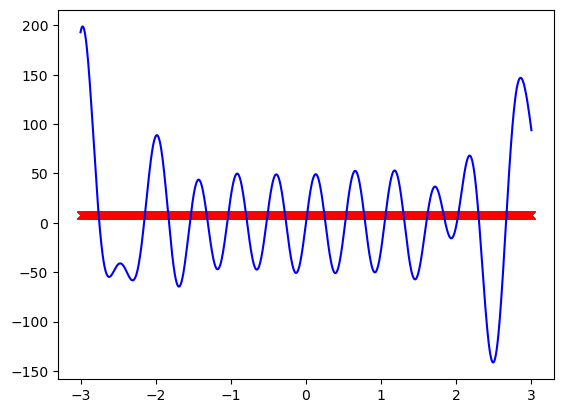

In [12]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [15]:
import scipy.io as sio
import numpy as np

for tune_reps in range(5):
    label = "Regr_swish_tune"+str(tune_reps)+".mat"
    data = sio.loadmat(label)
    re = np.array(data["test_re"])
    print(tune_reps," ",np.mean(re[:,-1]))

0   0.9999213861626105
1   0.9977495706290881
2   0.7484116376325677
3   0.5672534771080222
4   0.9628252082552837
